In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100000_2048_1024_512_256_128_0001_CCE_7_1_1_0_1_0_e_e_0_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_0_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 831)
(4629816, 8)
validation
(621056, 831)
(621056, 8)
test
(624904, 831)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 2048)              1703936   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 4492168 (17.14 MB)


Trainable params: 4492168 (17.14 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 3:25 - loss: 2.4241 - STD: 0.0883 - MAE: 0.2205

 2/47 [>.............................] - ETA: 20s - loss: 2.2984 - STD: 0.0650 - MAE: 0.2201 

 3/47 [>.............................] - ETA: 19s - loss: 2.2229 - STD: 0.0502 - MAE: 0.2194

 4/47 [=>............................] - ETA: 19s - loss: 2.1819 - STD: 0.0488 - MAE: 0.2185

 5/47 [==>...........................] - ETA: 19s - loss: 2.1617 - STD: 0.0524 - MAE: 0.2178

 6/47 [==>...........................] - ETA: 18s - loss: 2.1523 - STD: 0.0559 - MAE: 0.2172

 7/47 [===>..........................] - ETA: 18s - loss: 2.1456 - STD: 0.0579 - MAE: 0.2169

 8/47 [====>.........................] - ETA: 17s - loss: 2.1396 - STD: 0.0584 - MAE: 0.2167

 9/47 [====>.........................] - ETA: 17s - loss: 2.1337 - STD: 0.0578 - MAE: 0.2166

10/47 [=====>........................] - ETA: 20s - loss: 2.1317 - STD: 0.0565 - MAE: 0.2166

11/47 [======>.......................] - ETA: 19s - loss: 2.1252 - STD: 0.0548 - MAE: 0.2166

12/47 [======>.......................] - ETA: 18s - loss: 2.1195 - STD: 0.0530 - MAE: 0.2166

13/47 [=======>......................] - ETA: 17s - loss: 2.1144 - STD: 0.0511 - MAE: 0.2166

14/47 [=======>......................] - ETA: 17s - loss: 2.1099 - STD: 0.0495 - MAE: 0.2167

15/47 [========>.....................] - ETA: 16s - loss: 2.1061 - STD: 0.0480 - MAE: 0.2167

16/47 [=========>....................] - ETA: 15s - loss: 2.1030 - STD: 0.0469 - MAE: 0.2167

17/47 [=========>....................] - ETA: 15s - loss: 2.1004 - STD: 0.0460 - MAE: 0.2167

18/47 [==========>...................] - ETA: 14s - loss: 2.0983 - STD: 0.0452 - MAE: 0.2167

19/47 [===========>..................] - ETA: 14s - loss: 2.0964 - STD: 0.0446 - MAE: 0.2168

20/47 [===========>..................] - ETA: 13s - loss: 2.0946 - STD: 0.0440 - MAE: 0.2168

21/47 [============>.................] - ETA: 12s - loss: 2.0929 - STD: 0.0434 - MAE: 0.2168

22/47 [=============>................] - ETA: 12s - loss: 2.0911 - STD: 0.0428 - MAE: 0.2168

23/47 [=============>................] - ETA: 11s - loss: 2.0895 - STD: 0.0422 - MAE: 0.2168

24/47 [==============>...............] - ETA: 11s - loss: 2.0879 - STD: 0.0417 - MAE: 0.2168

25/47 [==============>...............] - ETA: 10s - loss: 2.0864 - STD: 0.0412 - MAE: 0.2168

26/47 [===============>..............] - ETA: 10s - loss: 2.0850 - STD: 0.0409 - MAE: 0.2168

27/47 [================>.............] - ETA: 9s - loss: 2.0837 - STD: 0.0406 - MAE: 0.2168 

28/47 [================>.............] - ETA: 9s - loss: 2.0826 - STD: 0.0405 - MAE: 0.2168

29/47 [=================>............] - ETA: 8s - loss: 2.0817 - STD: 0.0404 - MAE: 0.2168

30/47 [==================>...........] - ETA: 8s - loss: 2.0808 - STD: 0.0403 - MAE: 0.2168

31/47 [==================>...........] - ETA: 7s - loss: 2.0799 - STD: 0.0402 - MAE: 0.2167

32/47 [===================>..........] - ETA: 7s - loss: 2.0791 - STD: 0.0401 - MAE: 0.2167

33/47 [====================>.........] - ETA: 6s - loss: 2.0783 - STD: 0.0400 - MAE: 0.2167

34/47 [====================>.........] - ETA: 6s - loss: 2.0775 - STD: 0.0398 - MAE: 0.2167

35/47 [=====================>........] - ETA: 5s - loss: 2.0767 - STD: 0.0397 - MAE: 0.2167

36/47 [=====================>........] - ETA: 5s - loss: 2.0760 - STD: 0.0395 - MAE: 0.2167

37/47 [======================>.......] - ETA: 4s - loss: 2.0753 - STD: 0.0393 - MAE: 0.2167

38/47 [=======================>......] - ETA: 4s - loss: 2.0747 - STD: 0.0391 - MAE: 0.2167

39/47 [=======================>......] - ETA: 3s - loss: 2.0741 - STD: 0.0389 - MAE: 0.2167

40/47 [========================>.....] - ETA: 3s - loss: 2.0736 - STD: 0.0387 - MAE: 0.2167

41/47 [=========================>....] - ETA: 2s - loss: 2.0731 - STD: 0.0385 - MAE: 0.2167

42/47 [=========================>....] - ETA: 2s - loss: 2.0725 - STD: 0.0383 - MAE: 0.2167

43/47 [==========================>...] - ETA: 1s - loss: 2.0720 - STD: 0.0381 - MAE: 0.2167

44/47 [===========================>..] - ETA: 1s - loss: 2.0716 - STD: 0.0379 - MAE: 0.2167

45/47 [===========================>..] - ETA: 0s - loss: 2.0712 - STD: 0.0377 - MAE: 0.2167

46/47 [============================>.] - ETA: 0s - loss: 2.0708 - STD: 0.0376 - MAE: 0.2167

47/47 [==============================] - ETA: 0s - loss: 2.0704 - STD: 0.0374 - MAE: 0.2167

47/47 [==============================] - 28s 517ms/step - loss: 2.0704 - STD: 0.0374 - MAE: 0.2167 - val_loss: 2.0509 - val_STD: 0.0304 - val_MAE: 0.2168


Epoch 2/10000


 1/47 [..............................] - ETA: 28s - loss: 2.0510 - STD: 0.0304 - MAE: 0.2168

 2/47 [>.............................] - ETA: 20s - loss: 2.0505 - STD: 0.0307 - MAE: 0.2168

 3/47 [>.............................] - ETA: 20s - loss: 2.0510 - STD: 0.0311 - MAE: 0.2168

 4/47 [=>............................] - ETA: 19s - loss: 2.0512 - STD: 0.0315 - MAE: 0.2167

 5/47 [==>...........................] - ETA: 19s - loss: 2.0509 - STD: 0.0319 - MAE: 0.2167

 6/47 [==>...........................] - ETA: 18s - loss: 2.0509 - STD: 0.0323 - MAE: 0.2167

 7/47 [===>..........................] - ETA: 18s - loss: 2.0508 - STD: 0.0326 - MAE: 0.2166

 8/47 [====>.........................] - ETA: 17s - loss: 2.0509 - STD: 0.0329 - MAE: 0.2166

 9/47 [====>.........................] - ETA: 17s - loss: 2.0509 - STD: 0.0331 - MAE: 0.2166

10/47 [=====>........................] - ETA: 16s - loss: 2.0510 - STD: 0.0332 - MAE: 0.2166

11/47 [======>.......................] - ETA: 16s - loss: 2.0511 - STD: 0.0332 - MAE: 0.2166

12/47 [======>.......................] - ETA: 15s - loss: 2.0512 - STD: 0.0331 - MAE: 0.2166

13/47 [=======>......................] - ETA: 15s - loss: 2.0512 - STD: 0.0329 - MAE: 0.2166

14/47 [=======>......................] - ETA: 14s - loss: 2.0512 - STD: 0.0326 - MAE: 0.2167

15/47 [========>.....................] - ETA: 14s - loss: 2.0512 - STD: 0.0324 - MAE: 0.2167

16/47 [=========>....................] - ETA: 14s - loss: 2.0512 - STD: 0.0323 - MAE: 0.2167

17/47 [=========>....................] - ETA: 13s - loss: 2.0512 - STD: 0.0322 - MAE: 0.2167

18/47 [==========>...................] - ETA: 13s - loss: 2.0512 - STD: 0.0321 - MAE: 0.2167

19/47 [===========>..................] - ETA: 12s - loss: 2.0512 - STD: 0.0321 - MAE: 0.2167

20/47 [===========>..................] - ETA: 12s - loss: 2.0511 - STD: 0.0321 - MAE: 0.2167

21/47 [============>.................] - ETA: 11s - loss: 2.0510 - STD: 0.0322 - MAE: 0.2167

22/47 [=============>................] - ETA: 11s - loss: 2.0510 - STD: 0.0322 - MAE: 0.2167

23/47 [=============>................] - ETA: 10s - loss: 2.0510 - STD: 0.0323 - MAE: 0.2167

24/47 [==============>...............] - ETA: 10s - loss: 2.0510 - STD: 0.0323 - MAE: 0.2167

25/47 [==============>...............] - ETA: 9s - loss: 2.0510 - STD: 0.0323 - MAE: 0.2167 

26/47 [===============>..............] - ETA: 9s - loss: 2.0509 - STD: 0.0323 - MAE: 0.2167

27/47 [================>.............] - ETA: 9s - loss: 2.0509 - STD: 0.0322 - MAE: 0.2167

28/47 [================>.............] - ETA: 8s - loss: 2.0509 - STD: 0.0322 - MAE: 0.2167

29/47 [=================>............] - ETA: 8s - loss: 2.0508 - STD: 0.0322 - MAE: 0.2167

30/47 [==================>...........] - ETA: 7s - loss: 2.0508 - STD: 0.0322 - MAE: 0.2167

31/47 [==================>...........] - ETA: 7s - loss: 2.0507 - STD: 0.0322 - MAE: 0.2167

32/47 [===================>..........] - ETA: 6s - loss: 2.0507 - STD: 0.0322 - MAE: 0.2167

33/47 [====================>.........] - ETA: 6s - loss: 2.0506 - STD: 0.0322 - MAE: 0.2167

34/47 [====================>.........] - ETA: 5s - loss: 2.0505 - STD: 0.0322 - MAE: 0.2167

35/47 [=====================>........] - ETA: 5s - loss: 2.0505 - STD: 0.0322 - MAE: 0.2167

36/47 [=====================>........] - ETA: 5s - loss: 2.0503 - STD: 0.0322 - MAE: 0.2167

37/47 [======================>.......] - ETA: 4s - loss: 2.0502 - STD: 0.0322 - MAE: 0.2167

38/47 [=======================>......] - ETA: 4s - loss: 2.0500 - STD: 0.0321 - MAE: 0.2167

39/47 [=======================>......] - ETA: 3s - loss: 2.0498 - STD: 0.0321 - MAE: 0.2167

40/47 [========================>.....] - ETA: 3s - loss: 2.0496 - STD: 0.0321 - MAE: 0.2166

41/47 [=========================>....] - ETA: 2s - loss: 2.0495 - STD: 0.0321 - MAE: 0.2166

42/47 [=========================>....] - ETA: 2s - loss: 2.0492 - STD: 0.0321 - MAE: 0.2166

43/47 [==========================>...] - ETA: 1s - loss: 2.0488 - STD: 0.0321 - MAE: 0.2166

44/47 [===========================>..] - ETA: 1s - loss: 2.0483 - STD: 0.0321 - MAE: 0.2166

45/47 [===========================>..] - ETA: 0s - loss: 2.0478 - STD: 0.0321 - MAE: 0.2166

46/47 [============================>.] - ETA: 0s - loss: 2.0472 - STD: 0.0321 - MAE: 0.2166

47/47 [==============================] - ETA: 0s - loss: 2.0465 - STD: 0.0322 - MAE: 0.2165

47/47 [==============================] - 22s 473ms/step - loss: 2.0465 - STD: 0.0322 - MAE: 0.2165 - val_loss: 2.0056 - val_STD: 0.0336 - val_MAE: 0.2151


Epoch 3/10000


 1/47 [..............................] - ETA: 29s - loss: 2.0058 - STD: 0.0347 - MAE: 0.2151

 2/47 [>.............................] - ETA: 20s - loss: 2.0011 - STD: 0.0348 - MAE: 0.2149

 3/47 [>.............................] - ETA: 20s - loss: 1.9968 - STD: 0.0353 - MAE: 0.2148

 4/47 [=>............................] - ETA: 19s - loss: 1.9915 - STD: 0.0357 - MAE: 0.2146

 5/47 [==>...........................] - ETA: 19s - loss: 1.9864 - STD: 0.0367 - MAE: 0.2144

 6/47 [==>...........................] - ETA: 18s - loss: 1.9808 - STD: 0.0374 - MAE: 0.2142

 7/47 [===>..........................] - ETA: 18s - loss: 1.9751 - STD: 0.0386 - MAE: 0.2139

 8/47 [====>.........................] - ETA: 17s - loss: 1.9687 - STD: 0.0398 - MAE: 0.2136

 9/47 [====>.........................] - ETA: 17s - loss: 1.9623 - STD: 0.0411 - MAE: 0.2133

10/47 [=====>........................] - ETA: 16s - loss: 1.9556 - STD: 0.0426 - MAE: 0.2130

11/47 [======>.......................] - ETA: 16s - loss: 1.9489 - STD: 0.0442 - MAE: 0.2127

12/47 [======>.......................] - ETA: 15s - loss: 1.9421 - STD: 0.0458 - MAE: 0.2123

13/47 [=======>......................] - ETA: 15s - loss: 1.9371 - STD: 0.0475 - MAE: 0.2120

14/47 [=======>......................] - ETA: 15s - loss: 1.9331 - STD: 0.0492 - MAE: 0.2117

15/47 [========>.....................] - ETA: 14s - loss: 1.9266 - STD: 0.0508 - MAE: 0.2114

16/47 [=========>....................] - ETA: 14s - loss: 1.9228 - STD: 0.0524 - MAE: 0.2111

17/47 [=========>....................] - ETA: 13s - loss: 1.9169 - STD: 0.0539 - MAE: 0.2107

18/47 [==========>...................] - ETA: 13s - loss: 1.9135 - STD: 0.0554 - MAE: 0.2105

19/47 [===========>..................] - ETA: 12s - loss: 1.9081 - STD: 0.0567 - MAE: 0.2102

20/47 [===========>..................] - ETA: 12s - loss: 1.9047 - STD: 0.0579 - MAE: 0.2099

21/47 [============>.................] - ETA: 11s - loss: 1.8998 - STD: 0.0590 - MAE: 0.2097

22/47 [=============>................] - ETA: 11s - loss: 1.8962 - STD: 0.0600 - MAE: 0.2095

23/47 [=============>................] - ETA: 10s - loss: 1.8917 - STD: 0.0609 - MAE: 0.2092

24/47 [==============>...............] - ETA: 10s - loss: 1.8885 - STD: 0.0617 - MAE: 0.2091

25/47 [==============>...............] - ETA: 10s - loss: 1.8843 - STD: 0.0625 - MAE: 0.2089

26/47 [===============>..............] - ETA: 9s - loss: 1.8812 - STD: 0.0633 - MAE: 0.2087 

27/47 [================>.............] - ETA: 9s - loss: 1.8773 - STD: 0.0640 - MAE: 0.2085

28/47 [================>.............] - ETA: 8s - loss: 1.8742 - STD: 0.0647 - MAE: 0.2083

29/47 [=================>............] - ETA: 8s - loss: 1.8706 - STD: 0.0654 - MAE: 0.2081

30/47 [==================>...........] - ETA: 7s - loss: 1.8676 - STD: 0.0661 - MAE: 0.2079

31/47 [==================>...........] - ETA: 7s - loss: 1.8642 - STD: 0.0668 - MAE: 0.2077

32/47 [===================>..........] - ETA: 6s - loss: 1.8612 - STD: 0.0674 - MAE: 0.2076

33/47 [====================>.........] - ETA: 6s - loss: 1.8581 - STD: 0.0680 - MAE: 0.2074

34/47 [====================>.........] - ETA: 5s - loss: 1.8552 - STD: 0.0687 - MAE: 0.2072

35/47 [=====================>........] - ETA: 5s - loss: 1.8523 - STD: 0.0692 - MAE: 0.2071

36/47 [=====================>........] - ETA: 5s - loss: 1.8496 - STD: 0.0698 - MAE: 0.2069

37/47 [======================>.......] - ETA: 4s - loss: 1.8470 - STD: 0.0704 - MAE: 0.2068

38/47 [=======================>......] - ETA: 4s - loss: 1.8443 - STD: 0.0710 - MAE: 0.2066

39/47 [=======================>......] - ETA: 3s - loss: 1.8419 - STD: 0.0715 - MAE: 0.2065

40/47 [========================>.....] - ETA: 3s - loss: 1.8411 - STD: 0.0720 - MAE: 0.2063

41/47 [=========================>....] - ETA: 2s - loss: 1.8386 - STD: 0.0725 - MAE: 0.2062

42/47 [=========================>....] - ETA: 2s - loss: 1.8362 - STD: 0.0730 - MAE: 0.2060

43/47 [==========================>...] - ETA: 1s - loss: 1.8337 - STD: 0.0734 - MAE: 0.2059

44/47 [===========================>..] - ETA: 1s - loss: 1.8314 - STD: 0.0739 - MAE: 0.2058

45/47 [===========================>..] - ETA: 0s - loss: 1.8291 - STD: 0.0744 - MAE: 0.2056

46/47 [============================>.] - ETA: 0s - loss: 1.8269 - STD: 0.0748 - MAE: 0.2055

47/47 [==============================] - ETA: 0s - loss: 1.8248 - STD: 0.0753 - MAE: 0.2054

47/47 [==============================] - 22s 473ms/step - loss: 1.8248 - STD: 0.0753 - MAE: 0.2054 - val_loss: 1.7047 - val_STD: 0.0904 - val_MAE: 0.1997


Epoch 4/10000


 1/47 [..............................] - ETA: 28s - loss: 1.7198 - STD: 0.0954 - MAE: 0.1992

 2/47 [>.............................] - ETA: 20s - loss: 1.7249 - STD: 0.0956 - MAE: 0.1993

 3/47 [>.............................] - ETA: 20s - loss: 1.7242 - STD: 0.0959 - MAE: 0.1992

 4/47 [=>............................] - ETA: 19s - loss: 1.7221 - STD: 0.0961 - MAE: 0.1991

 5/47 [==>...........................] - ETA: 19s - loss: 1.7222 - STD: 0.0963 - MAE: 0.1991

 6/47 [==>...........................] - ETA: 18s - loss: 1.7216 - STD: 0.0965 - MAE: 0.1990

 7/47 [===>..........................] - ETA: 18s - loss: 1.7206 - STD: 0.0967 - MAE: 0.1989

 8/47 [====>.........................] - ETA: 17s - loss: 1.7197 - STD: 0.0969 - MAE: 0.1989

 9/47 [====>.........................] - ETA: 17s - loss: 1.7188 - STD: 0.0971 - MAE: 0.1988

10/47 [=====>........................] - ETA: 16s - loss: 1.7179 - STD: 0.0972 - MAE: 0.1987

11/47 [======>.......................] - ETA: 16s - loss: 1.7171 - STD: 0.0974 - MAE: 0.1987

12/47 [======>.......................] - ETA: 15s - loss: 1.7165 - STD: 0.0977 - MAE: 0.1986

13/47 [=======>......................] - ETA: 15s - loss: 1.7157 - STD: 0.0980 - MAE: 0.1985

14/47 [=======>......................] - ETA: 15s - loss: 1.7147 - STD: 0.0982 - MAE: 0.1984

15/47 [========>.....................] - ETA: 14s - loss: 1.7139 - STD: 0.0984 - MAE: 0.1983

16/47 [=========>....................] - ETA: 14s - loss: 1.7132 - STD: 0.0986 - MAE: 0.1983

17/47 [=========>....................] - ETA: 13s - loss: 1.7122 - STD: 0.0987 - MAE: 0.1982

18/47 [==========>...................] - ETA: 13s - loss: 1.7112 - STD: 0.0989 - MAE: 0.1981

19/47 [===========>..................] - ETA: 12s - loss: 1.7103 - STD: 0.0991 - MAE: 0.1981

20/47 [===========>..................] - ETA: 12s - loss: 1.7096 - STD: 0.0993 - MAE: 0.1980

21/47 [============>.................] - ETA: 11s - loss: 1.7089 - STD: 0.0995 - MAE: 0.1979

22/47 [=============>................] - ETA: 11s - loss: 1.7081 - STD: 0.0996 - MAE: 0.1979

23/47 [=============>................] - ETA: 10s - loss: 1.7073 - STD: 0.0998 - MAE: 0.1978

24/47 [==============>...............] - ETA: 10s - loss: 1.7064 - STD: 0.1000 - MAE: 0.1978

25/47 [==============>...............] - ETA: 10s - loss: 1.7054 - STD: 0.1001 - MAE: 0.1977

26/47 [===============>..............] - ETA: 9s - loss: 1.7045 - STD: 0.1003 - MAE: 0.1976 

27/47 [================>.............] - ETA: 9s - loss: 1.7036 - STD: 0.1005 - MAE: 0.1975

28/47 [================>.............] - ETA: 8s - loss: 1.7031 - STD: 0.1007 - MAE: 0.1975

29/47 [=================>............] - ETA: 8s - loss: 1.7026 - STD: 0.1009 - MAE: 0.1974

30/47 [==================>...........] - ETA: 7s - loss: 1.7024 - STD: 0.1010 - MAE: 0.1974

31/47 [==================>...........] - ETA: 7s - loss: 1.7023 - STD: 0.1012 - MAE: 0.1973

32/47 [===================>..........] - ETA: 6s - loss: 1.7017 - STD: 0.1013 - MAE: 0.1973

33/47 [====================>.........] - ETA: 6s - loss: 1.7015 - STD: 0.1015 - MAE: 0.1972

34/47 [====================>.........] - ETA: 5s - loss: 1.7006 - STD: 0.1017 - MAE: 0.1972

35/47 [=====================>........] - ETA: 5s - loss: 1.7000 - STD: 0.1018 - MAE: 0.1971

36/47 [=====================>........] - ETA: 4s - loss: 1.6991 - STD: 0.1019 - MAE: 0.1971

37/47 [======================>.......] - ETA: 4s - loss: 1.6981 - STD: 0.1020 - MAE: 0.1970

38/47 [=======================>......] - ETA: 4s - loss: 1.6974 - STD: 0.1022 - MAE: 0.1969

39/47 [=======================>......] - ETA: 3s - loss: 1.6969 - STD: 0.1023 - MAE: 0.1969

40/47 [========================>.....] - ETA: 3s - loss: 1.6959 - STD: 0.1024 - MAE: 0.1968

41/47 [=========================>....] - ETA: 2s - loss: 1.6948 - STD: 0.1025 - MAE: 0.1968

42/47 [=========================>....] - ETA: 2s - loss: 1.6939 - STD: 0.1027 - MAE: 0.1967

43/47 [==========================>...] - ETA: 1s - loss: 1.6933 - STD: 0.1028 - MAE: 0.1967

44/47 [===========================>..] - ETA: 1s - loss: 1.6925 - STD: 0.1029 - MAE: 0.1966

45/47 [===========================>..] - ETA: 0s - loss: 1.6916 - STD: 0.1030 - MAE: 0.1965

46/47 [============================>.] - ETA: 0s - loss: 1.6906 - STD: 0.1032 - MAE: 0.1965

47/47 [==============================] - ETA: 0s - loss: 1.6897 - STD: 0.1033 - MAE: 0.1964

47/47 [==============================] - 22s 474ms/step - loss: 1.6897 - STD: 0.1033 - MAE: 0.1964 - val_loss: 1.6512 - val_STD: 0.1040 - val_MAE: 0.1949


Epoch 5/10000


 1/47 [..............................] - ETA: 28s - loss: 1.6502 - STD: 0.1079 - MAE: 0.1938

 2/47 [>.............................] - ETA: 20s - loss: 1.6506 - STD: 0.1085 - MAE: 0.1937

 3/47 [>.............................] - ETA: 20s - loss: 1.6456 - STD: 0.1085 - MAE: 0.1935

 4/47 [=>............................] - ETA: 19s - loss: 1.6422 - STD: 0.1086 - MAE: 0.1933

 5/47 [==>...........................] - ETA: 19s - loss: 1.6409 - STD: 0.1090 - MAE: 0.1932

 6/47 [==>...........................] - ETA: 18s - loss: 1.6415 - STD: 0.1090 - MAE: 0.1932

 7/47 [===>..........................] - ETA: 18s - loss: 1.6415 - STD: 0.1094 - MAE: 0.1931

 8/47 [====>.........................] - ETA: 17s - loss: 1.6411 - STD: 0.1094 - MAE: 0.1930

 9/47 [====>.........................] - ETA: 17s - loss: 1.6388 - STD: 0.1096 - MAE: 0.1929

10/47 [=====>........................] - ETA: 16s - loss: 1.6365 - STD: 0.1097 - MAE: 0.1927

11/47 [======>.......................] - ETA: 16s - loss: 1.6345 - STD: 0.1098 - MAE: 0.1926

12/47 [======>.......................] - ETA: 15s - loss: 1.6328 - STD: 0.1100 - MAE: 0.1925

13/47 [=======>......................] - ETA: 15s - loss: 1.6317 - STD: 0.1100 - MAE: 0.1924

14/47 [=======>......................] - ETA: 15s - loss: 1.6301 - STD: 0.1103 - MAE: 0.1923

15/47 [========>.....................] - ETA: 14s - loss: 1.6284 - STD: 0.1104 - MAE: 0.1922

16/47 [=========>....................] - ETA: 14s - loss: 1.6257 - STD: 0.1107 - MAE: 0.1920

17/47 [=========>....................] - ETA: 13s - loss: 1.6228 - STD: 0.1109 - MAE: 0.1918

18/47 [==========>...................] - ETA: 13s - loss: 1.6200 - STD: 0.1110 - MAE: 0.1917

19/47 [===========>..................] - ETA: 12s - loss: 1.6180 - STD: 0.1114 - MAE: 0.1915

20/47 [===========>..................] - ETA: 12s - loss: 1.6163 - STD: 0.1116 - MAE: 0.1914

21/47 [============>.................] - ETA: 11s - loss: 1.6150 - STD: 0.1120 - MAE: 0.1912

22/47 [=============>................] - ETA: 11s - loss: 1.6136 - STD: 0.1121 - MAE: 0.1911

23/47 [=============>................] - ETA: 10s - loss: 1.6109 - STD: 0.1124 - MAE: 0.1909

24/47 [==============>...............] - ETA: 10s - loss: 1.6082 - STD: 0.1127 - MAE: 0.1907

25/47 [==============>...............] - ETA: 10s - loss: 1.6058 - STD: 0.1130 - MAE: 0.1905

26/47 [===============>..............] - ETA: 9s - loss: 1.6040 - STD: 0.1136 - MAE: 0.1903 

27/47 [================>.............] - ETA: 9s - loss: 1.6022 - STD: 0.1139 - MAE: 0.1902

28/47 [================>.............] - ETA: 8s - loss: 1.5996 - STD: 0.1143 - MAE: 0.1900

29/47 [=================>............] - ETA: 8s - loss: 1.5974 - STD: 0.1147 - MAE: 0.1898

30/47 [==================>...........] - ETA: 7s - loss: 1.5952 - STD: 0.1150 - MAE: 0.1896

31/47 [==================>...........] - ETA: 7s - loss: 1.5935 - STD: 0.1154 - MAE: 0.1894

32/47 [===================>..........] - ETA: 6s - loss: 1.5914 - STD: 0.1158 - MAE: 0.1892

33/47 [====================>.........] - ETA: 6s - loss: 1.5890 - STD: 0.1161 - MAE: 0.1890

34/47 [====================>.........] - ETA: 5s - loss: 1.5870 - STD: 0.1165 - MAE: 0.1889

35/47 [=====================>........] - ETA: 5s - loss: 1.5849 - STD: 0.1169 - MAE: 0.1887

36/47 [=====================>........] - ETA: 5s - loss: 1.5833 - STD: 0.1173 - MAE: 0.1885

37/47 [======================>.......] - ETA: 4s - loss: 1.5809 - STD: 0.1176 - MAE: 0.1883

38/47 [=======================>......] - ETA: 4s - loss: 1.5787 - STD: 0.1180 - MAE: 0.1882

39/47 [=======================>......] - ETA: 3s - loss: 1.5764 - STD: 0.1183 - MAE: 0.1880

40/47 [========================>.....] - ETA: 3s - loss: 1.5758 - STD: 0.1186 - MAE: 0.1878

41/47 [=========================>....] - ETA: 2s - loss: 1.5736 - STD: 0.1189 - MAE: 0.1876

42/47 [=========================>....] - ETA: 2s - loss: 1.5714 - STD: 0.1192 - MAE: 0.1875

43/47 [==========================>...] - ETA: 1s - loss: 1.5692 - STD: 0.1195 - MAE: 0.1873

44/47 [===========================>..] - ETA: 1s - loss: 1.5669 - STD: 0.1199 - MAE: 0.1871

45/47 [===========================>..] - ETA: 0s - loss: 1.5649 - STD: 0.1202 - MAE: 0.1870

46/47 [============================>.] - ETA: 0s - loss: 1.5628 - STD: 0.1205 - MAE: 0.1868

47/47 [==============================] - ETA: 0s - loss: 1.5608 - STD: 0.1208 - MAE: 0.1867

47/47 [==============================] - 22s 475ms/step - loss: 1.5608 - STD: 0.1208 - MAE: 0.1867 - val_loss: 1.5050 - val_STD: 0.1303 - val_MAE: 0.1817


Epoch 6/10000


 1/47 [..............................] - ETA: 28s - loss: 1.4609 - STD: 0.1344 - MAE: 0.1791

 2/47 [>.............................] - ETA: 20s - loss: 1.4574 - STD: 0.1346 - MAE: 0.1789

 3/47 [>.............................] - ETA: 20s - loss: 1.4579 - STD: 0.1349 - MAE: 0.1788

 4/47 [=>............................] - ETA: 19s - loss: 1.4579 - STD: 0.1353 - MAE: 0.1787

 5/47 [==>...........................] - ETA: 19s - loss: 1.4579 - STD: 0.1355 - MAE: 0.1787

 6/47 [==>...........................] - ETA: 18s - loss: 1.4572 - STD: 0.1359 - MAE: 0.1785

 7/47 [===>..........................] - ETA: 18s - loss: 1.4562 - STD: 0.1362 - MAE: 0.1784

 8/47 [====>.........................] - ETA: 17s - loss: 1.4551 - STD: 0.1363 - MAE: 0.1783

 9/47 [====>.........................] - ETA: 17s - loss: 1.4538 - STD: 0.1365 - MAE: 0.1782

10/47 [=====>........................] - ETA: 16s - loss: 1.4522 - STD: 0.1367 - MAE: 0.1781

11/47 [======>.......................] - ETA: 16s - loss: 1.4504 - STD: 0.1369 - MAE: 0.1780

12/47 [======>.......................] - ETA: 15s - loss: 1.4488 - STD: 0.1372 - MAE: 0.1778

13/47 [=======>......................] - ETA: 15s - loss: 1.4468 - STD: 0.1374 - MAE: 0.1777

14/47 [=======>......................] - ETA: 15s - loss: 1.4451 - STD: 0.1376 - MAE: 0.1775

15/47 [========>.....................] - ETA: 14s - loss: 1.4437 - STD: 0.1379 - MAE: 0.1774

16/47 [=========>....................] - ETA: 14s - loss: 1.4425 - STD: 0.1381 - MAE: 0.1773

17/47 [=========>....................] - ETA: 13s - loss: 1.4425 - STD: 0.1383 - MAE: 0.1772

18/47 [==========>...................] - ETA: 13s - loss: 1.4445 - STD: 0.1386 - MAE: 0.1772

19/47 [===========>..................] - ETA: 12s - loss: 1.4480 - STD: 0.1388 - MAE: 0.1773

20/47 [===========>..................] - ETA: 12s - loss: 1.4503 - STD: 0.1391 - MAE: 0.1773

21/47 [============>.................] - ETA: 11s - loss: 1.4491 - STD: 0.1392 - MAE: 0.1772

22/47 [=============>................] - ETA: 11s - loss: 1.4497 - STD: 0.1395 - MAE: 0.1771

23/47 [=============>................] - ETA: 10s - loss: 1.4500 - STD: 0.1398 - MAE: 0.1771

24/47 [==============>...............] - ETA: 10s - loss: 1.4487 - STD: 0.1399 - MAE: 0.1770

25/47 [==============>...............] - ETA: 10s - loss: 1.4493 - STD: 0.1402 - MAE: 0.1769

26/47 [===============>..............] - ETA: 9s - loss: 1.4481 - STD: 0.1404 - MAE: 0.1768 

27/47 [================>.............] - ETA: 9s - loss: 1.4477 - STD: 0.1405 - MAE: 0.1767

28/47 [================>.............] - ETA: 8s - loss: 1.4471 - STD: 0.1407 - MAE: 0.1767

29/47 [=================>............] - ETA: 8s - loss: 1.4457 - STD: 0.1408 - MAE: 0.1766

30/47 [==================>...........] - ETA: 7s - loss: 1.4452 - STD: 0.1409 - MAE: 0.1765

31/47 [==================>...........] - ETA: 7s - loss: 1.4435 - STD: 0.1410 - MAE: 0.1764

32/47 [===================>..........] - ETA: 6s - loss: 1.4425 - STD: 0.1412 - MAE: 0.1763

33/47 [====================>.........] - ETA: 6s - loss: 1.4409 - STD: 0.1413 - MAE: 0.1762

34/47 [====================>.........] - ETA: 5s - loss: 1.4399 - STD: 0.1414 - MAE: 0.1761

35/47 [=====================>........] - ETA: 5s - loss: 1.4385 - STD: 0.1416 - MAE: 0.1760

36/47 [=====================>........] - ETA: 5s - loss: 1.4370 - STD: 0.1417 - MAE: 0.1759

37/47 [======================>.......] - ETA: 4s - loss: 1.4358 - STD: 0.1418 - MAE: 0.1758

38/47 [=======================>......] - ETA: 4s - loss: 1.4341 - STD: 0.1419 - MAE: 0.1757

39/47 [=======================>......] - ETA: 3s - loss: 1.4329 - STD: 0.1421 - MAE: 0.1756

40/47 [========================>.....] - ETA: 3s - loss: 1.4325 - STD: 0.1422 - MAE: 0.1755

41/47 [=========================>....] - ETA: 2s - loss: 1.4312 - STD: 0.1423 - MAE: 0.1754

42/47 [=========================>....] - ETA: 2s - loss: 1.4296 - STD: 0.1425 - MAE: 0.1753

43/47 [==========================>...] - ETA: 1s - loss: 1.4282 - STD: 0.1427 - MAE: 0.1752

44/47 [===========================>..] - ETA: 1s - loss: 1.4269 - STD: 0.1428 - MAE: 0.1750

45/47 [===========================>..] - ETA: 0s - loss: 1.4253 - STD: 0.1430 - MAE: 0.1749

46/47 [============================>.] - ETA: 0s - loss: 1.4239 - STD: 0.1431 - MAE: 0.1748

47/47 [==============================] - ETA: 0s - loss: 1.4225 - STD: 0.1433 - MAE: 0.1747

47/47 [==============================] - 22s 475ms/step - loss: 1.4225 - STD: 0.1433 - MAE: 0.1747 - val_loss: 1.4297 - val_STD: 0.1451 - val_MAE: 0.1737


Epoch 7/10000


 1/47 [..............................] - ETA: 28s - loss: 1.3611 - STD: 0.1501 - MAE: 0.1698

 2/47 [>.............................] - ETA: 20s - loss: 1.3587 - STD: 0.1516 - MAE: 0.1692

 3/47 [>.............................] - ETA: 20s - loss: 1.3555 - STD: 0.1521 - MAE: 0.1690

 4/47 [=>............................] - ETA: 19s - loss: 1.3561 - STD: 0.1517 - MAE: 0.1691

 5/47 [==>...........................] - ETA: 19s - loss: 1.3558 - STD: 0.1523 - MAE: 0.1689

 6/47 [==>...........................] - ETA: 18s - loss: 1.3564 - STD: 0.1522 - MAE: 0.1690

 7/47 [===>..........................] - ETA: 18s - loss: 1.3568 - STD: 0.1529 - MAE: 0.1688

 8/47 [====>.........................] - ETA: 17s - loss: 1.3570 - STD: 0.1528 - MAE: 0.1688

 9/47 [====>.........................] - ETA: 17s - loss: 1.3562 - STD: 0.1533 - MAE: 0.1686

10/47 [=====>........................] - ETA: 16s - loss: 1.3538 - STD: 0.1535 - MAE: 0.1685

11/47 [======>.......................] - ETA: 16s - loss: 1.3522 - STD: 0.1536 - MAE: 0.1684

12/47 [======>.......................] - ETA: 16s - loss: 1.3510 - STD: 0.1539 - MAE: 0.1682

13/47 [=======>......................] - ETA: 15s - loss: 1.3504 - STD: 0.1540 - MAE: 0.1682

14/47 [=======>......................] - ETA: 15s - loss: 1.3501 - STD: 0.1543 - MAE: 0.1681

15/47 [========>.....................] - ETA: 14s - loss: 1.3498 - STD: 0.1543 - MAE: 0.1680

16/47 [=========>....................] - ETA: 14s - loss: 1.3491 - STD: 0.1546 - MAE: 0.1679

17/47 [=========>....................] - ETA: 13s - loss: 1.3480 - STD: 0.1547 - MAE: 0.1678

18/47 [==========>...................] - ETA: 13s - loss: 1.3469 - STD: 0.1549 - MAE: 0.1677

19/47 [===========>..................] - ETA: 12s - loss: 1.3457 - STD: 0.1550 - MAE: 0.1676

20/47 [===========>..................] - ETA: 11s - loss: 1.3454 - STD: 0.1552 - MAE: 0.1675

21/47 [============>.................] - ETA: 11s - loss: 1.3442 - STD: 0.1553 - MAE: 0.1674

22/47 [=============>................] - ETA: 11s - loss: 1.3431 - STD: 0.1555 - MAE: 0.1673

23/47 [=============>................] - ETA: 10s - loss: 1.3419 - STD: 0.1557 - MAE: 0.1672

24/47 [==============>...............] - ETA: 10s - loss: 1.3410 - STD: 0.1558 - MAE: 0.1672

25/47 [==============>...............] - ETA: 9s - loss: 1.3401 - STD: 0.1560 - MAE: 0.1671 

26/47 [===============>..............] - ETA: 9s - loss: 1.3394 - STD: 0.1561 - MAE: 0.1670

27/47 [================>.............] - ETA: 8s - loss: 1.3395 - STD: 0.1563 - MAE: 0.1669

28/47 [================>.............] - ETA: 8s - loss: 1.3412 - STD: 0.1563 - MAE: 0.1670

29/47 [=================>............] - ETA: 7s - loss: 1.3442 - STD: 0.1568 - MAE: 0.1670

30/47 [==================>...........] - ETA: 7s - loss: 1.3452 - STD: 0.1568 - MAE: 0.1670

31/47 [==================>...........] - ETA: 7s - loss: 1.3443 - STD: 0.1569 - MAE: 0.1670

32/47 [===================>..........] - ETA: 6s - loss: 1.3446 - STD: 0.1572 - MAE: 0.1669

33/47 [====================>.........] - ETA: 6s - loss: 1.3447 - STD: 0.1573 - MAE: 0.1669

34/47 [====================>.........] - ETA: 5s - loss: 1.3443 - STD: 0.1574 - MAE: 0.1668

35/47 [=====================>........] - ETA: 5s - loss: 1.3437 - STD: 0.1575 - MAE: 0.1668

36/47 [=====================>........] - ETA: 4s - loss: 1.3432 - STD: 0.1576 - MAE: 0.1667

37/47 [======================>.......] - ETA: 4s - loss: 1.3427 - STD: 0.1575 - MAE: 0.1667

38/47 [=======================>......] - ETA: 4s - loss: 1.3417 - STD: 0.1576 - MAE: 0.1666

39/47 [=======================>......] - ETA: 3s - loss: 1.3416 - STD: 0.1577 - MAE: 0.1666

40/47 [========================>.....] - ETA: 3s - loss: 1.3407 - STD: 0.1577 - MAE: 0.1666

41/47 [=========================>....] - ETA: 2s - loss: 1.3400 - STD: 0.1578 - MAE: 0.1665

42/47 [=========================>....] - ETA: 2s - loss: 1.3393 - STD: 0.1579 - MAE: 0.1665

43/47 [==========================>...] - ETA: 1s - loss: 1.3387 - STD: 0.1580 - MAE: 0.1664

44/47 [===========================>..] - ETA: 1s - loss: 1.3380 - STD: 0.1581 - MAE: 0.1663

45/47 [===========================>..] - ETA: 0s - loss: 1.3371 - STD: 0.1582 - MAE: 0.1663

46/47 [============================>.] - ETA: 0s - loss: 1.3365 - STD: 0.1584 - MAE: 0.1662

47/47 [==============================] - ETA: 0s - loss: 1.3358 - STD: 0.1585 - MAE: 0.1661

47/47 [==============================] - 22s 476ms/step - loss: 1.3358 - STD: 0.1585 - MAE: 0.1661 - val_loss: 1.3684 - val_STD: 0.1573 - val_MAE: 0.1672


Epoch 8/10000


 1/47 [..............................] - ETA: 28s - loss: 1.2957 - STD: 0.1612 - MAE: 0.1634

 2/47 [>.............................] - ETA: 20s - loss: 1.3010 - STD: 0.1629 - MAE: 0.1632

 3/47 [>.............................] - ETA: 19s - loss: 1.2984 - STD: 0.1624 - MAE: 0.1633

 4/47 [=>............................] - ETA: 19s - loss: 1.2999 - STD: 0.1619 - MAE: 0.1634

 5/47 [==>...........................] - ETA: 19s - loss: 1.2981 - STD: 0.1620 - MAE: 0.1633

 6/47 [==>...........................] - ETA: 18s - loss: 1.2981 - STD: 0.1620 - MAE: 0.1633

 7/47 [===>..........................] - ETA: 18s - loss: 1.2979 - STD: 0.1618 - MAE: 0.1634

 8/47 [====>.........................] - ETA: 17s - loss: 1.2973 - STD: 0.1618 - MAE: 0.1634

 9/47 [====>.........................] - ETA: 17s - loss: 1.2963 - STD: 0.1621 - MAE: 0.1632

10/47 [=====>........................] - ETA: 16s - loss: 1.2958 - STD: 0.1624 - MAE: 0.1631

11/47 [======>.......................] - ETA: 16s - loss: 1.2955 - STD: 0.1624 - MAE: 0.1631

12/47 [======>.......................] - ETA: 15s - loss: 1.2948 - STD: 0.1627 - MAE: 0.1630

13/47 [=======>......................] - ETA: 15s - loss: 1.2937 - STD: 0.1629 - MAE: 0.1629

14/47 [=======>......................] - ETA: 14s - loss: 1.2933 - STD: 0.1629 - MAE: 0.1628

15/47 [========>.....................] - ETA: 14s - loss: 1.2926 - STD: 0.1632 - MAE: 0.1627

16/47 [=========>....................] - ETA: 14s - loss: 1.2926 - STD: 0.1633 - MAE: 0.1627

17/47 [=========>....................] - ETA: 13s - loss: 1.2927 - STD: 0.1635 - MAE: 0.1626

18/47 [==========>...................] - ETA: 13s - loss: 1.2929 - STD: 0.1635 - MAE: 0.1626

19/47 [===========>..................] - ETA: 12s - loss: 1.2931 - STD: 0.1638 - MAE: 0.1626

20/47 [===========>..................] - ETA: 12s - loss: 1.2935 - STD: 0.1638 - MAE: 0.1626

21/47 [============>.................] - ETA: 11s - loss: 1.2938 - STD: 0.1640 - MAE: 0.1625

22/47 [=============>................] - ETA: 11s - loss: 1.2937 - STD: 0.1641 - MAE: 0.1625

23/47 [=============>................] - ETA: 10s - loss: 1.2934 - STD: 0.1642 - MAE: 0.1624

24/47 [==============>...............] - ETA: 10s - loss: 1.2930 - STD: 0.1642 - MAE: 0.1624

25/47 [==============>...............] - ETA: 9s - loss: 1.2923 - STD: 0.1644 - MAE: 0.1623 

26/47 [===============>..............] - ETA: 9s - loss: 1.2916 - STD: 0.1645 - MAE: 0.1623

27/47 [================>.............] - ETA: 9s - loss: 1.2909 - STD: 0.1645 - MAE: 0.1622

28/47 [================>.............] - ETA: 8s - loss: 1.2902 - STD: 0.1646 - MAE: 0.1622

29/47 [=================>............] - ETA: 8s - loss: 1.2895 - STD: 0.1646 - MAE: 0.1621

30/47 [==================>...........] - ETA: 7s - loss: 1.2888 - STD: 0.1647 - MAE: 0.1621

31/47 [==================>...........] - ETA: 7s - loss: 1.2883 - STD: 0.1648 - MAE: 0.1620

32/47 [===================>..........] - ETA: 6s - loss: 1.2882 - STD: 0.1649 - MAE: 0.1620

33/47 [====================>.........] - ETA: 6s - loss: 1.2885 - STD: 0.1650 - MAE: 0.1620

34/47 [====================>.........] - ETA: 5s - loss: 1.2896 - STD: 0.1652 - MAE: 0.1619

35/47 [=====================>........] - ETA: 5s - loss: 1.2914 - STD: 0.1652 - MAE: 0.1620

36/47 [=====================>........] - ETA: 4s - loss: 1.2932 - STD: 0.1655 - MAE: 0.1620

37/47 [======================>.......] - ETA: 4s - loss: 1.2933 - STD: 0.1655 - MAE: 0.1620

38/47 [=======================>......] - ETA: 4s - loss: 1.2927 - STD: 0.1656 - MAE: 0.1620

39/47 [=======================>......] - ETA: 3s - loss: 1.2929 - STD: 0.1657 - MAE: 0.1619

40/47 [========================>.....] - ETA: 3s - loss: 1.2931 - STD: 0.1657 - MAE: 0.1619

41/47 [=========================>....] - ETA: 2s - loss: 1.2925 - STD: 0.1657 - MAE: 0.1619

42/47 [=========================>....] - ETA: 2s - loss: 1.2920 - STD: 0.1657 - MAE: 0.1619

43/47 [==========================>...] - ETA: 1s - loss: 1.2919 - STD: 0.1657 - MAE: 0.1619

44/47 [===========================>..] - ETA: 1s - loss: 1.2916 - STD: 0.1658 - MAE: 0.1618

45/47 [===========================>..] - ETA: 0s - loss: 1.2910 - STD: 0.1658 - MAE: 0.1618

46/47 [============================>.] - ETA: 0s - loss: 1.2905 - STD: 0.1658 - MAE: 0.1618

47/47 [==============================] - ETA: 0s - loss: 1.2903 - STD: 0.1659 - MAE: 0.1618

47/47 [==============================] - 22s 474ms/step - loss: 1.2903 - STD: 0.1659 - MAE: 0.1618 - val_loss: 1.3349 - val_STD: 0.1645 - val_MAE: 0.1634


Epoch 9/10000


 1/47 [..............................] - ETA: 28s - loss: 1.2610 - STD: 0.1682 - MAE: 0.1595

 2/47 [>.............................] - ETA: 20s - loss: 1.2642 - STD: 0.1687 - MAE: 0.1596

 3/47 [>.............................] - ETA: 20s - loss: 1.2659 - STD: 0.1696 - MAE: 0.1594

 4/47 [=>............................] - ETA: 19s - loss: 1.2664 - STD: 0.1693 - MAE: 0.1596

 5/47 [==>...........................] - ETA: 19s - loss: 1.2654 - STD: 0.1692 - MAE: 0.1595

 6/47 [==>...........................] - ETA: 18s - loss: 1.2653 - STD: 0.1693 - MAE: 0.1595

 7/47 [===>..........................] - ETA: 18s - loss: 1.2655 - STD: 0.1691 - MAE: 0.1596

 8/47 [====>.........................] - ETA: 17s - loss: 1.2648 - STD: 0.1692 - MAE: 0.1595

 9/47 [====>.........................] - ETA: 17s - loss: 1.2638 - STD: 0.1691 - MAE: 0.1595

10/47 [=====>........................] - ETA: 15s - loss: 1.2637 - STD: 0.1689 - MAE: 0.1595

11/47 [======>.......................] - ETA: 15s - loss: 1.2638 - STD: 0.1691 - MAE: 0.1595

12/47 [======>.......................] - ETA: 14s - loss: 1.2637 - STD: 0.1690 - MAE: 0.1595

13/47 [=======>......................] - ETA: 14s - loss: 1.2630 - STD: 0.1692 - MAE: 0.1594

14/47 [=======>......................] - ETA: 14s - loss: 1.2618 - STD: 0.1693 - MAE: 0.1593

15/47 [========>.....................] - ETA: 13s - loss: 1.2613 - STD: 0.1693 - MAE: 0.1593

16/47 [=========>....................] - ETA: 13s - loss: 1.2612 - STD: 0.1694 - MAE: 0.1592

17/47 [=========>....................] - ETA: 13s - loss: 1.2610 - STD: 0.1694 - MAE: 0.1592

18/47 [==========>...................] - ETA: 12s - loss: 1.2602 - STD: 0.1695 - MAE: 0.1592

19/47 [===========>..................] - ETA: 12s - loss: 1.2592 - STD: 0.1695 - MAE: 0.1591

20/47 [===========>..................] - ETA: 11s - loss: 1.2583 - STD: 0.1695 - MAE: 0.1591

21/47 [============>.................] - ETA: 11s - loss: 1.2578 - STD: 0.1696 - MAE: 0.1590

22/47 [=============>................] - ETA: 11s - loss: 1.2574 - STD: 0.1696 - MAE: 0.1590

23/47 [=============>................] - ETA: 10s - loss: 1.2571 - STD: 0.1697 - MAE: 0.1590

24/47 [==============>...............] - ETA: 10s - loss: 1.2567 - STD: 0.1698 - MAE: 0.1589

25/47 [==============>...............] - ETA: 9s - loss: 1.2564 - STD: 0.1699 - MAE: 0.1589 

26/47 [===============>..............] - ETA: 9s - loss: 1.2561 - STD: 0.1700 - MAE: 0.1588

27/47 [================>.............] - ETA: 8s - loss: 1.2558 - STD: 0.1701 - MAE: 0.1588

28/47 [================>.............] - ETA: 8s - loss: 1.2554 - STD: 0.1701 - MAE: 0.1587

29/47 [=================>............] - ETA: 8s - loss: 1.2551 - STD: 0.1702 - MAE: 0.1587

30/47 [==================>...........] - ETA: 7s - loss: 1.2546 - STD: 0.1703 - MAE: 0.1587

31/47 [==================>...........] - ETA: 7s - loss: 1.2542 - STD: 0.1703 - MAE: 0.1586

32/47 [===================>..........] - ETA: 6s - loss: 1.2538 - STD: 0.1704 - MAE: 0.1586

33/47 [====================>.........] - ETA: 6s - loss: 1.2535 - STD: 0.1705 - MAE: 0.1585

34/47 [====================>.........] - ETA: 5s - loss: 1.2532 - STD: 0.1705 - MAE: 0.1585

35/47 [=====================>........] - ETA: 5s - loss: 1.2532 - STD: 0.1707 - MAE: 0.1585

36/47 [=====================>........] - ETA: 4s - loss: 1.2537 - STD: 0.1707 - MAE: 0.1585

37/47 [======================>.......] - ETA: 4s - loss: 1.2551 - STD: 0.1709 - MAE: 0.1585

38/47 [=======================>......] - ETA: 4s - loss: 1.2573 - STD: 0.1709 - MAE: 0.1586

39/47 [=======================>......] - ETA: 3s - loss: 1.2598 - STD: 0.1711 - MAE: 0.1586

40/47 [========================>.....] - ETA: 3s - loss: 1.2600 - STD: 0.1711 - MAE: 0.1586

41/47 [=========================>....] - ETA: 2s - loss: 1.2592 - STD: 0.1712 - MAE: 0.1586

42/47 [=========================>....] - ETA: 2s - loss: 1.2596 - STD: 0.1712 - MAE: 0.1586

43/47 [==========================>...] - ETA: 1s - loss: 1.2598 - STD: 0.1712 - MAE: 0.1586

44/47 [===========================>..] - ETA: 1s - loss: 1.2593 - STD: 0.1713 - MAE: 0.1585

45/47 [===========================>..] - ETA: 0s - loss: 1.2592 - STD: 0.1713 - MAE: 0.1585

46/47 [============================>.] - ETA: 0s - loss: 1.2590 - STD: 0.1713 - MAE: 0.1585

47/47 [==============================] - ETA: 0s - loss: 1.2583 - STD: 0.1713 - MAE: 0.1585

47/47 [==============================] - 22s 475ms/step - loss: 1.2583 - STD: 0.1713 - MAE: 0.1585 - val_loss: 1.3022 - val_STD: 0.1692 - val_MAE: 0.1606


Epoch 10/10000


 1/47 [..............................] - ETA: 28s - loss: 1.2382 - STD: 0.1732 - MAE: 0.1567

 2/47 [>.............................] - ETA: 20s - loss: 1.2418 - STD: 0.1739 - MAE: 0.1567

 3/47 [>.............................] - ETA: 20s - loss: 1.2365 - STD: 0.1738 - MAE: 0.1566

 4/47 [=>............................] - ETA: 19s - loss: 1.2383 - STD: 0.1738 - MAE: 0.1566

 5/47 [==>...........................] - ETA: 19s - loss: 1.2391 - STD: 0.1737 - MAE: 0.1567

 6/47 [==>...........................] - ETA: 18s - loss: 1.2364 - STD: 0.1738 - MAE: 0.1566

 7/47 [===>..........................] - ETA: 18s - loss: 1.2356 - STD: 0.1739 - MAE: 0.1565

 8/47 [====>.........................] - ETA: 17s - loss: 1.2357 - STD: 0.1739 - MAE: 0.1565

 9/47 [====>.........................] - ETA: 17s - loss: 1.2340 - STD: 0.1740 - MAE: 0.1564

10/47 [=====>........................] - ETA: 16s - loss: 1.2337 - STD: 0.1741 - MAE: 0.1563

11/47 [======>.......................] - ETA: 16s - loss: 1.2333 - STD: 0.1742 - MAE: 0.1563

12/47 [======>.......................] - ETA: 15s - loss: 1.2323 - STD: 0.1742 - MAE: 0.1562

13/47 [=======>......................] - ETA: 15s - loss: 1.2319 - STD: 0.1744 - MAE: 0.1561

14/47 [=======>......................] - ETA: 15s - loss: 1.2317 - STD: 0.1744 - MAE: 0.1561

15/47 [========>.....................] - ETA: 14s - loss: 1.2305 - STD: 0.1744 - MAE: 0.1561

16/47 [=========>....................] - ETA: 14s - loss: 1.2299 - STD: 0.1744 - MAE: 0.1560

17/47 [=========>....................] - ETA: 13s - loss: 1.2297 - STD: 0.1745 - MAE: 0.1560

18/47 [==========>...................] - ETA: 13s - loss: 1.2289 - STD: 0.1745 - MAE: 0.1560

19/47 [===========>..................] - ETA: 12s - loss: 1.2282 - STD: 0.1745 - MAE: 0.1559

20/47 [===========>..................] - ETA: 12s - loss: 1.2276 - STD: 0.1746 - MAE: 0.1559

21/47 [============>.................] - ETA: 11s - loss: 1.2271 - STD: 0.1747 - MAE: 0.1558

22/47 [=============>................] - ETA: 11s - loss: 1.2272 - STD: 0.1748 - MAE: 0.1558

23/47 [=============>................] - ETA: 10s - loss: 1.2293 - STD: 0.1750 - MAE: 0.1558

24/47 [==============>...............] - ETA: 10s - loss: 1.2322 - STD: 0.1751 - MAE: 0.1559

25/47 [==============>...............] - ETA: 10s - loss: 1.2347 - STD: 0.1753 - MAE: 0.1560

26/47 [===============>..............] - ETA: 9s - loss: 1.2353 - STD: 0.1754 - MAE: 0.1560 

27/47 [================>.............] - ETA: 9s - loss: 1.2355 - STD: 0.1755 - MAE: 0.1559

28/47 [================>.............] - ETA: 8s - loss: 1.2355 - STD: 0.1757 - MAE: 0.1559

29/47 [=================>............] - ETA: 8s - loss: 1.2361 - STD: 0.1756 - MAE: 0.1559

30/47 [==================>...........] - ETA: 7s - loss: 1.2364 - STD: 0.1755 - MAE: 0.1560

31/47 [==================>...........] - ETA: 7s - loss: 1.2356 - STD: 0.1754 - MAE: 0.1560

32/47 [===================>..........] - ETA: 6s - loss: 1.2356 - STD: 0.1754 - MAE: 0.1560

33/47 [====================>.........] - ETA: 6s - loss: 1.2357 - STD: 0.1753 - MAE: 0.1560

34/47 [====================>.........] - ETA: 5s - loss: 1.2354 - STD: 0.1752 - MAE: 0.1560

35/47 [=====================>........] - ETA: 5s - loss: 1.2350 - STD: 0.1753 - MAE: 0.1560

36/47 [=====================>........] - ETA: 5s - loss: 1.2343 - STD: 0.1754 - MAE: 0.1559

37/47 [======================>.......] - ETA: 4s - loss: 1.2343 - STD: 0.1754 - MAE: 0.1559

38/47 [=======================>......] - ETA: 4s - loss: 1.2339 - STD: 0.1755 - MAE: 0.1559

39/47 [=======================>......] - ETA: 3s - loss: 1.2332 - STD: 0.1756 - MAE: 0.1558

40/47 [========================>.....] - ETA: 3s - loss: 1.2328 - STD: 0.1757 - MAE: 0.1557

41/47 [=========================>....] - ETA: 2s - loss: 1.2326 - STD: 0.1758 - MAE: 0.1557

42/47 [=========================>....] - ETA: 2s - loss: 1.2320 - STD: 0.1758 - MAE: 0.1557

43/47 [==========================>...] - ETA: 1s - loss: 1.2315 - STD: 0.1758 - MAE: 0.1556

44/47 [===========================>..] - ETA: 1s - loss: 1.2311 - STD: 0.1759 - MAE: 0.1556

45/47 [===========================>..] - ETA: 0s - loss: 1.2306 - STD: 0.1759 - MAE: 0.1556

46/47 [============================>.] - ETA: 0s - loss: 1.2303 - STD: 0.1759 - MAE: 0.1556

47/47 [==============================] - ETA: 0s - loss: 1.2297 - STD: 0.1759 - MAE: 0.1555

47/47 [==============================] - 22s 475ms/step - loss: 1.2297 - STD: 0.1759 - MAE: 0.1555 - val_loss: 1.2849 - val_STD: 0.1747 - val_MAE: 0.1577


Epoch 11/10000


 1/47 [..............................] - ETA: 28s - loss: 1.2029 - STD: 0.1785 - MAE: 0.1534

 2/47 [>.............................] - ETA: 20s - loss: 1.2060 - STD: 0.1787 - MAE: 0.1535

 3/47 [>.............................] - ETA: 20s - loss: 1.2075 - STD: 0.1781 - MAE: 0.1537

 4/47 [=>............................] - ETA: 19s - loss: 1.2078 - STD: 0.1787 - MAE: 0.1535

 5/47 [==>...........................] - ETA: 19s - loss: 1.2067 - STD: 0.1788 - MAE: 0.1534

 6/47 [==>...........................] - ETA: 18s - loss: 1.2046 - STD: 0.1790 - MAE: 0.1533

 7/47 [===>..........................] - ETA: 18s - loss: 1.2037 - STD: 0.1789 - MAE: 0.1533

 8/47 [====>.........................] - ETA: 17s - loss: 1.2035 - STD: 0.1788 - MAE: 0.1533

 9/47 [====>.........................] - ETA: 17s - loss: 1.2031 - STD: 0.1789 - MAE: 0.1532

10/47 [=====>........................] - ETA: 16s - loss: 1.2027 - STD: 0.1788 - MAE: 0.1532

11/47 [======>.......................] - ETA: 16s - loss: 1.2026 - STD: 0.1787 - MAE: 0.1533

12/47 [======>.......................] - ETA: 16s - loss: 1.2017 - STD: 0.1787 - MAE: 0.1532

13/47 [=======>......................] - ETA: 15s - loss: 1.2009 - STD: 0.1788 - MAE: 0.1532

14/47 [=======>......................] - ETA: 15s - loss: 1.2000 - STD: 0.1788 - MAE: 0.1531

15/47 [========>.....................] - ETA: 14s - loss: 1.1995 - STD: 0.1788 - MAE: 0.1531

16/47 [=========>....................] - ETA: 14s - loss: 1.1993 - STD: 0.1790 - MAE: 0.1530

17/47 [=========>....................] - ETA: 13s - loss: 1.1997 - STD: 0.1790 - MAE: 0.1530

18/47 [==========>...................] - ETA: 13s - loss: 1.2008 - STD: 0.1792 - MAE: 0.1530

19/47 [===========>..................] - ETA: 12s - loss: 1.2021 - STD: 0.1792 - MAE: 0.1531

20/47 [===========>..................] - ETA: 12s - loss: 1.2034 - STD: 0.1794 - MAE: 0.1531

21/47 [============>.................] - ETA: 11s - loss: 1.2039 - STD: 0.1794 - MAE: 0.1531

22/47 [=============>................] - ETA: 11s - loss: 1.2043 - STD: 0.1795 - MAE: 0.1531

23/47 [=============>................] - ETA: 10s - loss: 1.2040 - STD: 0.1795 - MAE: 0.1531

24/47 [==============>...............] - ETA: 10s - loss: 1.2034 - STD: 0.1795 - MAE: 0.1530

25/47 [==============>...............] - ETA: 10s - loss: 1.2028 - STD: 0.1795 - MAE: 0.1530

26/47 [===============>..............] - ETA: 9s - loss: 1.2027 - STD: 0.1795 - MAE: 0.1530 

27/47 [================>.............] - ETA: 8s - loss: 1.2029 - STD: 0.1796 - MAE: 0.1530

28/47 [================>.............] - ETA: 8s - loss: 1.2029 - STD: 0.1795 - MAE: 0.1530

29/47 [=================>............] - ETA: 7s - loss: 1.2025 - STD: 0.1796 - MAE: 0.1530

30/47 [==================>...........] - ETA: 7s - loss: 1.2022 - STD: 0.1796 - MAE: 0.1529

31/47 [==================>...........] - ETA: 7s - loss: 1.2018 - STD: 0.1797 - MAE: 0.1529

32/47 [===================>..........] - ETA: 6s - loss: 1.2013 - STD: 0.1797 - MAE: 0.1529

33/47 [====================>.........] - ETA: 6s - loss: 1.2007 - STD: 0.1798 - MAE: 0.1528

34/47 [====================>.........] - ETA: 5s - loss: 1.2003 - STD: 0.1798 - MAE: 0.1528

35/47 [=====================>........] - ETA: 5s - loss: 1.2000 - STD: 0.1799 - MAE: 0.1527

36/47 [=====================>........] - ETA: 4s - loss: 1.1994 - STD: 0.1799 - MAE: 0.1527

37/47 [======================>.......] - ETA: 4s - loss: 1.1989 - STD: 0.1799 - MAE: 0.1527

38/47 [=======================>......] - ETA: 4s - loss: 1.1985 - STD: 0.1799 - MAE: 0.1526

39/47 [=======================>......] - ETA: 3s - loss: 1.1982 - STD: 0.1799 - MAE: 0.1526

40/47 [========================>.....] - ETA: 3s - loss: 1.1978 - STD: 0.1800 - MAE: 0.1526

41/47 [=========================>....] - ETA: 2s - loss: 1.1973 - STD: 0.1800 - MAE: 0.1526

42/47 [=========================>....] - ETA: 2s - loss: 1.1969 - STD: 0.1800 - MAE: 0.1525

43/47 [==========================>...] - ETA: 1s - loss: 1.1966 - STD: 0.1801 - MAE: 0.1525

44/47 [===========================>..] - ETA: 1s - loss: 1.1965 - STD: 0.1801 - MAE: 0.1525

45/47 [===========================>..] - ETA: 0s - loss: 1.1966 - STD: 0.1802 - MAE: 0.1525

46/47 [============================>.] - ETA: 0s - loss: 1.1969 - STD: 0.1802 - MAE: 0.1525

47/47 [==============================] - ETA: 0s - loss: 1.1975 - STD: 0.1803 - MAE: 0.1525

47/47 [==============================] - 22s 474ms/step - loss: 1.1975 - STD: 0.1803 - MAE: 0.1525 - val_loss: 1.3838 - val_STD: 0.1796 - val_MAE: 0.1597


Epoch 12/10000


 1/47 [..............................] - ETA: 28s - loss: 1.2492 - STD: 0.1819 - MAE: 0.1542

 2/47 [>.............................] - ETA: 20s - loss: 1.2479 - STD: 0.1838 - MAE: 0.1537

 3/47 [>.............................] - ETA: 20s - loss: 1.2316 - STD: 0.1829 - MAE: 0.1532

 4/47 [=>............................] - ETA: 19s - loss: 1.2187 - STD: 0.1828 - MAE: 0.1526

 5/47 [==>...........................] - ETA: 19s - loss: 1.2180 - STD: 0.1831 - MAE: 0.1525

 6/47 [==>...........................] - ETA: 18s - loss: 1.2162 - STD: 0.1824 - MAE: 0.1526

 7/47 [===>..........................] - ETA: 18s - loss: 1.2129 - STD: 0.1821 - MAE: 0.1526

 8/47 [====>.........................] - ETA: 17s - loss: 1.2132 - STD: 0.1820 - MAE: 0.1526

 9/47 [====>.........................] - ETA: 17s - loss: 1.2109 - STD: 0.1817 - MAE: 0.1526

10/47 [=====>........................] - ETA: 16s - loss: 1.2071 - STD: 0.1813 - MAE: 0.1526

11/47 [======>.......................] - ETA: 16s - loss: 1.2060 - STD: 0.1813 - MAE: 0.1525

12/47 [======>.......................] - ETA: 15s - loss: 1.2052 - STD: 0.1814 - MAE: 0.1525

13/47 [=======>......................] - ETA: 15s - loss: 1.2023 - STD: 0.1813 - MAE: 0.1523

14/47 [=======>......................] - ETA: 15s - loss: 1.2009 - STD: 0.1813 - MAE: 0.1523

15/47 [========>.....................] - ETA: 14s - loss: 1.1993 - STD: 0.1815 - MAE: 0.1521

16/47 [=========>....................] - ETA: 14s - loss: 1.1980 - STD: 0.1816 - MAE: 0.1520

17/47 [=========>....................] - ETA: 13s - loss: 1.1972 - STD: 0.1818 - MAE: 0.1519

18/47 [==========>...................] - ETA: 13s - loss: 1.1962 - STD: 0.1817 - MAE: 0.1519

19/47 [===========>..................] - ETA: 12s - loss: 1.1948 - STD: 0.1817 - MAE: 0.1518

20/47 [===========>..................] - ETA: 12s - loss: 1.1937 - STD: 0.1818 - MAE: 0.1517

21/47 [============>.................] - ETA: 11s - loss: 1.1924 - STD: 0.1817 - MAE: 0.1517

22/47 [=============>................] - ETA: 11s - loss: 1.1914 - STD: 0.1817 - MAE: 0.1517

23/47 [=============>................] - ETA: 10s - loss: 1.1911 - STD: 0.1818 - MAE: 0.1516

24/47 [==============>...............] - ETA: 10s - loss: 1.1912 - STD: 0.1819 - MAE: 0.1516

25/47 [==============>...............] - ETA: 10s - loss: 1.1910 - STD: 0.1819 - MAE: 0.1516

26/47 [===============>..............] - ETA: 9s - loss: 1.1904 - STD: 0.1819 - MAE: 0.1515 

27/47 [================>.............] - ETA: 8s - loss: 1.1901 - STD: 0.1820 - MAE: 0.1515

28/47 [================>.............] - ETA: 8s - loss: 1.1892 - STD: 0.1821 - MAE: 0.1514

29/47 [=================>............] - ETA: 7s - loss: 1.1888 - STD: 0.1821 - MAE: 0.1514

30/47 [==================>...........] - ETA: 7s - loss: 1.1886 - STD: 0.1821 - MAE: 0.1514

31/47 [==================>...........] - ETA: 7s - loss: 1.1887 - STD: 0.1822 - MAE: 0.1513

32/47 [===================>..........] - ETA: 6s - loss: 1.1884 - STD: 0.1822 - MAE: 0.1513

33/47 [====================>.........] - ETA: 6s - loss: 1.1875 - STD: 0.1823 - MAE: 0.1513

34/47 [====================>.........] - ETA: 5s - loss: 1.1868 - STD: 0.1823 - MAE: 0.1512

35/47 [=====================>........] - ETA: 5s - loss: 1.1862 - STD: 0.1823 - MAE: 0.1512

36/47 [=====================>........] - ETA: 4s - loss: 1.1860 - STD: 0.1824 - MAE: 0.1512

37/47 [======================>.......] - ETA: 4s - loss: 1.1857 - STD: 0.1823 - MAE: 0.1511

38/47 [=======================>......] - ETA: 4s - loss: 1.1853 - STD: 0.1824 - MAE: 0.1511

39/47 [=======================>......] - ETA: 3s - loss: 1.1846 - STD: 0.1825 - MAE: 0.1511

40/47 [========================>.....] - ETA: 3s - loss: 1.1841 - STD: 0.1825 - MAE: 0.1510

41/47 [=========================>....] - ETA: 2s - loss: 1.1833 - STD: 0.1825 - MAE: 0.1510

42/47 [=========================>....] - ETA: 2s - loss: 1.1828 - STD: 0.1826 - MAE: 0.1509

43/47 [==========================>...] - ETA: 1s - loss: 1.1823 - STD: 0.1826 - MAE: 0.1509

44/47 [===========================>..] - ETA: 1s - loss: 1.1818 - STD: 0.1826 - MAE: 0.1509

45/47 [===========================>..] - ETA: 0s - loss: 1.1816 - STD: 0.1827 - MAE: 0.1508

46/47 [============================>.] - ETA: 0s - loss: 1.1812 - STD: 0.1827 - MAE: 0.1508

47/47 [==============================] - ETA: 0s - loss: 1.1809 - STD: 0.1828 - MAE: 0.1508

47/47 [==============================] - 22s 475ms/step - loss: 1.1809 - STD: 0.1828 - MAE: 0.1508 - val_loss: 1.2685 - val_STD: 0.1807 - val_MAE: 0.1548


Epoch 13/10000


 1/47 [..............................] - ETA: 28s - loss: 1.1675 - STD: 0.1835 - MAE: 0.1500

 2/47 [>.............................] - ETA: 20s - loss: 1.1656 - STD: 0.1846 - MAE: 0.1494

 3/47 [>.............................] - ETA: 20s - loss: 1.1652 - STD: 0.1848 - MAE: 0.1493

 4/47 [=>............................] - ETA: 19s - loss: 1.1657 - STD: 0.1850 - MAE: 0.1493

 5/47 [==>...........................] - ETA: 19s - loss: 1.1653 - STD: 0.1850 - MAE: 0.1492

 6/47 [==>...........................] - ETA: 18s - loss: 1.1641 - STD: 0.1851 - MAE: 0.1491

 7/47 [===>..........................] - ETA: 18s - loss: 1.1625 - STD: 0.1851 - MAE: 0.1490

 8/47 [====>.........................] - ETA: 17s - loss: 1.1613 - STD: 0.1850 - MAE: 0.1490

 9/47 [====>.........................] - ETA: 17s - loss: 1.1619 - STD: 0.1851 - MAE: 0.1490

10/47 [=====>........................] - ETA: 16s - loss: 1.1618 - STD: 0.1850 - MAE: 0.1490

11/47 [======>.......................] - ETA: 16s - loss: 1.1621 - STD: 0.1850 - MAE: 0.1490

12/47 [======>.......................] - ETA: 16s - loss: 1.1625 - STD: 0.1849 - MAE: 0.1491

13/47 [=======>......................] - ETA: 15s - loss: 1.1616 - STD: 0.1850 - MAE: 0.1490

14/47 [=======>......................] - ETA: 15s - loss: 1.1609 - STD: 0.1850 - MAE: 0.1490

15/47 [========>.....................] - ETA: 14s - loss: 1.1600 - STD: 0.1850 - MAE: 0.1489

16/47 [=========>....................] - ETA: 14s - loss: 1.1594 - STD: 0.1851 - MAE: 0.1489

17/47 [=========>....................] - ETA: 13s - loss: 1.1593 - STD: 0.1851 - MAE: 0.1488

18/47 [==========>...................] - ETA: 13s - loss: 1.1592 - STD: 0.1852 - MAE: 0.1488

19/47 [===========>..................] - ETA: 12s - loss: 1.1590 - STD: 0.1852 - MAE: 0.1488

20/47 [===========>..................] - ETA: 12s - loss: 1.1586 - STD: 0.1853 - MAE: 0.1487

21/47 [============>.................] - ETA: 11s - loss: 1.1581 - STD: 0.1854 - MAE: 0.1487

22/47 [=============>................] - ETA: 11s - loss: 1.1574 - STD: 0.1854 - MAE: 0.1487

23/47 [=============>................] - ETA: 10s - loss: 1.1571 - STD: 0.1854 - MAE: 0.1486

24/47 [==============>...............] - ETA: 10s - loss: 1.1577 - STD: 0.1854 - MAE: 0.1487

25/47 [==============>...............] - ETA: 10s - loss: 1.1597 - STD: 0.1855 - MAE: 0.1487

26/47 [===============>..............] - ETA: 9s - loss: 1.1608 - STD: 0.1855 - MAE: 0.1489 

27/47 [================>.............] - ETA: 8s - loss: 1.1654 - STD: 0.1856 - MAE: 0.1491

28/47 [================>.............] - ETA: 8s - loss: 1.1673 - STD: 0.1856 - MAE: 0.1491

29/47 [=================>............] - ETA: 8s - loss: 1.1675 - STD: 0.1856 - MAE: 0.1491

30/47 [==================>...........] - ETA: 7s - loss: 1.1688 - STD: 0.1857 - MAE: 0.1492

31/47 [==================>...........] - ETA: 7s - loss: 1.1706 - STD: 0.1856 - MAE: 0.1493

32/47 [===================>..........] - ETA: 6s - loss: 1.1703 - STD: 0.1856 - MAE: 0.1493

33/47 [====================>.........] - ETA: 6s - loss: 1.1698 - STD: 0.1857 - MAE: 0.1492

34/47 [====================>.........] - ETA: 5s - loss: 1.1705 - STD: 0.1856 - MAE: 0.1493

35/47 [=====================>........] - ETA: 5s - loss: 1.1703 - STD: 0.1856 - MAE: 0.1493

36/47 [=====================>........] - ETA: 4s - loss: 1.1697 - STD: 0.1856 - MAE: 0.1493

37/47 [======================>.......] - ETA: 4s - loss: 1.1699 - STD: 0.1855 - MAE: 0.1493

38/47 [=======================>......] - ETA: 4s - loss: 1.1696 - STD: 0.1855 - MAE: 0.1493

39/47 [=======================>......] - ETA: 3s - loss: 1.1693 - STD: 0.1855 - MAE: 0.1493

40/47 [========================>.....] - ETA: 3s - loss: 1.1692 - STD: 0.1855 - MAE: 0.1493

41/47 [=========================>....] - ETA: 2s - loss: 1.1686 - STD: 0.1855 - MAE: 0.1492

42/47 [=========================>....] - ETA: 2s - loss: 1.1683 - STD: 0.1855 - MAE: 0.1492

43/47 [==========================>...] - ETA: 1s - loss: 1.1683 - STD: 0.1855 - MAE: 0.1492

44/47 [===========================>..] - ETA: 1s - loss: 1.1678 - STD: 0.1856 - MAE: 0.1491

45/47 [===========================>..] - ETA: 0s - loss: 1.1673 - STD: 0.1856 - MAE: 0.1491

46/47 [============================>.] - ETA: 0s - loss: 1.1671 - STD: 0.1856 - MAE: 0.1491

47/47 [==============================] - ETA: 0s - loss: 1.1665 - STD: 0.1856 - MAE: 0.1491

47/47 [==============================] - 22s 475ms/step - loss: 1.1665 - STD: 0.1856 - MAE: 0.1491 - val_loss: 1.2152 - val_STD: 0.1824 - val_MAE: 0.1522


Epoch 14/10000


 1/47 [..............................] - ETA: 28s - loss: 1.1442 - STD: 0.1864 - MAE: 0.1476

 2/47 [>.............................] - ETA: 20s - loss: 1.1444 - STD: 0.1852 - MAE: 0.1480

 3/47 [>.............................] - ETA: 20s - loss: 1.1424 - STD: 0.1847 - MAE: 0.1480

 4/47 [=>............................] - ETA: 19s - loss: 1.1411 - STD: 0.1850 - MAE: 0.1479

 5/47 [==>...........................] - ETA: 19s - loss: 1.1417 - STD: 0.1852 - MAE: 0.1479

 6/47 [==>...........................] - ETA: 18s - loss: 1.1400 - STD: 0.1852 - MAE: 0.1478

 7/47 [===>..........................] - ETA: 18s - loss: 1.1397 - STD: 0.1853 - MAE: 0.1477

 8/47 [====>.........................] - ETA: 17s - loss: 1.1398 - STD: 0.1856 - MAE: 0.1476

 9/47 [====>.........................] - ETA: 17s - loss: 1.1395 - STD: 0.1857 - MAE: 0.1476

10/47 [=====>........................] - ETA: 16s - loss: 1.1388 - STD: 0.1857 - MAE: 0.1475

11/47 [======>.......................] - ETA: 16s - loss: 1.1386 - STD: 0.1859 - MAE: 0.1475

12/47 [======>.......................] - ETA: 15s - loss: 1.1389 - STD: 0.1860 - MAE: 0.1474

13/47 [=======>......................] - ETA: 15s - loss: 1.1386 - STD: 0.1861 - MAE: 0.1474

14/47 [=======>......................] - ETA: 15s - loss: 1.1386 - STD: 0.1861 - MAE: 0.1474

15/47 [========>.....................] - ETA: 14s - loss: 1.1386 - STD: 0.1863 - MAE: 0.1473

16/47 [=========>....................] - ETA: 14s - loss: 1.1390 - STD: 0.1863 - MAE: 0.1473

17/47 [=========>....................] - ETA: 13s - loss: 1.1390 - STD: 0.1865 - MAE: 0.1473

18/47 [==========>...................] - ETA: 12s - loss: 1.1392 - STD: 0.1866 - MAE: 0.1472

19/47 [===========>..................] - ETA: 12s - loss: 1.1395 - STD: 0.1867 - MAE: 0.1472

20/47 [===========>..................] - ETA: 11s - loss: 1.1396 - STD: 0.1867 - MAE: 0.1472

21/47 [============>.................] - ETA: 11s - loss: 1.1389 - STD: 0.1867 - MAE: 0.1472

22/47 [=============>................] - ETA: 11s - loss: 1.1383 - STD: 0.1867 - MAE: 0.1471

23/47 [=============>................] - ETA: 10s - loss: 1.1377 - STD: 0.1868 - MAE: 0.1471

24/47 [==============>...............] - ETA: 10s - loss: 1.1370 - STD: 0.1868 - MAE: 0.1470

25/47 [==============>...............] - ETA: 9s - loss: 1.1363 - STD: 0.1869 - MAE: 0.1470 

26/47 [===============>..............] - ETA: 9s - loss: 1.1358 - STD: 0.1870 - MAE: 0.1469

27/47 [================>.............] - ETA: 8s - loss: 1.1357 - STD: 0.1870 - MAE: 0.1469

28/47 [================>.............] - ETA: 8s - loss: 1.1361 - STD: 0.1871 - MAE: 0.1469

29/47 [=================>............] - ETA: 8s - loss: 1.1368 - STD: 0.1872 - MAE: 0.1469

30/47 [==================>...........] - ETA: 7s - loss: 1.1378 - STD: 0.1873 - MAE: 0.1469

31/47 [==================>...........] - ETA: 7s - loss: 1.1385 - STD: 0.1873 - MAE: 0.1469

32/47 [===================>..........] - ETA: 6s - loss: 1.1385 - STD: 0.1875 - MAE: 0.1469

33/47 [====================>.........] - ETA: 6s - loss: 1.1380 - STD: 0.1875 - MAE: 0.1468

34/47 [====================>.........] - ETA: 5s - loss: 1.1376 - STD: 0.1875 - MAE: 0.1468

35/47 [=====================>........] - ETA: 5s - loss: 1.1375 - STD: 0.1876 - MAE: 0.1468

36/47 [=====================>........] - ETA: 4s - loss: 1.1375 - STD: 0.1876 - MAE: 0.1468

37/47 [======================>.......] - ETA: 4s - loss: 1.1371 - STD: 0.1876 - MAE: 0.1467

38/47 [=======================>......] - ETA: 4s - loss: 1.1365 - STD: 0.1876 - MAE: 0.1467

39/47 [=======================>......] - ETA: 3s - loss: 1.1360 - STD: 0.1876 - MAE: 0.1467

40/47 [========================>.....] - ETA: 3s - loss: 1.1359 - STD: 0.1877 - MAE: 0.1466

41/47 [=========================>....] - ETA: 2s - loss: 1.1360 - STD: 0.1877 - MAE: 0.1466

42/47 [=========================>....] - ETA: 2s - loss: 1.1360 - STD: 0.1878 - MAE: 0.1466

43/47 [==========================>...] - ETA: 1s - loss: 1.1355 - STD: 0.1878 - MAE: 0.1466

44/47 [===========================>..] - ETA: 1s - loss: 1.1350 - STD: 0.1879 - MAE: 0.1465

45/47 [===========================>..] - ETA: 0s - loss: 1.1347 - STD: 0.1880 - MAE: 0.1465

46/47 [============================>.] - ETA: 0s - loss: 1.1343 - STD: 0.1880 - MAE: 0.1465

47/47 [==============================] - ETA: 0s - loss: 1.1341 - STD: 0.1880 - MAE: 0.1464

47/47 [==============================] - 22s 475ms/step - loss: 1.1341 - STD: 0.1880 - MAE: 0.1464 - val_loss: 1.2091 - val_STD: 0.1867 - val_MAE: 0.1502


Epoch 15/10000


 1/47 [..............................] - ETA: 28s - loss: 1.1131 - STD: 0.1896 - MAE: 0.1448

 2/47 [>.............................] - ETA: 20s - loss: 1.1132 - STD: 0.1893 - MAE: 0.1449

 3/47 [>.............................] - ETA: 20s - loss: 1.1109 - STD: 0.1895 - MAE: 0.1447

 4/47 [=>............................] - ETA: 19s - loss: 1.1129 - STD: 0.1897 - MAE: 0.1447

 5/47 [==>...........................] - ETA: 19s - loss: 1.1156 - STD: 0.1901 - MAE: 0.1448

 6/47 [==>...........................] - ETA: 18s - loss: 1.1183 - STD: 0.1900 - MAE: 0.1449

 7/47 [===>..........................] - ETA: 18s - loss: 1.1209 - STD: 0.1904 - MAE: 0.1449

 8/47 [====>.........................] - ETA: 17s - loss: 1.1239 - STD: 0.1902 - MAE: 0.1451

 9/47 [====>.........................] - ETA: 17s - loss: 1.1267 - STD: 0.1903 - MAE: 0.1452

10/47 [=====>........................] - ETA: 16s - loss: 1.1292 - STD: 0.1904 - MAE: 0.1453

11/47 [======>.......................] - ETA: 16s - loss: 1.1335 - STD: 0.1903 - MAE: 0.1455

12/47 [======>.......................] - ETA: 15s - loss: 1.1382 - STD: 0.1904 - MAE: 0.1458

13/47 [=======>......................] - ETA: 14s - loss: 1.1382 - STD: 0.1904 - MAE: 0.1458

14/47 [=======>......................] - ETA: 14s - loss: 1.1369 - STD: 0.1904 - MAE: 0.1457

15/47 [========>.....................] - ETA: 13s - loss: 1.1379 - STD: 0.1903 - MAE: 0.1458

16/47 [=========>....................] - ETA: 13s - loss: 1.1395 - STD: 0.1903 - MAE: 0.1459

17/47 [=========>....................] - ETA: 13s - loss: 1.1381 - STD: 0.1903 - MAE: 0.1458

18/47 [==========>...................] - ETA: 12s - loss: 1.1369 - STD: 0.1902 - MAE: 0.1458

19/47 [===========>..................] - ETA: 12s - loss: 1.1369 - STD: 0.1901 - MAE: 0.1458

20/47 [===========>..................] - ETA: 11s - loss: 1.1363 - STD: 0.1901 - MAE: 0.1458

21/47 [============>.................] - ETA: 11s - loss: 1.1353 - STD: 0.1901 - MAE: 0.1457

22/47 [=============>................] - ETA: 10s - loss: 1.1351 - STD: 0.1900 - MAE: 0.1457

23/47 [=============>................] - ETA: 10s - loss: 1.1349 - STD: 0.1901 - MAE: 0.1457

24/47 [==============>...............] - ETA: 10s - loss: 1.1337 - STD: 0.1902 - MAE: 0.1456

25/47 [==============>...............] - ETA: 9s - loss: 1.1327 - STD: 0.1902 - MAE: 0.1455 

26/47 [===============>..............] - ETA: 9s - loss: 1.1320 - STD: 0.1902 - MAE: 0.1455

27/47 [================>.............] - ETA: 8s - loss: 1.1311 - STD: 0.1902 - MAE: 0.1454

28/47 [================>.............] - ETA: 8s - loss: 1.1301 - STD: 0.1902 - MAE: 0.1454

29/47 [=================>............] - ETA: 7s - loss: 1.1297 - STD: 0.1902 - MAE: 0.1454

30/47 [==================>...........] - ETA: 7s - loss: 1.1293 - STD: 0.1903 - MAE: 0.1453

31/47 [==================>...........] - ETA: 7s - loss: 1.1292 - STD: 0.1902 - MAE: 0.1454

32/47 [===================>..........] - ETA: 6s - loss: 1.1294 - STD: 0.1903 - MAE: 0.1453

33/47 [====================>.........] - ETA: 6s - loss: 1.1298 - STD: 0.1904 - MAE: 0.1453

34/47 [====================>.........] - ETA: 5s - loss: 1.1303 - STD: 0.1905 - MAE: 0.1453

35/47 [=====================>........] - ETA: 5s - loss: 1.1298 - STD: 0.1904 - MAE: 0.1453

36/47 [=====================>........] - ETA: 4s - loss: 1.1292 - STD: 0.1905 - MAE: 0.1452

37/47 [======================>.......] - ETA: 4s - loss: 1.1289 - STD: 0.1905 - MAE: 0.1452

38/47 [=======================>......] - ETA: 4s - loss: 1.1284 - STD: 0.1904 - MAE: 0.1452

39/47 [=======================>......] - ETA: 3s - loss: 1.1282 - STD: 0.1905 - MAE: 0.1452

40/47 [========================>.....] - ETA: 3s - loss: 1.1280 - STD: 0.1904 - MAE: 0.1452

41/47 [=========================>....] - ETA: 2s - loss: 1.1276 - STD: 0.1904 - MAE: 0.1452

42/47 [=========================>....] - ETA: 2s - loss: 1.1270 - STD: 0.1905 - MAE: 0.1451

43/47 [==========================>...] - ETA: 1s - loss: 1.1263 - STD: 0.1905 - MAE: 0.1451

44/47 [===========================>..] - ETA: 1s - loss: 1.1258 - STD: 0.1905 - MAE: 0.1451

45/47 [===========================>..] - ETA: 0s - loss: 1.1253 - STD: 0.1906 - MAE: 0.1450

46/47 [============================>.] - ETA: 0s - loss: 1.1248 - STD: 0.1906 - MAE: 0.1450

47/47 [==============================] - ETA: 0s - loss: 1.1243 - STD: 0.1906 - MAE: 0.1450

47/47 [==============================] - 22s 475ms/step - loss: 1.1243 - STD: 0.1906 - MAE: 0.1450 - val_loss: 1.1784 - val_STD: 0.1894 - val_MAE: 0.1478


Epoch 16/10000


 1/47 [..............................] - ETA: 29s - loss: 1.1010 - STD: 0.1925 - MAE: 0.1431

 2/47 [>.............................] - ETA: 20s - loss: 1.1035 - STD: 0.1924 - MAE: 0.1432

 3/47 [>.............................] - ETA: 20s - loss: 1.1036 - STD: 0.1920 - MAE: 0.1434

 4/47 [=>............................] - ETA: 19s - loss: 1.1013 - STD: 0.1918 - MAE: 0.1433

 5/47 [==>...........................] - ETA: 19s - loss: 1.1003 - STD: 0.1920 - MAE: 0.1432

 6/47 [==>...........................] - ETA: 18s - loss: 1.0997 - STD: 0.1919 - MAE: 0.1432

 7/47 [===>..........................] - ETA: 18s - loss: 1.0991 - STD: 0.1919 - MAE: 0.1432

 8/47 [====>.........................] - ETA: 17s - loss: 1.0993 - STD: 0.1921 - MAE: 0.1431

 9/47 [====>.........................] - ETA: 17s - loss: 1.0991 - STD: 0.1921 - MAE: 0.1431

10/47 [=====>........................] - ETA: 16s - loss: 1.0979 - STD: 0.1922 - MAE: 0.1430

11/47 [======>.......................] - ETA: 16s - loss: 1.0973 - STD: 0.1923 - MAE: 0.1429

12/47 [======>.......................] - ETA: 16s - loss: 1.0975 - STD: 0.1924 - MAE: 0.1429

13/47 [=======>......................] - ETA: 15s - loss: 1.0981 - STD: 0.1924 - MAE: 0.1429

14/47 [=======>......................] - ETA: 15s - loss: 1.1001 - STD: 0.1926 - MAE: 0.1429

15/47 [========>.....................] - ETA: 14s - loss: 1.1056 - STD: 0.1925 - MAE: 0.1432

16/47 [=========>....................] - ETA: 14s - loss: 1.1146 - STD: 0.1928 - MAE: 0.1436

17/47 [=========>....................] - ETA: 13s - loss: 1.1189 - STD: 0.1928 - MAE: 0.1438

18/47 [==========>...................] - ETA: 13s - loss: 1.1185 - STD: 0.1929 - MAE: 0.1437

19/47 [===========>..................] - ETA: 12s - loss: 1.1184 - STD: 0.1930 - MAE: 0.1437

20/47 [===========>..................] - ETA: 12s - loss: 1.1194 - STD: 0.1929 - MAE: 0.1438

21/47 [============>.................] - ETA: 11s - loss: 1.1192 - STD: 0.1928 - MAE: 0.1438

22/47 [=============>................] - ETA: 11s - loss: 1.1180 - STD: 0.1927 - MAE: 0.1438

23/47 [=============>................] - ETA: 10s - loss: 1.1184 - STD: 0.1926 - MAE: 0.1438

24/47 [==============>...............] - ETA: 10s - loss: 1.1190 - STD: 0.1925 - MAE: 0.1439

25/47 [==============>...............] - ETA: 10s - loss: 1.1180 - STD: 0.1925 - MAE: 0.1439

26/47 [===============>..............] - ETA: 9s - loss: 1.1181 - STD: 0.1925 - MAE: 0.1439 

27/47 [================>.............] - ETA: 9s - loss: 1.1183 - STD: 0.1925 - MAE: 0.1439

28/47 [================>.............] - ETA: 8s - loss: 1.1173 - STD: 0.1925 - MAE: 0.1438

29/47 [=================>............] - ETA: 8s - loss: 1.1173 - STD: 0.1926 - MAE: 0.1438

30/47 [==================>...........] - ETA: 7s - loss: 1.1171 - STD: 0.1926 - MAE: 0.1438

31/47 [==================>...........] - ETA: 7s - loss: 1.1163 - STD: 0.1926 - MAE: 0.1437

32/47 [===================>..........] - ETA: 6s - loss: 1.1162 - STD: 0.1926 - MAE: 0.1437

33/47 [====================>.........] - ETA: 6s - loss: 1.1159 - STD: 0.1926 - MAE: 0.1437

34/47 [====================>.........] - ETA: 5s - loss: 1.1152 - STD: 0.1926 - MAE: 0.1437

35/47 [=====================>........] - ETA: 5s - loss: 1.1149 - STD: 0.1925 - MAE: 0.1437

36/47 [=====================>........] - ETA: 4s - loss: 1.1148 - STD: 0.1926 - MAE: 0.1436

37/47 [======================>.......] - ETA: 4s - loss: 1.1146 - STD: 0.1925 - MAE: 0.1437

38/47 [=======================>......] - ETA: 4s - loss: 1.1141 - STD: 0.1925 - MAE: 0.1436

39/47 [=======================>......] - ETA: 3s - loss: 1.1140 - STD: 0.1926 - MAE: 0.1436

40/47 [========================>.....] - ETA: 3s - loss: 1.1140 - STD: 0.1926 - MAE: 0.1436

41/47 [=========================>....] - ETA: 2s - loss: 1.1133 - STD: 0.1926 - MAE: 0.1436

42/47 [=========================>....] - ETA: 2s - loss: 1.1130 - STD: 0.1926 - MAE: 0.1436

43/47 [==========================>...] - ETA: 1s - loss: 1.1125 - STD: 0.1926 - MAE: 0.1435

44/47 [===========================>..] - ETA: 1s - loss: 1.1121 - STD: 0.1926 - MAE: 0.1435

45/47 [===========================>..] - ETA: 0s - loss: 1.1115 - STD: 0.1927 - MAE: 0.1435

46/47 [============================>.] - ETA: 0s - loss: 1.1110 - STD: 0.1927 - MAE: 0.1434

47/47 [==============================] - ETA: 0s - loss: 1.1106 - STD: 0.1927 - MAE: 0.1434

47/47 [==============================] - 22s 475ms/step - loss: 1.1106 - STD: 0.1927 - MAE: 0.1434 - val_loss: 1.1787 - val_STD: 0.1894 - val_MAE: 0.1480


Epoch 17/10000


 1/47 [..............................] - ETA: 28s - loss: 1.0817 - STD: 0.1922 - MAE: 0.1420

 2/47 [>.............................] - ETA: 20s - loss: 1.0835 - STD: 0.1935 - MAE: 0.1417

 3/47 [>.............................] - ETA: 20s - loss: 1.0829 - STD: 0.1937 - MAE: 0.1416

 4/47 [=>............................] - ETA: 19s - loss: 1.0825 - STD: 0.1934 - MAE: 0.1416

 5/47 [==>...........................] - ETA: 19s - loss: 1.0826 - STD: 0.1939 - MAE: 0.1415

 6/47 [==>...........................] - ETA: 18s - loss: 1.0827 - STD: 0.1941 - MAE: 0.1414

 7/47 [===>..........................] - ETA: 18s - loss: 1.0842 - STD: 0.1940 - MAE: 0.1415

 8/47 [====>.........................] - ETA: 17s - loss: 1.0868 - STD: 0.1940 - MAE: 0.1416

 9/47 [====>.........................] - ETA: 17s - loss: 1.0911 - STD: 0.1942 - MAE: 0.1418

10/47 [=====>........................] - ETA: 16s - loss: 1.0950 - STD: 0.1942 - MAE: 0.1420

11/47 [======>.......................] - ETA: 16s - loss: 1.0976 - STD: 0.1943 - MAE: 0.1421

12/47 [======>.......................] - ETA: 15s - loss: 1.0974 - STD: 0.1944 - MAE: 0.1421

13/47 [=======>......................] - ETA: 15s - loss: 1.0958 - STD: 0.1946 - MAE: 0.1419

14/47 [=======>......................] - ETA: 14s - loss: 1.0953 - STD: 0.1946 - MAE: 0.1419

15/47 [========>.....................] - ETA: 13s - loss: 1.0955 - STD: 0.1945 - MAE: 0.1419

16/47 [=========>....................] - ETA: 13s - loss: 1.0960 - STD: 0.1946 - MAE: 0.1419

17/47 [=========>....................] - ETA: 13s - loss: 1.0952 - STD: 0.1945 - MAE: 0.1419

18/47 [==========>...................] - ETA: 12s - loss: 1.0940 - STD: 0.1944 - MAE: 0.1419

19/47 [===========>..................] - ETA: 12s - loss: 1.0934 - STD: 0.1944 - MAE: 0.1418

20/47 [===========>..................] - ETA: 11s - loss: 1.0931 - STD: 0.1945 - MAE: 0.1418

21/47 [============>.................] - ETA: 11s - loss: 1.0925 - STD: 0.1946 - MAE: 0.1417

22/47 [=============>................] - ETA: 11s - loss: 1.0918 - STD: 0.1946 - MAE: 0.1417

23/47 [=============>................] - ETA: 10s - loss: 1.0911 - STD: 0.1947 - MAE: 0.1416

24/47 [==============>...............] - ETA: 10s - loss: 1.0908 - STD: 0.1948 - MAE: 0.1416

25/47 [==============>...............] - ETA: 9s - loss: 1.0903 - STD: 0.1948 - MAE: 0.1415 

26/47 [===============>..............] - ETA: 9s - loss: 1.0897 - STD: 0.1948 - MAE: 0.1415

27/47 [================>.............] - ETA: 8s - loss: 1.0893 - STD: 0.1948 - MAE: 0.1415

28/47 [================>.............] - ETA: 8s - loss: 1.0894 - STD: 0.1948 - MAE: 0.1415

29/47 [=================>............] - ETA: 8s - loss: 1.0895 - STD: 0.1949 - MAE: 0.1415

30/47 [==================>...........] - ETA: 7s - loss: 1.0890 - STD: 0.1949 - MAE: 0.1414

31/47 [==================>...........] - ETA: 7s - loss: 1.0886 - STD: 0.1949 - MAE: 0.1414

32/47 [===================>..........] - ETA: 6s - loss: 1.0886 - STD: 0.1949 - MAE: 0.1414

33/47 [====================>.........] - ETA: 6s - loss: 1.0890 - STD: 0.1950 - MAE: 0.1414

34/47 [====================>.........] - ETA: 5s - loss: 1.0894 - STD: 0.1950 - MAE: 0.1414

35/47 [=====================>........] - ETA: 5s - loss: 1.0898 - STD: 0.1950 - MAE: 0.1414

36/47 [=====================>........] - ETA: 4s - loss: 1.0901 - STD: 0.1951 - MAE: 0.1414

37/47 [======================>.......] - ETA: 4s - loss: 1.0905 - STD: 0.1951 - MAE: 0.1414

38/47 [=======================>......] - ETA: 4s - loss: 1.0907 - STD: 0.1951 - MAE: 0.1414

39/47 [=======================>......] - ETA: 3s - loss: 1.0903 - STD: 0.1951 - MAE: 0.1414

40/47 [========================>.....] - ETA: 3s - loss: 1.0897 - STD: 0.1952 - MAE: 0.1413

41/47 [=========================>....] - ETA: 2s - loss: 1.0897 - STD: 0.1951 - MAE: 0.1414

42/47 [=========================>....] - ETA: 2s - loss: 1.0898 - STD: 0.1952 - MAE: 0.1413

43/47 [==========================>...] - ETA: 1s - loss: 1.0897 - STD: 0.1952 - MAE: 0.1413

44/47 [===========================>..] - ETA: 1s - loss: 1.0893 - STD: 0.1952 - MAE: 0.1413

45/47 [===========================>..] - ETA: 0s - loss: 1.0886 - STD: 0.1952 - MAE: 0.1413

46/47 [============================>.] - ETA: 0s - loss: 1.0883 - STD: 0.1952 - MAE: 0.1413

47/47 [==============================] - ETA: 0s - loss: 1.0883 - STD: 0.1953 - MAE: 0.1412

47/47 [==============================] - 22s 475ms/step - loss: 1.0883 - STD: 0.1953 - MAE: 0.1412 - val_loss: 1.1850 - val_STD: 0.1916 - val_MAE: 0.1476


Epoch 18/10000


 1/47 [..............................] - ETA: 28s - loss: 1.0701 - STD: 0.1946 - MAE: 0.1404

 2/47 [>.............................] - ETA: 20s - loss: 1.0656 - STD: 0.1961 - MAE: 0.1397

 3/47 [>.............................] - ETA: 20s - loss: 1.0663 - STD: 0.1965 - MAE: 0.1396

 4/47 [=>............................] - ETA: 19s - loss: 1.0693 - STD: 0.1961 - MAE: 0.1399

 5/47 [==>...........................] - ETA: 19s - loss: 1.0700 - STD: 0.1965 - MAE: 0.1397

 6/47 [==>...........................] - ETA: 18s - loss: 1.0693 - STD: 0.1963 - MAE: 0.1398

 7/47 [===>..........................] - ETA: 18s - loss: 1.0695 - STD: 0.1962 - MAE: 0.1398

 8/47 [====>.........................] - ETA: 17s - loss: 1.0704 - STD: 0.1963 - MAE: 0.1398

 9/47 [====>.........................] - ETA: 17s - loss: 1.0706 - STD: 0.1964 - MAE: 0.1398

10/47 [=====>........................] - ETA: 16s - loss: 1.0699 - STD: 0.1964 - MAE: 0.1398

11/47 [======>.......................] - ETA: 16s - loss: 1.0689 - STD: 0.1965 - MAE: 0.1397

12/47 [======>.......................] - ETA: 16s - loss: 1.0676 - STD: 0.1966 - MAE: 0.1396

13/47 [=======>......................] - ETA: 15s - loss: 1.0676 - STD: 0.1966 - MAE: 0.1396

14/47 [=======>......................] - ETA: 15s - loss: 1.0675 - STD: 0.1966 - MAE: 0.1395

15/47 [========>.....................] - ETA: 14s - loss: 1.0674 - STD: 0.1967 - MAE: 0.1395

16/47 [=========>....................] - ETA: 14s - loss: 1.0673 - STD: 0.1967 - MAE: 0.1395

17/47 [=========>....................] - ETA: 13s - loss: 1.0663 - STD: 0.1967 - MAE: 0.1395

18/47 [==========>...................] - ETA: 13s - loss: 1.0654 - STD: 0.1968 - MAE: 0.1394

19/47 [===========>..................] - ETA: 12s - loss: 1.0653 - STD: 0.1967 - MAE: 0.1394

20/47 [===========>..................] - ETA: 12s - loss: 1.0655 - STD: 0.1969 - MAE: 0.1394

21/47 [============>.................] - ETA: 11s - loss: 1.0656 - STD: 0.1968 - MAE: 0.1394

22/47 [=============>................] - ETA: 11s - loss: 1.0666 - STD: 0.1970 - MAE: 0.1394

23/47 [=============>................] - ETA: 10s - loss: 1.0686 - STD: 0.1970 - MAE: 0.1395

24/47 [==============>...............] - ETA: 10s - loss: 1.0734 - STD: 0.1971 - MAE: 0.1397

25/47 [==============>...............] - ETA: 9s - loss: 1.0810 - STD: 0.1971 - MAE: 0.1400 

26/47 [===============>..............] - ETA: 9s - loss: 1.0874 - STD: 0.1972 - MAE: 0.1403

27/47 [================>.............] - ETA: 8s - loss: 1.0875 - STD: 0.1973 - MAE: 0.1403

28/47 [================>.............] - ETA: 8s - loss: 1.0878 - STD: 0.1973 - MAE: 0.1403

29/47 [=================>............] - ETA: 8s - loss: 1.0906 - STD: 0.1973 - MAE: 0.1404

30/47 [==================>...........] - ETA: 7s - loss: 1.0903 - STD: 0.1972 - MAE: 0.1404

31/47 [==================>...........] - ETA: 7s - loss: 1.0905 - STD: 0.1972 - MAE: 0.1404

32/47 [===================>..........] - ETA: 6s - loss: 1.0912 - STD: 0.1972 - MAE: 0.1405

33/47 [====================>.........] - ETA: 6s - loss: 1.0906 - STD: 0.1971 - MAE: 0.1405

34/47 [====================>.........] - ETA: 5s - loss: 1.0914 - STD: 0.1970 - MAE: 0.1406

35/47 [=====================>........] - ETA: 5s - loss: 1.0910 - STD: 0.1970 - MAE: 0.1406

36/47 [=====================>........] - ETA: 4s - loss: 1.0907 - STD: 0.1969 - MAE: 0.1406

37/47 [======================>.......] - ETA: 4s - loss: 1.0907 - STD: 0.1969 - MAE: 0.1406

38/47 [=======================>......] - ETA: 4s - loss: 1.0899 - STD: 0.1969 - MAE: 0.1405

39/47 [=======================>......] - ETA: 3s - loss: 1.0900 - STD: 0.1969 - MAE: 0.1405

40/47 [========================>.....] - ETA: 3s - loss: 1.0892 - STD: 0.1969 - MAE: 0.1405

41/47 [=========================>....] - ETA: 2s - loss: 1.0888 - STD: 0.1969 - MAE: 0.1405

42/47 [=========================>....] - ETA: 2s - loss: 1.0882 - STD: 0.1969 - MAE: 0.1404

43/47 [==========================>...] - ETA: 1s - loss: 1.0876 - STD: 0.1969 - MAE: 0.1404

44/47 [===========================>..] - ETA: 1s - loss: 1.0871 - STD: 0.1969 - MAE: 0.1404

45/47 [===========================>..] - ETA: 0s - loss: 1.0862 - STD: 0.1969 - MAE: 0.1403

46/47 [============================>.] - ETA: 0s - loss: 1.0857 - STD: 0.1969 - MAE: 0.1403

47/47 [==============================] - ETA: 0s - loss: 1.0851 - STD: 0.1969 - MAE: 0.1403

47/47 [==============================] - 23s 476ms/step - loss: 1.0851 - STD: 0.1969 - MAE: 0.1403 - val_loss: 1.1344 - val_STD: 0.1930 - val_MAE: 0.1445


Epoch 19/10000


 1/47 [..............................] - ETA: 29s - loss: 1.0509 - STD: 0.1973 - MAE: 0.1384

 2/47 [>.............................] - ETA: 20s - loss: 1.0556 - STD: 0.1961 - MAE: 0.1391

 3/47 [>.............................] - ETA: 20s - loss: 1.0533 - STD: 0.1965 - MAE: 0.1388

 4/47 [=>............................] - ETA: 19s - loss: 1.0531 - STD: 0.1970 - MAE: 0.1386

 5/47 [==>...........................] - ETA: 19s - loss: 1.0540 - STD: 0.1968 - MAE: 0.1387

 6/47 [==>...........................] - ETA: 18s - loss: 1.0521 - STD: 0.1971 - MAE: 0.1385

 7/47 [===>..........................] - ETA: 18s - loss: 1.0524 - STD: 0.1974 - MAE: 0.1384

 8/47 [====>.........................] - ETA: 17s - loss: 1.0520 - STD: 0.1975 - MAE: 0.1383

 9/47 [====>.........................] - ETA: 17s - loss: 1.0525 - STD: 0.1975 - MAE: 0.1383

10/47 [=====>........................] - ETA: 16s - loss: 1.0545 - STD: 0.1978 - MAE: 0.1383

11/47 [======>.......................] - ETA: 16s - loss: 1.0567 - STD: 0.1979 - MAE: 0.1384

12/47 [======>.......................] - ETA: 16s - loss: 1.0618 - STD: 0.1981 - MAE: 0.1386

13/47 [=======>......................] - ETA: 15s - loss: 1.0634 - STD: 0.1981 - MAE: 0.1387

14/47 [=======>......................] - ETA: 15s - loss: 1.0628 - STD: 0.1982 - MAE: 0.1386

15/47 [========>.....................] - ETA: 14s - loss: 1.0618 - STD: 0.1982 - MAE: 0.1386

16/47 [=========>....................] - ETA: 14s - loss: 1.0611 - STD: 0.1981 - MAE: 0.1386

17/47 [=========>....................] - ETA: 13s - loss: 1.0617 - STD: 0.1982 - MAE: 0.1386

18/47 [==========>...................] - ETA: 13s - loss: 1.0618 - STD: 0.1981 - MAE: 0.1386

19/47 [===========>..................] - ETA: 12s - loss: 1.0609 - STD: 0.1982 - MAE: 0.1385

20/47 [===========>..................] - ETA: 12s - loss: 1.0602 - STD: 0.1983 - MAE: 0.1385

21/47 [============>.................] - ETA: 11s - loss: 1.0598 - STD: 0.1983 - MAE: 0.1384

22/47 [=============>................] - ETA: 11s - loss: 1.0596 - STD: 0.1984 - MAE: 0.1384

23/47 [=============>................] - ETA: 10s - loss: 1.0592 - STD: 0.1984 - MAE: 0.1384

24/47 [==============>...............] - ETA: 10s - loss: 1.0583 - STD: 0.1985 - MAE: 0.1383

25/47 [==============>...............] - ETA: 10s - loss: 1.0578 - STD: 0.1985 - MAE: 0.1382

26/47 [===============>..............] - ETA: 9s - loss: 1.0573 - STD: 0.1986 - MAE: 0.1382 

27/47 [================>.............] - ETA: 9s - loss: 1.0570 - STD: 0.1986 - MAE: 0.1382

28/47 [================>.............] - ETA: 8s - loss: 1.0566 - STD: 0.1986 - MAE: 0.1381

29/47 [=================>............] - ETA: 8s - loss: 1.0558 - STD: 0.1986 - MAE: 0.1381

30/47 [==================>...........] - ETA: 7s - loss: 1.0554 - STD: 0.1987 - MAE: 0.1380

31/47 [==================>...........] - ETA: 7s - loss: 1.0549 - STD: 0.1987 - MAE: 0.1380

32/47 [===================>..........] - ETA: 6s - loss: 1.0545 - STD: 0.1988 - MAE: 0.1380

33/47 [====================>.........] - ETA: 6s - loss: 1.0541 - STD: 0.1989 - MAE: 0.1379

34/47 [====================>.........] - ETA: 5s - loss: 1.0536 - STD: 0.1989 - MAE: 0.1379

35/47 [=====================>........] - ETA: 5s - loss: 1.0530 - STD: 0.1989 - MAE: 0.1378

36/47 [=====================>........] - ETA: 5s - loss: 1.0527 - STD: 0.1990 - MAE: 0.1378

37/47 [======================>.......] - ETA: 4s - loss: 1.0522 - STD: 0.1990 - MAE: 0.1377

38/47 [=======================>......] - ETA: 4s - loss: 1.0519 - STD: 0.1990 - MAE: 0.1377

39/47 [=======================>......] - ETA: 3s - loss: 1.0514 - STD: 0.1991 - MAE: 0.1377

40/47 [========================>.....] - ETA: 3s - loss: 1.0509 - STD: 0.1991 - MAE: 0.1376

41/47 [=========================>....] - ETA: 2s - loss: 1.0505 - STD: 0.1992 - MAE: 0.1376

42/47 [=========================>....] - ETA: 2s - loss: 1.0503 - STD: 0.1992 - MAE: 0.1376

43/47 [==========================>...] - ETA: 1s - loss: 1.0503 - STD: 0.1993 - MAE: 0.1376

44/47 [===========================>..] - ETA: 1s - loss: 1.0511 - STD: 0.1993 - MAE: 0.1376

45/47 [===========================>..] - ETA: 0s - loss: 1.0522 - STD: 0.1994 - MAE: 0.1376

46/47 [============================>.] - ETA: 0s - loss: 1.0526 - STD: 0.1994 - MAE: 0.1376

47/47 [==============================] - ETA: 0s - loss: 1.0523 - STD: 0.1995 - MAE: 0.1376

47/47 [==============================] - 22s 475ms/step - loss: 1.0523 - STD: 0.1995 - MAE: 0.1376 - val_loss: 1.1412 - val_STD: 0.1971 - val_MAE: 0.1431


Epoch 20/10000


 1/47 [..............................] - ETA: 28s - loss: 1.0348 - STD: 0.2013 - MAE: 0.1358

 2/47 [>.............................] - ETA: 20s - loss: 1.0439 - STD: 0.2012 - MAE: 0.1363

 3/47 [>.............................] - ETA: 20s - loss: 1.0500 - STD: 0.2012 - MAE: 0.1368

 4/47 [=>............................] - ETA: 19s - loss: 1.0462 - STD: 0.2013 - MAE: 0.1365

 5/47 [==>...........................] - ETA: 19s - loss: 1.0437 - STD: 0.2012 - MAE: 0.1364

 6/47 [==>...........................] - ETA: 18s - loss: 1.0457 - STD: 0.2013 - MAE: 0.1366

 7/47 [===>..........................] - ETA: 18s - loss: 1.0454 - STD: 0.2011 - MAE: 0.1366

 8/47 [====>.........................] - ETA: 17s - loss: 1.0441 - STD: 0.2012 - MAE: 0.1364

 9/47 [====>.........................] - ETA: 17s - loss: 1.0449 - STD: 0.2012 - MAE: 0.1365

10/47 [=====>........................] - ETA: 16s - loss: 1.0454 - STD: 0.2013 - MAE: 0.1365

11/47 [======>.......................] - ETA: 16s - loss: 1.0463 - STD: 0.2013 - MAE: 0.1365

12/47 [======>.......................] - ETA: 16s - loss: 1.0474 - STD: 0.2014 - MAE: 0.1365

13/47 [=======>......................] - ETA: 15s - loss: 1.0486 - STD: 0.2012 - MAE: 0.1367

14/47 [=======>......................] - ETA: 15s - loss: 1.0506 - STD: 0.2014 - MAE: 0.1367

15/47 [========>.....................] - ETA: 14s - loss: 1.0515 - STD: 0.2013 - MAE: 0.1368

16/47 [=========>....................] - ETA: 14s - loss: 1.0511 - STD: 0.2013 - MAE: 0.1367

17/47 [=========>....................] - ETA: 13s - loss: 1.0505 - STD: 0.2013 - MAE: 0.1367

18/47 [==========>...................] - ETA: 13s - loss: 1.0499 - STD: 0.2012 - MAE: 0.1367

19/47 [===========>..................] - ETA: 12s - loss: 1.0492 - STD: 0.2013 - MAE: 0.1367

20/47 [===========>..................] - ETA: 12s - loss: 1.0488 - STD: 0.2013 - MAE: 0.1367

21/47 [============>.................] - ETA: 11s - loss: 1.0487 - STD: 0.2013 - MAE: 0.1366

22/47 [=============>................] - ETA: 11s - loss: 1.0484 - STD: 0.2012 - MAE: 0.1366

23/47 [=============>................] - ETA: 11s - loss: 1.0473 - STD: 0.2013 - MAE: 0.1366

24/47 [==============>...............] - ETA: 10s - loss: 1.0460 - STD: 0.2013 - MAE: 0.1365

25/47 [==============>...............] - ETA: 10s - loss: 1.0455 - STD: 0.2013 - MAE: 0.1365

26/47 [===============>..............] - ETA: 9s - loss: 1.0453 - STD: 0.2013 - MAE: 0.1364 

27/47 [================>.............] - ETA: 8s - loss: 1.0446 - STD: 0.2014 - MAE: 0.1364

28/47 [================>.............] - ETA: 8s - loss: 1.0438 - STD: 0.2014 - MAE: 0.1363

29/47 [=================>............] - ETA: 8s - loss: 1.0430 - STD: 0.2014 - MAE: 0.1362

30/47 [==================>...........] - ETA: 7s - loss: 1.0426 - STD: 0.2015 - MAE: 0.1362

31/47 [==================>...........] - ETA: 7s - loss: 1.0423 - STD: 0.2015 - MAE: 0.1362

32/47 [===================>..........] - ETA: 6s - loss: 1.0418 - STD: 0.2015 - MAE: 0.1362

33/47 [====================>.........] - ETA: 6s - loss: 1.0411 - STD: 0.2015 - MAE: 0.1361

34/47 [====================>.........] - ETA: 5s - loss: 1.0404 - STD: 0.2015 - MAE: 0.1361

35/47 [=====================>........] - ETA: 5s - loss: 1.0400 - STD: 0.2016 - MAE: 0.1360

36/47 [=====================>........] - ETA: 4s - loss: 1.0396 - STD: 0.2016 - MAE: 0.1360

37/47 [======================>.......] - ETA: 4s - loss: 1.0391 - STD: 0.2016 - MAE: 0.1360

38/47 [=======================>......] - ETA: 4s - loss: 1.0386 - STD: 0.2017 - MAE: 0.1359

39/47 [=======================>......] - ETA: 3s - loss: 1.0381 - STD: 0.2017 - MAE: 0.1359

40/47 [========================>.....] - ETA: 3s - loss: 1.0377 - STD: 0.2017 - MAE: 0.1359

41/47 [=========================>....] - ETA: 2s - loss: 1.0372 - STD: 0.2017 - MAE: 0.1358

42/47 [=========================>....] - ETA: 2s - loss: 1.0369 - STD: 0.2017 - MAE: 0.1358

43/47 [==========================>...] - ETA: 1s - loss: 1.0367 - STD: 0.2018 - MAE: 0.1358

44/47 [===========================>..] - ETA: 1s - loss: 1.0371 - STD: 0.2018 - MAE: 0.1358

45/47 [===========================>..] - ETA: 0s - loss: 1.0398 - STD: 0.2019 - MAE: 0.1359

46/47 [============================>.] - ETA: 0s - loss: 1.0437 - STD: 0.2019 - MAE: 0.1361

47/47 [==============================] - ETA: 0s - loss: 1.0476 - STD: 0.2020 - MAE: 0.1362

47/47 [==============================] - 22s 475ms/step - loss: 1.0476 - STD: 0.2020 - MAE: 0.1362 - val_loss: 1.1768 - val_STD: 0.2010 - val_MAE: 0.1429


Epoch 21/10000


 1/47 [..............................] - ETA: 28s - loss: 1.0571 - STD: 0.2044 - MAE: 0.1360

 2/47 [>.............................] - ETA: 20s - loss: 1.1281 - STD: 0.2040 - MAE: 0.1398

 3/47 [>.............................] - ETA: 20s - loss: 1.1515 - STD: 0.2039 - MAE: 0.1410

 4/47 [=>............................] - ETA: 19s - loss: 1.1483 - STD: 0.2037 - MAE: 0.1411

 5/47 [==>...........................] - ETA: 19s - loss: 1.1496 - STD: 0.2031 - MAE: 0.1414

 6/47 [==>...........................] - ETA: 18s - loss: 1.1380 - STD: 0.2032 - MAE: 0.1408

 7/47 [===>..........................] - ETA: 18s - loss: 1.1363 - STD: 0.2024 - MAE: 0.1410

 8/47 [====>.........................] - ETA: 17s - loss: 1.1295 - STD: 0.2017 - MAE: 0.1409

 9/47 [====>.........................] - ETA: 17s - loss: 1.1244 - STD: 0.2015 - MAE: 0.1408

10/47 [=====>........................] - ETA: 16s - loss: 1.1185 - STD: 0.2016 - MAE: 0.1404

11/47 [======>.......................] - ETA: 16s - loss: 1.1137 - STD: 0.2015 - MAE: 0.1402

12/47 [======>.......................] - ETA: 16s - loss: 1.1110 - STD: 0.2013 - MAE: 0.1402

13/47 [=======>......................] - ETA: 15s - loss: 1.1060 - STD: 0.2012 - MAE: 0.1399

14/47 [=======>......................] - ETA: 15s - loss: 1.1032 - STD: 0.2012 - MAE: 0.1397

15/47 [========>.....................] - ETA: 14s - loss: 1.0993 - STD: 0.2011 - MAE: 0.1396

16/47 [=========>....................] - ETA: 14s - loss: 1.0968 - STD: 0.2011 - MAE: 0.1395

17/47 [=========>....................] - ETA: 13s - loss: 1.0938 - STD: 0.2010 - MAE: 0.1393

18/47 [==========>...................] - ETA: 13s - loss: 1.0913 - STD: 0.2010 - MAE: 0.1392

19/47 [===========>..................] - ETA: 12s - loss: 1.0889 - STD: 0.2009 - MAE: 0.1391

20/47 [===========>..................] - ETA: 12s - loss: 1.0870 - STD: 0.2007 - MAE: 0.1391

21/47 [============>.................] - ETA: 11s - loss: 1.0863 - STD: 0.2006 - MAE: 0.1390

22/47 [=============>................] - ETA: 11s - loss: 1.0839 - STD: 0.2006 - MAE: 0.1389

23/47 [=============>................] - ETA: 10s - loss: 1.0818 - STD: 0.2006 - MAE: 0.1388

24/47 [==============>...............] - ETA: 10s - loss: 1.0795 - STD: 0.2005 - MAE: 0.1387

25/47 [==============>...............] - ETA: 9s - loss: 1.0778 - STD: 0.2005 - MAE: 0.1386 

26/47 [===============>..............] - ETA: 9s - loss: 1.0755 - STD: 0.2004 - MAE: 0.1385

27/47 [================>.............] - ETA: 8s - loss: 1.0738 - STD: 0.2004 - MAE: 0.1384

28/47 [================>.............] - ETA: 8s - loss: 1.0720 - STD: 0.2005 - MAE: 0.1383

29/47 [=================>............] - ETA: 8s - loss: 1.0702 - STD: 0.2004 - MAE: 0.1382

30/47 [==================>...........] - ETA: 7s - loss: 1.0688 - STD: 0.2004 - MAE: 0.1381

31/47 [==================>...........] - ETA: 7s - loss: 1.0672 - STD: 0.2004 - MAE: 0.1380

32/47 [===================>..........] - ETA: 6s - loss: 1.0656 - STD: 0.2005 - MAE: 0.1379

33/47 [====================>.........] - ETA: 6s - loss: 1.0643 - STD: 0.2005 - MAE: 0.1379

34/47 [====================>.........] - ETA: 5s - loss: 1.0629 - STD: 0.2005 - MAE: 0.1378

35/47 [=====================>........] - ETA: 5s - loss: 1.0619 - STD: 0.2005 - MAE: 0.1377

36/47 [=====================>........] - ETA: 4s - loss: 1.0606 - STD: 0.2006 - MAE: 0.1376

37/47 [======================>.......] - ETA: 4s - loss: 1.0594 - STD: 0.2006 - MAE: 0.1375

38/47 [=======================>......] - ETA: 4s - loss: 1.0583 - STD: 0.2007 - MAE: 0.1374

39/47 [=======================>......] - ETA: 3s - loss: 1.0572 - STD: 0.2007 - MAE: 0.1374

40/47 [========================>.....] - ETA: 3s - loss: 1.0560 - STD: 0.2008 - MAE: 0.1373

41/47 [=========================>....] - ETA: 2s - loss: 1.0548 - STD: 0.2009 - MAE: 0.1372

42/47 [=========================>....] - ETA: 2s - loss: 1.0539 - STD: 0.2010 - MAE: 0.1371

43/47 [==========================>...] - ETA: 1s - loss: 1.0532 - STD: 0.2010 - MAE: 0.1370

44/47 [===========================>..] - ETA: 1s - loss: 1.0528 - STD: 0.2011 - MAE: 0.1370

45/47 [===========================>..] - ETA: 0s - loss: 1.0522 - STD: 0.2011 - MAE: 0.1369

46/47 [============================>.] - ETA: 0s - loss: 1.0518 - STD: 0.2012 - MAE: 0.1369

47/47 [==============================] - ETA: 0s - loss: 1.0514 - STD: 0.2013 - MAE: 0.1368

47/47 [==============================] - 23s 476ms/step - loss: 1.0514 - STD: 0.2013 - MAE: 0.1368 - val_loss: 1.1207 - val_STD: 0.2017 - val_MAE: 0.1410


Epoch 22/10000


 1/47 [..............................] - ETA: 28s - loss: 1.0286 - STD: 0.2050 - MAE: 0.1341

 2/47 [>.............................] - ETA: 20s - loss: 1.0269 - STD: 0.2046 - MAE: 0.1340

 3/47 [>.............................] - ETA: 20s - loss: 1.0222 - STD: 0.2044 - MAE: 0.1339

 4/47 [=>............................] - ETA: 19s - loss: 1.0179 - STD: 0.2040 - MAE: 0.1338

 5/47 [==>...........................] - ETA: 19s - loss: 1.0164 - STD: 0.2040 - MAE: 0.1337

 6/47 [==>...........................] - ETA: 18s - loss: 1.0148 - STD: 0.2040 - MAE: 0.1336

 7/47 [===>..........................] - ETA: 18s - loss: 1.0138 - STD: 0.2041 - MAE: 0.1335

 8/47 [====>.........................] - ETA: 17s - loss: 1.0136 - STD: 0.2042 - MAE: 0.1335

 9/47 [====>.........................] - ETA: 17s - loss: 1.0135 - STD: 0.2042 - MAE: 0.1335

10/47 [=====>........................] - ETA: 16s - loss: 1.0134 - STD: 0.2043 - MAE: 0.1334

11/47 [======>.......................] - ETA: 16s - loss: 1.0131 - STD: 0.2044 - MAE: 0.1333

12/47 [======>.......................] - ETA: 16s - loss: 1.0133 - STD: 0.2046 - MAE: 0.1333

13/47 [=======>......................] - ETA: 15s - loss: 1.0134 - STD: 0.2047 - MAE: 0.1333

14/47 [=======>......................] - ETA: 15s - loss: 1.0131 - STD: 0.2047 - MAE: 0.1332

15/47 [========>.....................] - ETA: 14s - loss: 1.0124 - STD: 0.2047 - MAE: 0.1332

16/47 [=========>....................] - ETA: 14s - loss: 1.0119 - STD: 0.2048 - MAE: 0.1331

17/47 [=========>....................] - ETA: 13s - loss: 1.0117 - STD: 0.2048 - MAE: 0.1331

18/47 [==========>...................] - ETA: 13s - loss: 1.0112 - STD: 0.2048 - MAE: 0.1331

19/47 [===========>..................] - ETA: 12s - loss: 1.0109 - STD: 0.2048 - MAE: 0.1331

20/47 [===========>..................] - ETA: 12s - loss: 1.0106 - STD: 0.2048 - MAE: 0.1330

21/47 [============>.................] - ETA: 11s - loss: 1.0101 - STD: 0.2048 - MAE: 0.1330

22/47 [=============>................] - ETA: 11s - loss: 1.0100 - STD: 0.2048 - MAE: 0.1330

23/47 [=============>................] - ETA: 10s - loss: 1.0101 - STD: 0.2049 - MAE: 0.1330

24/47 [==============>...............] - ETA: 10s - loss: 1.0106 - STD: 0.2049 - MAE: 0.1330

25/47 [==============>...............] - ETA: 10s - loss: 1.0114 - STD: 0.2049 - MAE: 0.1331

26/47 [===============>..............] - ETA: 9s - loss: 1.0127 - STD: 0.2049 - MAE: 0.1331 

27/47 [================>.............] - ETA: 9s - loss: 1.0146 - STD: 0.2049 - MAE: 0.1332

28/47 [================>.............] - ETA: 8s - loss: 1.0164 - STD: 0.2050 - MAE: 0.1333

29/47 [=================>............] - ETA: 8s - loss: 1.0173 - STD: 0.2050 - MAE: 0.1333

30/47 [==================>...........] - ETA: 7s - loss: 1.0171 - STD: 0.2050 - MAE: 0.1333

31/47 [==================>...........] - ETA: 7s - loss: 1.0169 - STD: 0.2050 - MAE: 0.1333

32/47 [===================>..........] - ETA: 6s - loss: 1.0167 - STD: 0.2050 - MAE: 0.1333

33/47 [====================>.........] - ETA: 6s - loss: 1.0170 - STD: 0.2050 - MAE: 0.1333

34/47 [====================>.........] - ETA: 5s - loss: 1.0168 - STD: 0.2050 - MAE: 0.1333

35/47 [=====================>........] - ETA: 5s - loss: 1.0168 - STD: 0.2050 - MAE: 0.1333

36/47 [=====================>........] - ETA: 5s - loss: 1.0171 - STD: 0.2050 - MAE: 0.1333

37/47 [======================>.......] - ETA: 4s - loss: 1.0170 - STD: 0.2050 - MAE: 0.1333

38/47 [=======================>......] - ETA: 4s - loss: 1.0168 - STD: 0.2050 - MAE: 0.1333

39/47 [=======================>......] - ETA: 3s - loss: 1.0164 - STD: 0.2050 - MAE: 0.1333

40/47 [========================>.....] - ETA: 3s - loss: 1.0163 - STD: 0.2051 - MAE: 0.1333

41/47 [=========================>....] - ETA: 2s - loss: 1.0161 - STD: 0.2051 - MAE: 0.1332

42/47 [=========================>....] - ETA: 2s - loss: 1.0157 - STD: 0.2050 - MAE: 0.1332

43/47 [==========================>...] - ETA: 1s - loss: 1.0154 - STD: 0.2051 - MAE: 0.1332

44/47 [===========================>..] - ETA: 1s - loss: 1.0150 - STD: 0.2051 - MAE: 0.1332

45/47 [===========================>..] - ETA: 0s - loss: 1.0146 - STD: 0.2050 - MAE: 0.1332

46/47 [============================>.] - ETA: 0s - loss: 1.0144 - STD: 0.2051 - MAE: 0.1332

47/47 [==============================] - ETA: 0s - loss: 1.0141 - STD: 0.2051 - MAE: 0.1331

47/47 [==============================] - 23s 476ms/step - loss: 1.0141 - STD: 0.2051 - MAE: 0.1331 - val_loss: 1.1103 - val_STD: 0.2029 - val_MAE: 0.1392


Epoch 23/10000


 1/47 [..............................] - ETA: 28s - loss: 1.0003 - STD: 0.2070 - MAE: 0.1316

 2/47 [>.............................] - ETA: 20s - loss: 0.9933 - STD: 0.2067 - MAE: 0.1313

 3/47 [>.............................] - ETA: 20s - loss: 0.9930 - STD: 0.2066 - MAE: 0.1314

 4/47 [=>............................] - ETA: 19s - loss: 0.9932 - STD: 0.2065 - MAE: 0.1314

 5/47 [==>...........................] - ETA: 19s - loss: 0.9945 - STD: 0.2064 - MAE: 0.1315

 6/47 [==>...........................] - ETA: 18s - loss: 0.9953 - STD: 0.2064 - MAE: 0.1315

 7/47 [===>..........................] - ETA: 18s - loss: 0.9968 - STD: 0.2064 - MAE: 0.1316

 8/47 [====>.........................] - ETA: 17s - loss: 0.9970 - STD: 0.2065 - MAE: 0.1316

 9/47 [====>.........................] - ETA: 17s - loss: 0.9981 - STD: 0.2066 - MAE: 0.1316

10/47 [=====>........................] - ETA: 16s - loss: 1.0014 - STD: 0.2065 - MAE: 0.1318

11/47 [======>.......................] - ETA: 16s - loss: 1.0092 - STD: 0.2067 - MAE: 0.1322

12/47 [======>.......................] - ETA: 14s - loss: 1.0124 - STD: 0.2064 - MAE: 0.1328

13/47 [=======>......................] - ETA: 14s - loss: 1.0246 - STD: 0.2065 - MAE: 0.1333

14/47 [=======>......................] - ETA: 14s - loss: 1.0320 - STD: 0.2064 - MAE: 0.1337

15/47 [========>.....................] - ETA: 13s - loss: 1.0359 - STD: 0.2062 - MAE: 0.1340

16/47 [=========>....................] - ETA: 13s - loss: 1.0422 - STD: 0.2064 - MAE: 0.1342

17/47 [=========>....................] - ETA: 13s - loss: 1.0433 - STD: 0.2063 - MAE: 0.1343

18/47 [==========>...................] - ETA: 12s - loss: 1.0439 - STD: 0.2061 - MAE: 0.1344

19/47 [===========>..................] - ETA: 12s - loss: 1.0489 - STD: 0.2062 - MAE: 0.1346

20/47 [===========>..................] - ETA: 11s - loss: 1.0471 - STD: 0.2059 - MAE: 0.1346

21/47 [============>.................] - ETA: 11s - loss: 1.0472 - STD: 0.2058 - MAE: 0.1347

22/47 [=============>................] - ETA: 11s - loss: 1.0472 - STD: 0.2058 - MAE: 0.1347

23/47 [=============>................] - ETA: 10s - loss: 1.0465 - STD: 0.2059 - MAE: 0.1346

24/47 [==============>...............] - ETA: 10s - loss: 1.0461 - STD: 0.2057 - MAE: 0.1346

25/47 [==============>...............] - ETA: 9s - loss: 1.0454 - STD: 0.2057 - MAE: 0.1346 

26/47 [===============>..............] - ETA: 9s - loss: 1.0446 - STD: 0.2057 - MAE: 0.1346

27/47 [================>.............] - ETA: 8s - loss: 1.0433 - STD: 0.2057 - MAE: 0.1345

28/47 [================>.............] - ETA: 8s - loss: 1.0430 - STD: 0.2058 - MAE: 0.1345

29/47 [=================>............] - ETA: 8s - loss: 1.0415 - STD: 0.2058 - MAE: 0.1344

30/47 [==================>...........] - ETA: 7s - loss: 1.0409 - STD: 0.2058 - MAE: 0.1344

31/47 [==================>...........] - ETA: 7s - loss: 1.0397 - STD: 0.2057 - MAE: 0.1343

32/47 [===================>..........] - ETA: 6s - loss: 1.0389 - STD: 0.2056 - MAE: 0.1343

33/47 [====================>.........] - ETA: 6s - loss: 1.0377 - STD: 0.2056 - MAE: 0.1343

34/47 [====================>.........] - ETA: 5s - loss: 1.0369 - STD: 0.2057 - MAE: 0.1342

35/47 [=====================>........] - ETA: 5s - loss: 1.0356 - STD: 0.2056 - MAE: 0.1341

36/47 [=====================>........] - ETA: 4s - loss: 1.0347 - STD: 0.2056 - MAE: 0.1341

37/47 [======================>.......] - ETA: 4s - loss: 1.0335 - STD: 0.2055 - MAE: 0.1341

38/47 [=======================>......] - ETA: 4s - loss: 1.0325 - STD: 0.2055 - MAE: 0.1340

39/47 [=======================>......] - ETA: 3s - loss: 1.0314 - STD: 0.2055 - MAE: 0.1339

40/47 [========================>.....] - ETA: 3s - loss: 1.0305 - STD: 0.2055 - MAE: 0.1339

41/47 [=========================>....] - ETA: 2s - loss: 1.0295 - STD: 0.2055 - MAE: 0.1339

42/47 [=========================>....] - ETA: 2s - loss: 1.0287 - STD: 0.2055 - MAE: 0.1338

43/47 [==========================>...] - ETA: 1s - loss: 1.0279 - STD: 0.2055 - MAE: 0.1338

44/47 [===========================>..] - ETA: 1s - loss: 1.0271 - STD: 0.2055 - MAE: 0.1337

45/47 [===========================>..] - ETA: 0s - loss: 1.0263 - STD: 0.2055 - MAE: 0.1336

46/47 [============================>.] - ETA: 0s - loss: 1.0254 - STD: 0.2056 - MAE: 0.1336

47/47 [==============================] - ETA: 0s - loss: 1.0248 - STD: 0.2056 - MAE: 0.1336

47/47 [==============================] - 23s 476ms/step - loss: 1.0248 - STD: 0.2056 - MAE: 0.1336 - val_loss: 1.1031 - val_STD: 0.2027 - val_MAE: 0.1393


Epoch 24/10000


 1/47 [..............................] - ETA: 28s - loss: 0.9889 - STD: 0.2063 - MAE: 0.1312

 2/47 [>.............................] - ETA: 20s - loss: 0.9893 - STD: 0.2067 - MAE: 0.1311

 3/47 [>.............................] - ETA: 20s - loss: 0.9874 - STD: 0.2066 - MAE: 0.1310

 4/47 [=>............................] - ETA: 19s - loss: 0.9895 - STD: 0.2067 - MAE: 0.1311

 5/47 [==>...........................] - ETA: 19s - loss: 0.9935 - STD: 0.2068 - MAE: 0.1312

 6/47 [==>...........................] - ETA: 18s - loss: 0.9982 - STD: 0.2071 - MAE: 0.1314

 7/47 [===>..........................] - ETA: 18s - loss: 1.0049 - STD: 0.2072 - MAE: 0.1317

 8/47 [====>.........................] - ETA: 17s - loss: 1.0119 - STD: 0.2073 - MAE: 0.1320

 9/47 [====>.........................] - ETA: 17s - loss: 1.0194 - STD: 0.2074 - MAE: 0.1324

10/47 [=====>........................] - ETA: 16s - loss: 1.0233 - STD: 0.2074 - MAE: 0.1326

11/47 [======>.......................] - ETA: 16s - loss: 1.0221 - STD: 0.2075 - MAE: 0.1325

12/47 [======>.......................] - ETA: 16s - loss: 1.0192 - STD: 0.2076 - MAE: 0.1322

13/47 [=======>......................] - ETA: 15s - loss: 1.0186 - STD: 0.2076 - MAE: 0.1322

14/47 [=======>......................] - ETA: 15s - loss: 1.0199 - STD: 0.2075 - MAE: 0.1324

15/47 [========>.....................] - ETA: 14s - loss: 1.0193 - STD: 0.2074 - MAE: 0.1324

16/47 [=========>....................] - ETA: 14s - loss: 1.0182 - STD: 0.2074 - MAE: 0.1323

17/47 [=========>....................] - ETA: 13s - loss: 1.0181 - STD: 0.2074 - MAE: 0.1323

18/47 [==========>...................] - ETA: 12s - loss: 1.0172 - STD: 0.2073 - MAE: 0.1323

19/47 [===========>..................] - ETA: 12s - loss: 1.0157 - STD: 0.2073 - MAE: 0.1322

20/47 [===========>..................] - ETA: 11s - loss: 1.0150 - STD: 0.2074 - MAE: 0.1322

21/47 [============>.................] - ETA: 11s - loss: 1.0143 - STD: 0.2074 - MAE: 0.1321

22/47 [=============>................] - ETA: 11s - loss: 1.0128 - STD: 0.2074 - MAE: 0.1320

23/47 [=============>................] - ETA: 10s - loss: 1.0118 - STD: 0.2074 - MAE: 0.1320

24/47 [==============>...............] - ETA: 10s - loss: 1.0108 - STD: 0.2073 - MAE: 0.1320

25/47 [==============>...............] - ETA: 9s - loss: 1.0100 - STD: 0.2073 - MAE: 0.1319 

26/47 [===============>..............] - ETA: 9s - loss: 1.0090 - STD: 0.2073 - MAE: 0.1319

27/47 [================>.............] - ETA: 8s - loss: 1.0079 - STD: 0.2073 - MAE: 0.1318

28/47 [================>.............] - ETA: 8s - loss: 1.0071 - STD: 0.2073 - MAE: 0.1318

29/47 [=================>............] - ETA: 8s - loss: 1.0062 - STD: 0.2073 - MAE: 0.1317

30/47 [==================>...........] - ETA: 7s - loss: 1.0053 - STD: 0.2073 - MAE: 0.1317

31/47 [==================>...........] - ETA: 7s - loss: 1.0045 - STD: 0.2073 - MAE: 0.1316

32/47 [===================>..........] - ETA: 6s - loss: 1.0040 - STD: 0.2073 - MAE: 0.1316

33/47 [====================>.........] - ETA: 6s - loss: 1.0036 - STD: 0.2074 - MAE: 0.1316

34/47 [====================>.........] - ETA: 5s - loss: 1.0030 - STD: 0.2074 - MAE: 0.1315

35/47 [=====================>........] - ETA: 5s - loss: 1.0025 - STD: 0.2074 - MAE: 0.1315

36/47 [=====================>........] - ETA: 4s - loss: 1.0020 - STD: 0.2074 - MAE: 0.1314

37/47 [======================>.......] - ETA: 4s - loss: 1.0016 - STD: 0.2075 - MAE: 0.1314

38/47 [=======================>......] - ETA: 4s - loss: 1.0011 - STD: 0.2075 - MAE: 0.1314

39/47 [=======================>......] - ETA: 3s - loss: 1.0005 - STD: 0.2075 - MAE: 0.1313

40/47 [========================>.....] - ETA: 3s - loss: 0.9999 - STD: 0.2075 - MAE: 0.1313

41/47 [=========================>....] - ETA: 2s - loss: 0.9994 - STD: 0.2076 - MAE: 0.1312

42/47 [=========================>....] - ETA: 2s - loss: 0.9989 - STD: 0.2076 - MAE: 0.1312

43/47 [==========================>...] - ETA: 1s - loss: 0.9985 - STD: 0.2076 - MAE: 0.1312

44/47 [===========================>..] - ETA: 1s - loss: 0.9979 - STD: 0.2077 - MAE: 0.1311

45/47 [===========================>..] - ETA: 0s - loss: 0.9973 - STD: 0.2077 - MAE: 0.1311

46/47 [============================>.] - ETA: 0s - loss: 0.9970 - STD: 0.2077 - MAE: 0.1310

47/47 [==============================] - ETA: 0s - loss: 0.9970 - STD: 0.2077 - MAE: 0.1310

47/47 [==============================] - 23s 476ms/step - loss: 0.9970 - STD: 0.2077 - MAE: 0.1310 - val_loss: 1.1152 - val_STD: 0.2059 - val_MAE: 0.1388


Epoch 25/10000


 1/47 [..............................] - ETA: 28s - loss: 1.0264 - STD: 0.2094 - MAE: 0.1320

 2/47 [>.............................] - ETA: 20s - loss: 1.0560 - STD: 0.2089 - MAE: 0.1336

 3/47 [>.............................] - ETA: 20s - loss: 1.0930 - STD: 0.2090 - MAE: 0.1354

 4/47 [=>............................] - ETA: 19s - loss: 1.1038 - STD: 0.2089 - MAE: 0.1360

 5/47 [==>...........................] - ETA: 19s - loss: 1.0922 - STD: 0.2090 - MAE: 0.1354

 6/47 [==>...........................] - ETA: 18s - loss: 1.0845 - STD: 0.2097 - MAE: 0.1348

 7/47 [===>..........................] - ETA: 18s - loss: 1.0792 - STD: 0.2096 - MAE: 0.1346

 8/47 [====>.........................] - ETA: 17s - loss: 1.0710 - STD: 0.2094 - MAE: 0.1342

 9/47 [====>.........................] - ETA: 17s - loss: 1.0639 - STD: 0.2092 - MAE: 0.1339

10/47 [=====>........................] - ETA: 16s - loss: 1.0601 - STD: 0.2088 - MAE: 0.1340

11/47 [======>.......................] - ETA: 16s - loss: 1.0570 - STD: 0.2086 - MAE: 0.1339

12/47 [======>.......................] - ETA: 16s - loss: 1.0511 - STD: 0.2085 - MAE: 0.1336

13/47 [=======>......................] - ETA: 15s - loss: 1.0486 - STD: 0.2083 - MAE: 0.1335

14/47 [=======>......................] - ETA: 15s - loss: 1.0478 - STD: 0.2084 - MAE: 0.1335

15/47 [========>.....................] - ETA: 14s - loss: 1.0434 - STD: 0.2084 - MAE: 0.1333

16/47 [=========>....................] - ETA: 14s - loss: 1.0429 - STD: 0.2084 - MAE: 0.1332

17/47 [=========>....................] - ETA: 13s - loss: 1.0430 - STD: 0.2085 - MAE: 0.1332

18/47 [==========>...................] - ETA: 13s - loss: 1.0400 - STD: 0.2084 - MAE: 0.1331

19/47 [===========>..................] - ETA: 12s - loss: 1.0416 - STD: 0.2083 - MAE: 0.1332

20/47 [===========>..................] - ETA: 12s - loss: 1.0410 - STD: 0.2082 - MAE: 0.1332

21/47 [============>.................] - ETA: 11s - loss: 1.0398 - STD: 0.2082 - MAE: 0.1332

22/47 [=============>................] - ETA: 11s - loss: 1.0399 - STD: 0.2081 - MAE: 0.1332

23/47 [=============>................] - ETA: 10s - loss: 1.0377 - STD: 0.2081 - MAE: 0.1331

24/47 [==============>...............] - ETA: 10s - loss: 1.0373 - STD: 0.2081 - MAE: 0.1331

25/47 [==============>...............] - ETA: 10s - loss: 1.0357 - STD: 0.2080 - MAE: 0.1330

26/47 [===============>..............] - ETA: 9s - loss: 1.0343 - STD: 0.2080 - MAE: 0.1330 

27/47 [================>.............] - ETA: 9s - loss: 1.0328 - STD: 0.2079 - MAE: 0.1329

28/47 [================>.............] - ETA: 8s - loss: 1.0315 - STD: 0.2079 - MAE: 0.1329

29/47 [=================>............] - ETA: 8s - loss: 1.0302 - STD: 0.2078 - MAE: 0.1328

30/47 [==================>...........] - ETA: 7s - loss: 1.0291 - STD: 0.2078 - MAE: 0.1328

31/47 [==================>...........] - ETA: 7s - loss: 1.0279 - STD: 0.2078 - MAE: 0.1327

32/47 [===================>..........] - ETA: 6s - loss: 1.0262 - STD: 0.2077 - MAE: 0.1326

33/47 [====================>.........] - ETA: 6s - loss: 1.0255 - STD: 0.2077 - MAE: 0.1326

34/47 [====================>.........] - ETA: 5s - loss: 1.0239 - STD: 0.2077 - MAE: 0.1325

35/47 [=====================>........] - ETA: 5s - loss: 1.0230 - STD: 0.2077 - MAE: 0.1325

36/47 [=====================>........] - ETA: 5s - loss: 1.0218 - STD: 0.2077 - MAE: 0.1324

37/47 [======================>.......] - ETA: 4s - loss: 1.0208 - STD: 0.2077 - MAE: 0.1324

38/47 [=======================>......] - ETA: 4s - loss: 1.0198 - STD: 0.2077 - MAE: 0.1323

39/47 [=======================>......] - ETA: 3s - loss: 1.0187 - STD: 0.2077 - MAE: 0.1323

40/47 [========================>.....] - ETA: 3s - loss: 1.0177 - STD: 0.2077 - MAE: 0.1322

41/47 [=========================>....] - ETA: 2s - loss: 1.0167 - STD: 0.2077 - MAE: 0.1321

42/47 [=========================>....] - ETA: 2s - loss: 1.0159 - STD: 0.2077 - MAE: 0.1321

43/47 [==========================>...] - ETA: 1s - loss: 1.0156 - STD: 0.2077 - MAE: 0.1320

44/47 [===========================>..] - ETA: 1s - loss: 1.0146 - STD: 0.2077 - MAE: 0.1320

45/47 [===========================>..] - ETA: 0s - loss: 1.0136 - STD: 0.2077 - MAE: 0.1319

46/47 [============================>.] - ETA: 0s - loss: 1.0126 - STD: 0.2077 - MAE: 0.1319

47/47 [==============================] - ETA: 0s - loss: 1.0118 - STD: 0.2078 - MAE: 0.1318

47/47 [==============================] - 22s 475ms/step - loss: 1.0118 - STD: 0.2078 - MAE: 0.1318 - val_loss: 1.1204 - val_STD: 0.2053 - val_MAE: 0.1389


Epoch 26/10000


 1/47 [..............................] - ETA: 28s - loss: 0.9729 - STD: 0.2087 - MAE: 0.1293

 2/47 [>.............................] - ETA: 20s - loss: 0.9730 - STD: 0.2090 - MAE: 0.1291

 3/47 [>.............................] - ETA: 20s - loss: 0.9749 - STD: 0.2092 - MAE: 0.1291

 4/47 [=>............................] - ETA: 19s - loss: 0.9747 - STD: 0.2094 - MAE: 0.1291

 5/47 [==>...........................] - ETA: 19s - loss: 0.9755 - STD: 0.2096 - MAE: 0.1290

 6/47 [==>...........................] - ETA: 15s - loss: 0.9747 - STD: 0.2097 - MAE: 0.1289

 7/47 [===>..........................] - ETA: 15s - loss: 0.9737 - STD: 0.2097 - MAE: 0.1288

 8/47 [====>.........................] - ETA: 15s - loss: 0.9725 - STD: 0.2097 - MAE: 0.1287

 9/47 [====>.........................] - ETA: 15s - loss: 0.9720 - STD: 0.2097 - MAE: 0.1287

10/47 [=====>........................] - ETA: 15s - loss: 0.9712 - STD: 0.2098 - MAE: 0.1287

11/47 [======>.......................] - ETA: 15s - loss: 0.9706 - STD: 0.2098 - MAE: 0.1286

12/47 [======>.......................] - ETA: 14s - loss: 0.9703 - STD: 0.2098 - MAE: 0.1286

13/47 [=======>......................] - ETA: 14s - loss: 0.9699 - STD: 0.2099 - MAE: 0.1285

14/47 [=======>......................] - ETA: 14s - loss: 0.9690 - STD: 0.2100 - MAE: 0.1285

15/47 [========>.....................] - ETA: 13s - loss: 0.9688 - STD: 0.2100 - MAE: 0.1284

16/47 [=========>....................] - ETA: 13s - loss: 0.9684 - STD: 0.2101 - MAE: 0.1284

17/47 [=========>....................] - ETA: 13s - loss: 0.9685 - STD: 0.2101 - MAE: 0.1284

18/47 [==========>...................] - ETA: 12s - loss: 0.9688 - STD: 0.2101 - MAE: 0.1284

19/47 [===========>..................] - ETA: 12s - loss: 0.9696 - STD: 0.2102 - MAE: 0.1284

20/47 [===========>..................] - ETA: 11s - loss: 0.9720 - STD: 0.2102 - MAE: 0.1286

21/47 [============>.................] - ETA: 11s - loss: 0.9780 - STD: 0.2102 - MAE: 0.1289

22/47 [=============>................] - ETA: 11s - loss: 0.9868 - STD: 0.2102 - MAE: 0.1293

23/47 [=============>................] - ETA: 10s - loss: 0.9956 - STD: 0.2103 - MAE: 0.1297

24/47 [==============>...............] - ETA: 10s - loss: 0.9975 - STD: 0.2104 - MAE: 0.1298

25/47 [==============>...............] - ETA: 9s - loss: 0.9973 - STD: 0.2105 - MAE: 0.1297 

26/47 [===============>..............] - ETA: 9s - loss: 1.0000 - STD: 0.2105 - MAE: 0.1299

27/47 [================>.............] - ETA: 8s - loss: 1.0001 - STD: 0.2105 - MAE: 0.1299

28/47 [================>.............] - ETA: 8s - loss: 0.9998 - STD: 0.2104 - MAE: 0.1299

29/47 [=================>............] - ETA: 8s - loss: 1.0005 - STD: 0.2104 - MAE: 0.1300

30/47 [==================>...........] - ETA: 7s - loss: 0.9999 - STD: 0.2103 - MAE: 0.1300

31/47 [==================>...........] - ETA: 7s - loss: 1.0000 - STD: 0.2101 - MAE: 0.1301

32/47 [===================>..........] - ETA: 6s - loss: 0.9999 - STD: 0.2101 - MAE: 0.1301

33/47 [====================>.........] - ETA: 6s - loss: 0.9991 - STD: 0.2101 - MAE: 0.1300

34/47 [====================>.........] - ETA: 5s - loss: 0.9990 - STD: 0.2101 - MAE: 0.1300

35/47 [=====================>........] - ETA: 5s - loss: 0.9985 - STD: 0.2101 - MAE: 0.1300

36/47 [=====================>........] - ETA: 4s - loss: 0.9981 - STD: 0.2100 - MAE: 0.1300

37/47 [======================>.......] - ETA: 4s - loss: 0.9979 - STD: 0.2100 - MAE: 0.1300

38/47 [=======================>......] - ETA: 4s - loss: 0.9972 - STD: 0.2100 - MAE: 0.1300

39/47 [=======================>......] - ETA: 3s - loss: 0.9970 - STD: 0.2100 - MAE: 0.1300

40/47 [========================>.....] - ETA: 3s - loss: 0.9966 - STD: 0.2100 - MAE: 0.1300

41/47 [=========================>....] - ETA: 2s - loss: 0.9959 - STD: 0.2099 - MAE: 0.1299

42/47 [=========================>....] - ETA: 2s - loss: 0.9957 - STD: 0.2099 - MAE: 0.1299

43/47 [==========================>...] - ETA: 1s - loss: 0.9950 - STD: 0.2099 - MAE: 0.1299

44/47 [===========================>..] - ETA: 1s - loss: 0.9943 - STD: 0.2099 - MAE: 0.1299

45/47 [===========================>..] - ETA: 0s - loss: 0.9939 - STD: 0.2099 - MAE: 0.1299

46/47 [============================>.] - ETA: 0s - loss: 0.9932 - STD: 0.2098 - MAE: 0.1298

47/47 [==============================] - ETA: 0s - loss: 0.9926 - STD: 0.2098 - MAE: 0.1298

47/47 [==============================] - 23s 475ms/step - loss: 0.9926 - STD: 0.2098 - MAE: 0.1298 - val_loss: 1.1072 - val_STD: 0.2054 - val_MAE: 0.1382


Epoch 27/10000


 1/47 [..............................] - ETA: 28s - loss: 0.9714 - STD: 0.2093 - MAE: 0.1288

 2/47 [>.............................] - ETA: 20s - loss: 0.9655 - STD: 0.2092 - MAE: 0.1285

 3/47 [>.............................] - ETA: 20s - loss: 0.9656 - STD: 0.2094 - MAE: 0.1285

 4/47 [=>............................] - ETA: 19s - loss: 0.9653 - STD: 0.2097 - MAE: 0.1284

 5/47 [==>...........................] - ETA: 19s - loss: 0.9642 - STD: 0.2099 - MAE: 0.1282

 6/47 [==>...........................] - ETA: 18s - loss: 0.9627 - STD: 0.2101 - MAE: 0.1280

 7/47 [===>..........................] - ETA: 18s - loss: 0.9630 - STD: 0.2102 - MAE: 0.1280

 8/47 [====>.........................] - ETA: 17s - loss: 0.9628 - STD: 0.2102 - MAE: 0.1280

 9/47 [====>.........................] - ETA: 17s - loss: 0.9617 - STD: 0.2102 - MAE: 0.1279

10/47 [=====>........................] - ETA: 16s - loss: 0.9614 - STD: 0.2104 - MAE: 0.1278

11/47 [======>.......................] - ETA: 16s - loss: 0.9608 - STD: 0.2104 - MAE: 0.1278

12/47 [======>.......................] - ETA: 16s - loss: 0.9600 - STD: 0.2105 - MAE: 0.1277

13/47 [=======>......................] - ETA: 15s - loss: 0.9597 - STD: 0.2106 - MAE: 0.1276

14/47 [=======>......................] - ETA: 15s - loss: 0.9592 - STD: 0.2107 - MAE: 0.1276

15/47 [========>.....................] - ETA: 14s - loss: 0.9589 - STD: 0.2108 - MAE: 0.1275

16/47 [=========>....................] - ETA: 14s - loss: 0.9586 - STD: 0.2108 - MAE: 0.1275

17/47 [=========>....................] - ETA: 13s - loss: 0.9594 - STD: 0.2108 - MAE: 0.1275

18/47 [==========>...................] - ETA: 13s - loss: 0.9615 - STD: 0.2109 - MAE: 0.1276

19/47 [===========>..................] - ETA: 12s - loss: 0.9658 - STD: 0.2109 - MAE: 0.1279

20/47 [===========>..................] - ETA: 12s - loss: 0.9742 - STD: 0.2109 - MAE: 0.1283

21/47 [============>.................] - ETA: 11s - loss: 0.9813 - STD: 0.2109 - MAE: 0.1287

22/47 [=============>................] - ETA: 11s - loss: 0.9826 - STD: 0.2110 - MAE: 0.1287

23/47 [=============>................] - ETA: 11s - loss: 0.9819 - STD: 0.2111 - MAE: 0.1286

24/47 [==============>...............] - ETA: 10s - loss: 0.9842 - STD: 0.2111 - MAE: 0.1287

25/47 [==============>...............] - ETA: 10s - loss: 0.9863 - STD: 0.2111 - MAE: 0.1289

26/47 [===============>..............] - ETA: 9s - loss: 0.9861 - STD: 0.2111 - MAE: 0.1289 

27/47 [================>.............] - ETA: 8s - loss: 0.9865 - STD: 0.2110 - MAE: 0.1290

28/47 [================>.............] - ETA: 8s - loss: 0.9894 - STD: 0.2110 - MAE: 0.1291

29/47 [=================>............] - ETA: 8s - loss: 0.9884 - STD: 0.2110 - MAE: 0.1291

30/47 [==================>...........] - ETA: 7s - loss: 0.9911 - STD: 0.2110 - MAE: 0.1292

31/47 [==================>...........] - ETA: 7s - loss: 0.9939 - STD: 0.2111 - MAE: 0.1294

32/47 [===================>..........] - ETA: 6s - loss: 0.9939 - STD: 0.2112 - MAE: 0.1293

33/47 [====================>.........] - ETA: 6s - loss: 0.9975 - STD: 0.2112 - MAE: 0.1295

34/47 [====================>.........] - ETA: 5s - loss: 0.9978 - STD: 0.2112 - MAE: 0.1296

35/47 [=====================>........] - ETA: 5s - loss: 0.9994 - STD: 0.2112 - MAE: 0.1297

36/47 [=====================>........] - ETA: 4s - loss: 0.9990 - STD: 0.2111 - MAE: 0.1297

37/47 [======================>.......] - ETA: 4s - loss: 0.9995 - STD: 0.2111 - MAE: 0.1298

38/47 [=======================>......] - ETA: 4s - loss: 0.9992 - STD: 0.2110 - MAE: 0.1298

39/47 [=======================>......] - ETA: 3s - loss: 0.9994 - STD: 0.2109 - MAE: 0.1298

40/47 [========================>.....] - ETA: 3s - loss: 0.9989 - STD: 0.2109 - MAE: 0.1298

41/47 [=========================>....] - ETA: 2s - loss: 0.9991 - STD: 0.2108 - MAE: 0.1298

42/47 [=========================>....] - ETA: 2s - loss: 0.9985 - STD: 0.2108 - MAE: 0.1298

43/47 [==========================>...] - ETA: 1s - loss: 0.9984 - STD: 0.2107 - MAE: 0.1299

44/47 [===========================>..] - ETA: 1s - loss: 0.9980 - STD: 0.2106 - MAE: 0.1299

45/47 [===========================>..] - ETA: 0s - loss: 0.9975 - STD: 0.2106 - MAE: 0.1299

46/47 [============================>.] - ETA: 0s - loss: 0.9972 - STD: 0.2105 - MAE: 0.1299

47/47 [==============================] - ETA: 0s - loss: 0.9966 - STD: 0.2105 - MAE: 0.1299

47/47 [==============================] - 23s 477ms/step - loss: 0.9966 - STD: 0.2105 - MAE: 0.1299 - val_loss: 1.1206 - val_STD: 0.2071 - val_MAE: 0.1379


Epoch 28/10000


 1/47 [..............................] - ETA: 28s - loss: 0.9694 - STD: 0.2104 - MAE: 0.1285

 2/47 [>.............................] - ETA: 20s - loss: 0.9639 - STD: 0.2096 - MAE: 0.1285

 3/47 [>.............................] - ETA: 20s - loss: 0.9658 - STD: 0.2088 - MAE: 0.1289

 4/47 [=>............................] - ETA: 19s - loss: 0.9655 - STD: 0.2084 - MAE: 0.1290

 5/47 [==>...........................] - ETA: 19s - loss: 0.9645 - STD: 0.2085 - MAE: 0.1289

 6/47 [==>...........................] - ETA: 18s - loss: 0.9645 - STD: 0.2087 - MAE: 0.1288

 7/47 [===>..........................] - ETA: 18s - loss: 0.9637 - STD: 0.2086 - MAE: 0.1288

 8/47 [====>.........................] - ETA: 17s - loss: 0.9637 - STD: 0.2086 - MAE: 0.1289

 9/47 [====>.........................] - ETA: 17s - loss: 0.9630 - STD: 0.2086 - MAE: 0.1288

10/47 [=====>........................] - ETA: 16s - loss: 0.9620 - STD: 0.2089 - MAE: 0.1286

11/47 [======>.......................] - ETA: 16s - loss: 0.9610 - STD: 0.2091 - MAE: 0.1285

12/47 [======>.......................] - ETA: 16s - loss: 0.9602 - STD: 0.2091 - MAE: 0.1284

13/47 [=======>......................] - ETA: 15s - loss: 0.9603 - STD: 0.2092 - MAE: 0.1284

14/47 [=======>......................] - ETA: 15s - loss: 0.9600 - STD: 0.2093 - MAE: 0.1283

15/47 [========>.....................] - ETA: 14s - loss: 0.9597 - STD: 0.2095 - MAE: 0.1282

16/47 [=========>....................] - ETA: 14s - loss: 0.9594 - STD: 0.2096 - MAE: 0.1282

17/47 [=========>....................] - ETA: 13s - loss: 0.9592 - STD: 0.2097 - MAE: 0.1281

18/47 [==========>...................] - ETA: 12s - loss: 0.9589 - STD: 0.2097 - MAE: 0.1281

19/47 [===========>..................] - ETA: 12s - loss: 0.9588 - STD: 0.2099 - MAE: 0.1280

20/47 [===========>..................] - ETA: 11s - loss: 0.9585 - STD: 0.2099 - MAE: 0.1279

21/47 [============>.................] - ETA: 11s - loss: 0.9578 - STD: 0.2100 - MAE: 0.1279

22/47 [=============>................] - ETA: 11s - loss: 0.9577 - STD: 0.2101 - MAE: 0.1278

23/47 [=============>................] - ETA: 10s - loss: 0.9573 - STD: 0.2102 - MAE: 0.1278

24/47 [==============>...............] - ETA: 10s - loss: 0.9569 - STD: 0.2103 - MAE: 0.1277

25/47 [==============>...............] - ETA: 9s - loss: 0.9565 - STD: 0.2104 - MAE: 0.1276 

26/47 [===============>..............] - ETA: 9s - loss: 0.9562 - STD: 0.2105 - MAE: 0.1276

27/47 [================>.............] - ETA: 8s - loss: 0.9557 - STD: 0.2105 - MAE: 0.1275

28/47 [================>.............] - ETA: 8s - loss: 0.9554 - STD: 0.2106 - MAE: 0.1275

29/47 [=================>............] - ETA: 8s - loss: 0.9551 - STD: 0.2107 - MAE: 0.1274

30/47 [==================>...........] - ETA: 7s - loss: 0.9548 - STD: 0.2108 - MAE: 0.1274

31/47 [==================>...........] - ETA: 7s - loss: 0.9548 - STD: 0.2109 - MAE: 0.1273

32/47 [===================>..........] - ETA: 6s - loss: 0.9549 - STD: 0.2109 - MAE: 0.1273

33/47 [====================>.........] - ETA: 6s - loss: 0.9556 - STD: 0.2110 - MAE: 0.1273

34/47 [====================>.........] - ETA: 5s - loss: 0.9571 - STD: 0.2110 - MAE: 0.1274

35/47 [=====================>........] - ETA: 5s - loss: 0.9602 - STD: 0.2111 - MAE: 0.1275

36/47 [=====================>........] - ETA: 4s - loss: 0.9645 - STD: 0.2111 - MAE: 0.1277

37/47 [======================>.......] - ETA: 4s - loss: 0.9687 - STD: 0.2112 - MAE: 0.1279

38/47 [=======================>......] - ETA: 4s - loss: 0.9690 - STD: 0.2113 - MAE: 0.1279

39/47 [=======================>......] - ETA: 3s - loss: 0.9694 - STD: 0.2113 - MAE: 0.1279

40/47 [========================>.....] - ETA: 3s - loss: 0.9719 - STD: 0.2114 - MAE: 0.1280

41/47 [=========================>....] - ETA: 2s - loss: 0.9727 - STD: 0.2114 - MAE: 0.1280

42/47 [=========================>....] - ETA: 2s - loss: 0.9726 - STD: 0.2114 - MAE: 0.1280

43/47 [==========================>...] - ETA: 1s - loss: 0.9737 - STD: 0.2114 - MAE: 0.1281

44/47 [===========================>..] - ETA: 1s - loss: 0.9741 - STD: 0.2113 - MAE: 0.1281

45/47 [===========================>..] - ETA: 0s - loss: 0.9737 - STD: 0.2113 - MAE: 0.1281

46/47 [============================>.] - ETA: 0s - loss: 0.9742 - STD: 0.2113 - MAE: 0.1282

47/47 [==============================] - ETA: 0s - loss: 0.9739 - STD: 0.2113 - MAE: 0.1281

47/47 [==============================] - 23s 476ms/step - loss: 0.9739 - STD: 0.2113 - MAE: 0.1281 - val_loss: 1.0972 - val_STD: 0.2074 - val_MAE: 0.1381


Epoch 29/10000


 1/47 [..............................] - ETA: 28s - loss: 0.9706 - STD: 0.2115 - MAE: 0.1279

 2/47 [>.............................] - ETA: 20s - loss: 0.9807 - STD: 0.2119 - MAE: 0.1283

 3/47 [>.............................] - ETA: 20s - loss: 0.9725 - STD: 0.2120 - MAE: 0.1278

 4/47 [=>............................] - ETA: 19s - loss: 0.9735 - STD: 0.2116 - MAE: 0.1280

 5/47 [==>...........................] - ETA: 19s - loss: 0.9752 - STD: 0.2115 - MAE: 0.1281

 6/47 [==>...........................] - ETA: 18s - loss: 0.9713 - STD: 0.2116 - MAE: 0.1279

 7/47 [===>..........................] - ETA: 18s - loss: 0.9707 - STD: 0.2115 - MAE: 0.1278

 8/47 [====>.........................] - ETA: 17s - loss: 0.9694 - STD: 0.2115 - MAE: 0.1278

 9/47 [====>.........................] - ETA: 17s - loss: 0.9672 - STD: 0.2116 - MAE: 0.1276

10/47 [=====>........................] - ETA: 16s - loss: 0.9660 - STD: 0.2116 - MAE: 0.1275

11/47 [======>.......................] - ETA: 16s - loss: 0.9649 - STD: 0.2116 - MAE: 0.1274

12/47 [======>.......................] - ETA: 16s - loss: 0.9638 - STD: 0.2116 - MAE: 0.1274

13/47 [=======>......................] - ETA: 15s - loss: 0.9628 - STD: 0.2116 - MAE: 0.1273

14/47 [=======>......................] - ETA: 15s - loss: 0.9621 - STD: 0.2116 - MAE: 0.1273

15/47 [========>.....................] - ETA: 14s - loss: 0.9606 - STD: 0.2116 - MAE: 0.1272

16/47 [=========>....................] - ETA: 14s - loss: 0.9598 - STD: 0.2117 - MAE: 0.1271

17/47 [=========>....................] - ETA: 13s - loss: 0.9593 - STD: 0.2117 - MAE: 0.1271

18/47 [==========>...................] - ETA: 13s - loss: 0.9582 - STD: 0.2117 - MAE: 0.1270

19/47 [===========>..................] - ETA: 12s - loss: 0.9574 - STD: 0.2118 - MAE: 0.1270

20/47 [===========>..................] - ETA: 12s - loss: 0.9568 - STD: 0.2118 - MAE: 0.1269

21/47 [============>.................] - ETA: 11s - loss: 0.9560 - STD: 0.2118 - MAE: 0.1269

22/47 [=============>................] - ETA: 11s - loss: 0.9554 - STD: 0.2119 - MAE: 0.1268

23/47 [=============>................] - ETA: 10s - loss: 0.9549 - STD: 0.2120 - MAE: 0.1267

24/47 [==============>...............] - ETA: 10s - loss: 0.9547 - STD: 0.2120 - MAE: 0.1267

25/47 [==============>...............] - ETA: 10s - loss: 0.9539 - STD: 0.2120 - MAE: 0.1267

26/47 [===============>..............] - ETA: 9s - loss: 0.9534 - STD: 0.2121 - MAE: 0.1266 

27/47 [================>.............] - ETA: 9s - loss: 0.9530 - STD: 0.2121 - MAE: 0.1266

28/47 [================>.............] - ETA: 8s - loss: 0.9529 - STD: 0.2122 - MAE: 0.1265

29/47 [=================>............] - ETA: 8s - loss: 0.9525 - STD: 0.2122 - MAE: 0.1265

30/47 [==================>...........] - ETA: 7s - loss: 0.9520 - STD: 0.2122 - MAE: 0.1265

31/47 [==================>...........] - ETA: 7s - loss: 0.9516 - STD: 0.2123 - MAE: 0.1264

32/47 [===================>..........] - ETA: 6s - loss: 0.9512 - STD: 0.2123 - MAE: 0.1264

33/47 [====================>.........] - ETA: 6s - loss: 0.9507 - STD: 0.2124 - MAE: 0.1263

34/47 [====================>.........] - ETA: 5s - loss: 0.9502 - STD: 0.2125 - MAE: 0.1263

35/47 [=====================>........] - ETA: 5s - loss: 0.9498 - STD: 0.2125 - MAE: 0.1262

36/47 [=====================>........] - ETA: 4s - loss: 0.9496 - STD: 0.2126 - MAE: 0.1262

37/47 [======================>.......] - ETA: 4s - loss: 0.9493 - STD: 0.2126 - MAE: 0.1261

38/47 [=======================>......] - ETA: 4s - loss: 0.9490 - STD: 0.2127 - MAE: 0.1261

39/47 [=======================>......] - ETA: 3s - loss: 0.9486 - STD: 0.2127 - MAE: 0.1261

40/47 [========================>.....] - ETA: 3s - loss: 0.9482 - STD: 0.2127 - MAE: 0.1260

41/47 [=========================>....] - ETA: 2s - loss: 0.9478 - STD: 0.2128 - MAE: 0.1260

42/47 [=========================>....] - ETA: 2s - loss: 0.9474 - STD: 0.2128 - MAE: 0.1260

43/47 [==========================>...] - ETA: 1s - loss: 0.9471 - STD: 0.2128 - MAE: 0.1259

44/47 [===========================>..] - ETA: 1s - loss: 0.9468 - STD: 0.2129 - MAE: 0.1259

45/47 [===========================>..] - ETA: 0s - loss: 0.9464 - STD: 0.2129 - MAE: 0.1259

46/47 [============================>.] - ETA: 0s - loss: 0.9462 - STD: 0.2130 - MAE: 0.1258

47/47 [==============================] - ETA: 0s - loss: 0.9460 - STD: 0.2130 - MAE: 0.1258

47/47 [==============================] - 23s 476ms/step - loss: 0.9460 - STD: 0.2130 - MAE: 0.1258 - val_loss: 1.0908 - val_STD: 0.2108 - val_MAE: 0.1359


Epoch 30/10000


 1/47 [..............................] - ETA: 29s - loss: 0.9329 - STD: 0.2148 - MAE: 0.1242

 2/47 [>.............................] - ETA: 20s - loss: 0.9324 - STD: 0.2150 - MAE: 0.1241

 3/47 [>.............................] - ETA: 20s - loss: 0.9333 - STD: 0.2151 - MAE: 0.1241

 4/47 [=>............................] - ETA: 19s - loss: 0.9363 - STD: 0.2151 - MAE: 0.1243

 5/47 [==>...........................] - ETA: 19s - loss: 0.9408 - STD: 0.2151 - MAE: 0.1246

 6/47 [==>...........................] - ETA: 18s - loss: 0.9481 - STD: 0.2149 - MAE: 0.1251

 7/47 [===>..........................] - ETA: 18s - loss: 0.9605 - STD: 0.2149 - MAE: 0.1258

 8/47 [====>.........................] - ETA: 17s - loss: 0.9736 - STD: 0.2148 - MAE: 0.1265

 9/47 [====>.........................] - ETA: 17s - loss: 0.9829 - STD: 0.2148 - MAE: 0.1270

10/47 [=====>........................] - ETA: 16s - loss: 0.9823 - STD: 0.2148 - MAE: 0.1270

11/47 [======>.......................] - ETA: 16s - loss: 0.9798 - STD: 0.2150 - MAE: 0.1268

12/47 [======>.......................] - ETA: 16s - loss: 0.9805 - STD: 0.2150 - MAE: 0.1268

13/47 [=======>......................] - ETA: 15s - loss: 0.9822 - STD: 0.2150 - MAE: 0.1270

14/47 [=======>......................] - ETA: 15s - loss: 0.9794 - STD: 0.2149 - MAE: 0.1269

15/47 [========>.....................] - ETA: 14s - loss: 0.9774 - STD: 0.2148 - MAE: 0.1268

16/47 [=========>....................] - ETA: 14s - loss: 0.9788 - STD: 0.2148 - MAE: 0.1269

17/47 [=========>....................] - ETA: 13s - loss: 0.9781 - STD: 0.2148 - MAE: 0.1269

18/47 [==========>...................] - ETA: 12s - loss: 0.9775 - STD: 0.2147 - MAE: 0.1268

19/47 [===========>..................] - ETA: 12s - loss: 0.9768 - STD: 0.2146 - MAE: 0.1268

20/47 [===========>..................] - ETA: 11s - loss: 0.9762 - STD: 0.2146 - MAE: 0.1268

21/47 [============>.................] - ETA: 11s - loss: 0.9743 - STD: 0.2146 - MAE: 0.1267

22/47 [=============>................] - ETA: 11s - loss: 0.9729 - STD: 0.2145 - MAE: 0.1266

23/47 [=============>................] - ETA: 10s - loss: 0.9719 - STD: 0.2144 - MAE: 0.1266

24/47 [==============>...............] - ETA: 10s - loss: 0.9702 - STD: 0.2144 - MAE: 0.1265

25/47 [==============>...............] - ETA: 9s - loss: 0.9687 - STD: 0.2144 - MAE: 0.1265 

26/47 [===============>..............] - ETA: 9s - loss: 0.9679 - STD: 0.2143 - MAE: 0.1264

27/47 [================>.............] - ETA: 8s - loss: 0.9667 - STD: 0.2143 - MAE: 0.1264

28/47 [================>.............] - ETA: 8s - loss: 0.9655 - STD: 0.2143 - MAE: 0.1263

29/47 [=================>............] - ETA: 8s - loss: 0.9651 - STD: 0.2143 - MAE: 0.1263

30/47 [==================>...........] - ETA: 7s - loss: 0.9642 - STD: 0.2143 - MAE: 0.1263

31/47 [==================>...........] - ETA: 7s - loss: 0.9630 - STD: 0.2143 - MAE: 0.1262

32/47 [===================>..........] - ETA: 6s - loss: 0.9622 - STD: 0.2143 - MAE: 0.1262

33/47 [====================>.........] - ETA: 6s - loss: 0.9618 - STD: 0.2143 - MAE: 0.1261

34/47 [====================>.........] - ETA: 5s - loss: 0.9609 - STD: 0.2143 - MAE: 0.1261

35/47 [=====================>........] - ETA: 5s - loss: 0.9600 - STD: 0.2143 - MAE: 0.1260

36/47 [=====================>........] - ETA: 4s - loss: 0.9593 - STD: 0.2142 - MAE: 0.1260

37/47 [======================>.......] - ETA: 4s - loss: 0.9586 - STD: 0.2142 - MAE: 0.1260

38/47 [=======================>......] - ETA: 4s - loss: 0.9581 - STD: 0.2142 - MAE: 0.1259

39/47 [=======================>......] - ETA: 3s - loss: 0.9577 - STD: 0.2142 - MAE: 0.1259

40/47 [========================>.....] - ETA: 3s - loss: 0.9574 - STD: 0.2143 - MAE: 0.1259

41/47 [=========================>....] - ETA: 2s - loss: 0.9574 - STD: 0.2143 - MAE: 0.1259

42/47 [=========================>....] - ETA: 2s - loss: 0.9571 - STD: 0.2144 - MAE: 0.1258

43/47 [==========================>...] - ETA: 1s - loss: 0.9564 - STD: 0.2144 - MAE: 0.1258

44/47 [===========================>..] - ETA: 1s - loss: 0.9557 - STD: 0.2144 - MAE: 0.1257

45/47 [===========================>..] - ETA: 0s - loss: 0.9551 - STD: 0.2145 - MAE: 0.1257

46/47 [============================>.] - ETA: 0s - loss: 0.9546 - STD: 0.2145 - MAE: 0.1257

47/47 [==============================] - ETA: 0s - loss: 0.9541 - STD: 0.2145 - MAE: 0.1256

47/47 [==============================] - 23s 476ms/step - loss: 0.9541 - STD: 0.2145 - MAE: 0.1256 - val_loss: 1.1037 - val_STD: 0.2113 - val_MAE: 0.1355


Epoch 31/10000


 1/47 [..............................] - ETA: 28s - loss: 0.9339 - STD: 0.2162 - MAE: 0.1239

 2/47 [>.............................] - ETA: 20s - loss: 0.9327 - STD: 0.2160 - MAE: 0.1238

 3/47 [>.............................] - ETA: 20s - loss: 0.9331 - STD: 0.2160 - MAE: 0.1238

 4/47 [=>............................] - ETA: 19s - loss: 0.9335 - STD: 0.2161 - MAE: 0.1237

 5/47 [==>...........................] - ETA: 19s - loss: 0.9341 - STD: 0.2162 - MAE: 0.1237

 6/47 [==>...........................] - ETA: 18s - loss: 0.9325 - STD: 0.2159 - MAE: 0.1238

 7/47 [===>..........................] - ETA: 18s - loss: 0.9306 - STD: 0.2159 - MAE: 0.1237

 8/47 [====>.........................] - ETA: 17s - loss: 0.9295 - STD: 0.2160 - MAE: 0.1236

 9/47 [====>.........................] - ETA: 17s - loss: 0.9294 - STD: 0.2159 - MAE: 0.1236

10/47 [=====>........................] - ETA: 16s - loss: 0.9314 - STD: 0.2158 - MAE: 0.1237

11/47 [======>.......................] - ETA: 15s - loss: 0.9320 - STD: 0.2157 - MAE: 0.1239

12/47 [======>.......................] - ETA: 14s - loss: 0.9361 - STD: 0.2157 - MAE: 0.1241

13/47 [=======>......................] - ETA: 14s - loss: 0.9401 - STD: 0.2158 - MAE: 0.1243

14/47 [=======>......................] - ETA: 14s - loss: 0.9433 - STD: 0.2158 - MAE: 0.1244

15/47 [========>.....................] - ETA: 13s - loss: 0.9439 - STD: 0.2158 - MAE: 0.1245

16/47 [=========>....................] - ETA: 13s - loss: 0.9425 - STD: 0.2159 - MAE: 0.1244

17/47 [=========>....................] - ETA: 13s - loss: 0.9413 - STD: 0.2159 - MAE: 0.1243

18/47 [==========>...................] - ETA: 12s - loss: 0.9408 - STD: 0.2159 - MAE: 0.1242

19/47 [===========>..................] - ETA: 12s - loss: 0.9405 - STD: 0.2159 - MAE: 0.1242

20/47 [===========>..................] - ETA: 11s - loss: 0.9395 - STD: 0.2159 - MAE: 0.1242

21/47 [============>.................] - ETA: 11s - loss: 0.9385 - STD: 0.2160 - MAE: 0.1241

22/47 [=============>................] - ETA: 11s - loss: 0.9378 - STD: 0.2160 - MAE: 0.1240

23/47 [=============>................] - ETA: 10s - loss: 0.9372 - STD: 0.2160 - MAE: 0.1240

24/47 [==============>...............] - ETA: 10s - loss: 0.9365 - STD: 0.2160 - MAE: 0.1240

25/47 [==============>...............] - ETA: 9s - loss: 0.9357 - STD: 0.2160 - MAE: 0.1239 

26/47 [===============>..............] - ETA: 9s - loss: 0.9350 - STD: 0.2160 - MAE: 0.1239

27/47 [================>.............] - ETA: 8s - loss: 0.9342 - STD: 0.2160 - MAE: 0.1238

28/47 [================>.............] - ETA: 8s - loss: 0.9341 - STD: 0.2160 - MAE: 0.1239

29/47 [=================>............] - ETA: 8s - loss: 0.9339 - STD: 0.2160 - MAE: 0.1238

30/47 [==================>...........] - ETA: 7s - loss: 0.9338 - STD: 0.2160 - MAE: 0.1238

31/47 [==================>...........] - ETA: 7s - loss: 0.9337 - STD: 0.2160 - MAE: 0.1238

32/47 [===================>..........] - ETA: 6s - loss: 0.9335 - STD: 0.2160 - MAE: 0.1238

33/47 [====================>.........] - ETA: 6s - loss: 0.9338 - STD: 0.2160 - MAE: 0.1238

34/47 [====================>.........] - ETA: 5s - loss: 0.9345 - STD: 0.2161 - MAE: 0.1238

35/47 [=====================>........] - ETA: 5s - loss: 0.9353 - STD: 0.2161 - MAE: 0.1239

36/47 [=====================>........] - ETA: 4s - loss: 0.9360 - STD: 0.2161 - MAE: 0.1239

37/47 [======================>.......] - ETA: 4s - loss: 0.9364 - STD: 0.2161 - MAE: 0.1239

38/47 [=======================>......] - ETA: 4s - loss: 0.9362 - STD: 0.2161 - MAE: 0.1239

39/47 [=======================>......] - ETA: 3s - loss: 0.9361 - STD: 0.2161 - MAE: 0.1239

40/47 [========================>.....] - ETA: 3s - loss: 0.9360 - STD: 0.2162 - MAE: 0.1239

41/47 [=========================>....] - ETA: 2s - loss: 0.9361 - STD: 0.2162 - MAE: 0.1239

42/47 [=========================>....] - ETA: 2s - loss: 0.9359 - STD: 0.2162 - MAE: 0.1239

43/47 [==========================>...] - ETA: 1s - loss: 0.9358 - STD: 0.2162 - MAE: 0.1238

44/47 [===========================>..] - ETA: 1s - loss: 0.9360 - STD: 0.2162 - MAE: 0.1238

45/47 [===========================>..] - ETA: 0s - loss: 0.9357 - STD: 0.2162 - MAE: 0.1238

46/47 [============================>.] - ETA: 0s - loss: 0.9354 - STD: 0.2163 - MAE: 0.1238

47/47 [==============================] - ETA: 0s - loss: 0.9353 - STD: 0.2163 - MAE: 0.1238

47/47 [==============================] - 23s 477ms/step - loss: 0.9353 - STD: 0.2163 - MAE: 0.1238 - val_loss: 1.1065 - val_STD: 0.2109 - val_MAE: 0.1365


Epoch 32/10000


 1/47 [..............................] - ETA: 28s - loss: 0.9435 - STD: 0.2162 - MAE: 0.1245

 2/47 [>.............................] - ETA: 20s - loss: 0.9385 - STD: 0.2169 - MAE: 0.1239

 3/47 [>.............................] - ETA: 20s - loss: 0.9356 - STD: 0.2172 - MAE: 0.1236

 4/47 [=>............................] - ETA: 19s - loss: 0.9341 - STD: 0.2169 - MAE: 0.1235

 5/47 [==>...........................] - ETA: 19s - loss: 0.9321 - STD: 0.2170 - MAE: 0.1233

 6/47 [==>...........................] - ETA: 18s - loss: 0.9302 - STD: 0.2171 - MAE: 0.1232

 7/47 [===>..........................] - ETA: 18s - loss: 0.9281 - STD: 0.2170 - MAE: 0.1231

 8/47 [====>.........................] - ETA: 17s - loss: 0.9269 - STD: 0.2169 - MAE: 0.1230

 9/47 [====>.........................] - ETA: 17s - loss: 0.9251 - STD: 0.2169 - MAE: 0.1229

10/47 [=====>........................] - ETA: 17s - loss: 0.9236 - STD: 0.2169 - MAE: 0.1228

11/47 [======>.......................] - ETA: 16s - loss: 0.9223 - STD: 0.2169 - MAE: 0.1227

12/47 [======>.......................] - ETA: 16s - loss: 0.9215 - STD: 0.2169 - MAE: 0.1227

13/47 [=======>......................] - ETA: 15s - loss: 0.9204 - STD: 0.2169 - MAE: 0.1226

14/47 [=======>......................] - ETA: 15s - loss: 0.9195 - STD: 0.2169 - MAE: 0.1226

15/47 [========>.....................] - ETA: 14s - loss: 0.9188 - STD: 0.2169 - MAE: 0.1225

16/47 [=========>....................] - ETA: 14s - loss: 0.9182 - STD: 0.2169 - MAE: 0.1225

17/47 [=========>....................] - ETA: 13s - loss: 0.9182 - STD: 0.2169 - MAE: 0.1225

18/47 [==========>...................] - ETA: 13s - loss: 0.9190 - STD: 0.2169 - MAE: 0.1226

19/47 [===========>..................] - ETA: 12s - loss: 0.9221 - STD: 0.2169 - MAE: 0.1227

20/47 [===========>..................] - ETA: 12s - loss: 0.9289 - STD: 0.2169 - MAE: 0.1231

21/47 [============>.................] - ETA: 11s - loss: 0.9414 - STD: 0.2169 - MAE: 0.1238

22/47 [=============>................] - ETA: 11s - loss: 0.9507 - STD: 0.2169 - MAE: 0.1242

23/47 [=============>................] - ETA: 11s - loss: 0.9535 - STD: 0.2171 - MAE: 0.1243

24/47 [==============>...............] - ETA: 10s - loss: 0.9551 - STD: 0.2172 - MAE: 0.1244

25/47 [==============>...............] - ETA: 10s - loss: 0.9588 - STD: 0.2171 - MAE: 0.1246

26/47 [===============>..............] - ETA: 9s - loss: 0.9599 - STD: 0.2172 - MAE: 0.1247 

27/47 [================>.............] - ETA: 9s - loss: 0.9610 - STD: 0.2172 - MAE: 0.1247

28/47 [================>.............] - ETA: 8s - loss: 0.9645 - STD: 0.2171 - MAE: 0.1250

29/47 [=================>............] - ETA: 8s - loss: 0.9638 - STD: 0.2171 - MAE: 0.1249

30/47 [==================>...........] - ETA: 7s - loss: 0.9646 - STD: 0.2171 - MAE: 0.1250

31/47 [==================>...........] - ETA: 7s - loss: 0.9644 - STD: 0.2171 - MAE: 0.1250

32/47 [===================>..........] - ETA: 6s - loss: 0.9650 - STD: 0.2171 - MAE: 0.1251

33/47 [====================>.........] - ETA: 6s - loss: 0.9654 - STD: 0.2170 - MAE: 0.1251

34/47 [====================>.........] - ETA: 5s - loss: 0.9648 - STD: 0.2170 - MAE: 0.1251

35/47 [=====================>........] - ETA: 5s - loss: 0.9647 - STD: 0.2169 - MAE: 0.1251

36/47 [=====================>........] - ETA: 5s - loss: 0.9650 - STD: 0.2168 - MAE: 0.1252

37/47 [======================>.......] - ETA: 4s - loss: 0.9639 - STD: 0.2167 - MAE: 0.1252

38/47 [=======================>......] - ETA: 4s - loss: 0.9642 - STD: 0.2166 - MAE: 0.1253

39/47 [=======================>......] - ETA: 3s - loss: 0.9634 - STD: 0.2165 - MAE: 0.1252

40/47 [========================>.....] - ETA: 3s - loss: 0.9630 - STD: 0.2165 - MAE: 0.1253

41/47 [=========================>....] - ETA: 2s - loss: 0.9628 - STD: 0.2164 - MAE: 0.1253

42/47 [=========================>....] - ETA: 2s - loss: 0.9621 - STD: 0.2164 - MAE: 0.1252

43/47 [==========================>...] - ETA: 1s - loss: 0.9616 - STD: 0.2164 - MAE: 0.1252

44/47 [===========================>..] - ETA: 1s - loss: 0.9614 - STD: 0.2163 - MAE: 0.1252

45/47 [===========================>..] - ETA: 0s - loss: 0.9608 - STD: 0.2162 - MAE: 0.1252

46/47 [============================>.] - ETA: 0s - loss: 0.9604 - STD: 0.2162 - MAE: 0.1252

47/47 [==============================] - ETA: 0s - loss: 0.9597 - STD: 0.2162 - MAE: 0.1252

47/47 [==============================] - 23s 477ms/step - loss: 0.9597 - STD: 0.2162 - MAE: 0.1252 - val_loss: 1.0608 - val_STD: 0.2083 - val_MAE: 0.1354


Epoch 33/10000


 1/47 [..............................] - ETA: 29s - loss: 0.9196 - STD: 0.2129 - MAE: 0.1241

 2/47 [>.............................] - ETA: 20s - loss: 0.9248 - STD: 0.2135 - MAE: 0.1243

 3/47 [>.............................] - ETA: 20s - loss: 0.9286 - STD: 0.2141 - MAE: 0.1243

 4/47 [=>............................] - ETA: 19s - loss: 0.9295 - STD: 0.2143 - MAE: 0.1243

 5/47 [==>...........................] - ETA: 19s - loss: 0.9276 - STD: 0.2144 - MAE: 0.1241

 6/47 [==>...........................] - ETA: 18s - loss: 0.9264 - STD: 0.2145 - MAE: 0.1240

 7/47 [===>..........................] - ETA: 18s - loss: 0.9247 - STD: 0.2147 - MAE: 0.1238

 8/47 [====>.........................] - ETA: 17s - loss: 0.9233 - STD: 0.2149 - MAE: 0.1237

 9/47 [====>.........................] - ETA: 17s - loss: 0.9225 - STD: 0.2150 - MAE: 0.1236

10/47 [=====>........................] - ETA: 16s - loss: 0.9215 - STD: 0.2150 - MAE: 0.1235

11/47 [======>.......................] - ETA: 16s - loss: 0.9205 - STD: 0.2150 - MAE: 0.1235

12/47 [======>.......................] - ETA: 16s - loss: 0.9198 - STD: 0.2152 - MAE: 0.1233

13/47 [=======>......................] - ETA: 15s - loss: 0.9191 - STD: 0.2154 - MAE: 0.1232

14/47 [=======>......................] - ETA: 15s - loss: 0.9183 - STD: 0.2154 - MAE: 0.1232

15/47 [========>.....................] - ETA: 14s - loss: 0.9175 - STD: 0.2155 - MAE: 0.1231

16/47 [=========>....................] - ETA: 14s - loss: 0.9166 - STD: 0.2156 - MAE: 0.1230

17/47 [=========>....................] - ETA: 13s - loss: 0.9162 - STD: 0.2157 - MAE: 0.1229

18/47 [==========>...................] - ETA: 13s - loss: 0.9157 - STD: 0.2158 - MAE: 0.1228

19/47 [===========>..................] - ETA: 12s - loss: 0.9154 - STD: 0.2158 - MAE: 0.1228

20/47 [===========>..................] - ETA: 12s - loss: 0.9152 - STD: 0.2159 - MAE: 0.1228

21/47 [============>.................] - ETA: 11s - loss: 0.9151 - STD: 0.2160 - MAE: 0.1227

22/47 [=============>................] - ETA: 11s - loss: 0.9150 - STD: 0.2161 - MAE: 0.1227

23/47 [=============>................] - ETA: 11s - loss: 0.9150 - STD: 0.2162 - MAE: 0.1226

24/47 [==============>...............] - ETA: 10s - loss: 0.9151 - STD: 0.2163 - MAE: 0.1226

25/47 [==============>...............] - ETA: 10s - loss: 0.9147 - STD: 0.2164 - MAE: 0.1225

26/47 [===============>..............] - ETA: 9s - loss: 0.9144 - STD: 0.2165 - MAE: 0.1225 

27/47 [================>.............] - ETA: 9s - loss: 0.9141 - STD: 0.2165 - MAE: 0.1224

28/47 [================>.............] - ETA: 8s - loss: 0.9136 - STD: 0.2166 - MAE: 0.1224

29/47 [=================>............] - ETA: 8s - loss: 0.9131 - STD: 0.2167 - MAE: 0.1223

30/47 [==================>...........] - ETA: 7s - loss: 0.9126 - STD: 0.2167 - MAE: 0.1222

31/47 [==================>...........] - ETA: 7s - loss: 0.9122 - STD: 0.2168 - MAE: 0.1222

32/47 [===================>..........] - ETA: 6s - loss: 0.9118 - STD: 0.2169 - MAE: 0.1221

33/47 [====================>.........] - ETA: 6s - loss: 0.9114 - STD: 0.2169 - MAE: 0.1221

34/47 [====================>.........] - ETA: 5s - loss: 0.9111 - STD: 0.2170 - MAE: 0.1221

35/47 [=====================>........] - ETA: 5s - loss: 0.9108 - STD: 0.2170 - MAE: 0.1220

36/47 [=====================>........] - ETA: 4s - loss: 0.9108 - STD: 0.2171 - MAE: 0.1220

37/47 [======================>.......] - ETA: 4s - loss: 0.9110 - STD: 0.2171 - MAE: 0.1220

38/47 [=======================>......] - ETA: 4s - loss: 0.9117 - STD: 0.2171 - MAE: 0.1220

39/47 [=======================>......] - ETA: 3s - loss: 0.9131 - STD: 0.2172 - MAE: 0.1221

40/47 [========================>.....] - ETA: 3s - loss: 0.9154 - STD: 0.2172 - MAE: 0.1222

41/47 [=========================>....] - ETA: 2s - loss: 0.9175 - STD: 0.2173 - MAE: 0.1223

42/47 [=========================>....] - ETA: 2s - loss: 0.9184 - STD: 0.2173 - MAE: 0.1223

43/47 [==========================>...] - ETA: 1s - loss: 0.9181 - STD: 0.2174 - MAE: 0.1223

44/47 [===========================>..] - ETA: 1s - loss: 0.9181 - STD: 0.2174 - MAE: 0.1222

45/47 [===========================>..] - ETA: 0s - loss: 0.9188 - STD: 0.2174 - MAE: 0.1223

46/47 [============================>.] - ETA: 0s - loss: 0.9193 - STD: 0.2174 - MAE: 0.1223

47/47 [==============================] - ETA: 0s - loss: 0.9192 - STD: 0.2175 - MAE: 0.1223

47/47 [==============================] - 23s 476ms/step - loss: 0.9192 - STD: 0.2175 - MAE: 0.1223 - val_loss: 1.0773 - val_STD: 0.2134 - val_MAE: 0.1345


Epoch 34/10000


 1/47 [..............................] - ETA: 28s - loss: 0.9123 - STD: 0.2183 - MAE: 0.1215

 2/47 [>.............................] - ETA: 20s - loss: 0.9174 - STD: 0.2186 - MAE: 0.1216

 3/47 [>.............................] - ETA: 20s - loss: 0.9223 - STD: 0.2183 - MAE: 0.1220

 4/47 [=>............................] - ETA: 19s - loss: 0.9235 - STD: 0.2183 - MAE: 0.1221

 5/47 [==>...........................] - ETA: 19s - loss: 0.9209 - STD: 0.2185 - MAE: 0.1219

 6/47 [==>...........................] - ETA: 18s - loss: 0.9187 - STD: 0.2184 - MAE: 0.1219

 7/47 [===>..........................] - ETA: 18s - loss: 0.9187 - STD: 0.2184 - MAE: 0.1218

 8/47 [====>.........................] - ETA: 17s - loss: 0.9196 - STD: 0.2184 - MAE: 0.1219

 9/47 [====>.........................] - ETA: 17s - loss: 0.9175 - STD: 0.2184 - MAE: 0.1218

10/47 [=====>........................] - ETA: 16s - loss: 0.9157 - STD: 0.2183 - MAE: 0.1217

11/47 [======>.......................] - ETA: 16s - loss: 0.9157 - STD: 0.2184 - MAE: 0.1217

12/47 [======>.......................] - ETA: 16s - loss: 0.9150 - STD: 0.2183 - MAE: 0.1217

13/47 [=======>......................] - ETA: 15s - loss: 0.9139 - STD: 0.2183 - MAE: 0.1216

14/47 [=======>......................] - ETA: 15s - loss: 0.9132 - STD: 0.2184 - MAE: 0.1215

15/47 [========>.....................] - ETA: 14s - loss: 0.9131 - STD: 0.2184 - MAE: 0.1215

16/47 [=========>....................] - ETA: 14s - loss: 0.9127 - STD: 0.2184 - MAE: 0.1215

17/47 [=========>....................] - ETA: 13s - loss: 0.9118 - STD: 0.2184 - MAE: 0.1214

18/47 [==========>...................] - ETA: 13s - loss: 0.9112 - STD: 0.2184 - MAE: 0.1214

19/47 [===========>..................] - ETA: 12s - loss: 0.9111 - STD: 0.2184 - MAE: 0.1214

20/47 [===========>..................] - ETA: 12s - loss: 0.9110 - STD: 0.2184 - MAE: 0.1214

21/47 [============>.................] - ETA: 11s - loss: 0.9115 - STD: 0.2184 - MAE: 0.1214

22/47 [=============>................] - ETA: 11s - loss: 0.9115 - STD: 0.2184 - MAE: 0.1214

23/47 [=============>................] - ETA: 10s - loss: 0.9109 - STD: 0.2185 - MAE: 0.1214

24/47 [==============>...............] - ETA: 10s - loss: 0.9105 - STD: 0.2185 - MAE: 0.1213

25/47 [==============>...............] - ETA: 10s - loss: 0.9106 - STD: 0.2185 - MAE: 0.1213

26/47 [===============>..............] - ETA: 9s - loss: 0.9116 - STD: 0.2185 - MAE: 0.1214 

27/47 [================>.............] - ETA: 9s - loss: 0.9125 - STD: 0.2186 - MAE: 0.1214

28/47 [================>.............] - ETA: 8s - loss: 0.9128 - STD: 0.2186 - MAE: 0.1214

29/47 [=================>............] - ETA: 8s - loss: 0.9125 - STD: 0.2187 - MAE: 0.1214

30/47 [==================>...........] - ETA: 7s - loss: 0.9124 - STD: 0.2187 - MAE: 0.1213

31/47 [==================>...........] - ETA: 7s - loss: 0.9123 - STD: 0.2187 - MAE: 0.1213

32/47 [===================>..........] - ETA: 6s - loss: 0.9126 - STD: 0.2188 - MAE: 0.1213

33/47 [====================>.........] - ETA: 6s - loss: 0.9132 - STD: 0.2187 - MAE: 0.1214

34/47 [====================>.........] - ETA: 5s - loss: 0.9139 - STD: 0.2188 - MAE: 0.1214

35/47 [=====================>........] - ETA: 5s - loss: 0.9139 - STD: 0.2188 - MAE: 0.1214

36/47 [=====================>........] - ETA: 4s - loss: 0.9133 - STD: 0.2188 - MAE: 0.1214

37/47 [======================>.......] - ETA: 4s - loss: 0.9125 - STD: 0.2188 - MAE: 0.1213

38/47 [=======================>......] - ETA: 4s - loss: 0.9123 - STD: 0.2188 - MAE: 0.1213

39/47 [=======================>......] - ETA: 3s - loss: 0.9124 - STD: 0.2189 - MAE: 0.1213

40/47 [========================>.....] - ETA: 3s - loss: 0.9125 - STD: 0.2188 - MAE: 0.1213

41/47 [=========================>....] - ETA: 2s - loss: 0.9123 - STD: 0.2189 - MAE: 0.1213

42/47 [=========================>....] - ETA: 2s - loss: 0.9117 - STD: 0.2189 - MAE: 0.1212

43/47 [==========================>...] - ETA: 1s - loss: 0.9113 - STD: 0.2189 - MAE: 0.1212

44/47 [===========================>..] - ETA: 1s - loss: 0.9109 - STD: 0.2189 - MAE: 0.1212

45/47 [===========================>..] - ETA: 0s - loss: 0.9107 - STD: 0.2189 - MAE: 0.1211

46/47 [============================>.] - ETA: 0s - loss: 0.9104 - STD: 0.2190 - MAE: 0.1211

47/47 [==============================] - ETA: 0s - loss: 0.9101 - STD: 0.2190 - MAE: 0.1211

47/47 [==============================] - 22s 475ms/step - loss: 0.9101 - STD: 0.2190 - MAE: 0.1211 - val_loss: 1.0704 - val_STD: 0.2146 - val_MAE: 0.1323


Epoch 35/10000


 1/47 [..............................] - ETA: 28s - loss: 0.8959 - STD: 0.2201 - MAE: 0.1199

 2/47 [>.............................] - ETA: 20s - loss: 0.8985 - STD: 0.2200 - MAE: 0.1201

 3/47 [>.............................] - ETA: 20s - loss: 0.8987 - STD: 0.2197 - MAE: 0.1202

 4/47 [=>............................] - ETA: 19s - loss: 0.8992 - STD: 0.2200 - MAE: 0.1201

 5/47 [==>...........................] - ETA: 19s - loss: 0.9000 - STD: 0.2199 - MAE: 0.1201

 6/47 [==>...........................] - ETA: 18s - loss: 0.9003 - STD: 0.2202 - MAE: 0.1200

 7/47 [===>..........................] - ETA: 18s - loss: 0.8992 - STD: 0.2202 - MAE: 0.1200

 8/47 [====>.........................] - ETA: 17s - loss: 0.8977 - STD: 0.2202 - MAE: 0.1199

 9/47 [====>.........................] - ETA: 17s - loss: 0.8960 - STD: 0.2202 - MAE: 0.1198

10/47 [=====>........................] - ETA: 16s - loss: 0.8952 - STD: 0.2202 - MAE: 0.1197

11/47 [======>.......................] - ETA: 16s - loss: 0.8952 - STD: 0.2202 - MAE: 0.1197

12/47 [======>.......................] - ETA: 16s - loss: 0.8956 - STD: 0.2201 - MAE: 0.1197

13/47 [=======>......................] - ETA: 15s - loss: 0.8964 - STD: 0.2202 - MAE: 0.1198

14/47 [=======>......................] - ETA: 15s - loss: 0.8978 - STD: 0.2202 - MAE: 0.1198

15/47 [========>.....................] - ETA: 14s - loss: 0.9003 - STD: 0.2203 - MAE: 0.1199

16/47 [=========>....................] - ETA: 14s - loss: 0.9021 - STD: 0.2203 - MAE: 0.1201

17/47 [=========>....................] - ETA: 13s - loss: 0.9041 - STD: 0.2203 - MAE: 0.1202

18/47 [==========>...................] - ETA: 13s - loss: 0.9049 - STD: 0.2203 - MAE: 0.1202

19/47 [===========>..................] - ETA: 12s - loss: 0.9053 - STD: 0.2204 - MAE: 0.1202

20/47 [===========>..................] - ETA: 12s - loss: 0.9059 - STD: 0.2203 - MAE: 0.1203

21/47 [============>.................] - ETA: 11s - loss: 0.9061 - STD: 0.2204 - MAE: 0.1203

22/47 [=============>................] - ETA: 11s - loss: 0.9070 - STD: 0.2204 - MAE: 0.1203

23/47 [=============>................] - ETA: 11s - loss: 0.9080 - STD: 0.2204 - MAE: 0.1204

24/47 [==============>...............] - ETA: 10s - loss: 0.9087 - STD: 0.2204 - MAE: 0.1204

25/47 [==============>...............] - ETA: 10s - loss: 0.9084 - STD: 0.2205 - MAE: 0.1203

26/47 [===============>..............] - ETA: 9s - loss: 0.9077 - STD: 0.2205 - MAE: 0.1203 

27/47 [================>.............] - ETA: 9s - loss: 0.9076 - STD: 0.2206 - MAE: 0.1203

28/47 [================>.............] - ETA: 8s - loss: 0.9076 - STD: 0.2205 - MAE: 0.1203

29/47 [=================>............] - ETA: 8s - loss: 0.9075 - STD: 0.2205 - MAE: 0.1203

30/47 [==================>...........] - ETA: 7s - loss: 0.9068 - STD: 0.2205 - MAE: 0.1203

31/47 [==================>...........] - ETA: 7s - loss: 0.9061 - STD: 0.2204 - MAE: 0.1202

32/47 [===================>..........] - ETA: 6s - loss: 0.9058 - STD: 0.2204 - MAE: 0.1202

33/47 [====================>.........] - ETA: 6s - loss: 0.9052 - STD: 0.2204 - MAE: 0.1202

34/47 [====================>.........] - ETA: 5s - loss: 0.9046 - STD: 0.2204 - MAE: 0.1201

35/47 [=====================>........] - ETA: 5s - loss: 0.9039 - STD: 0.2204 - MAE: 0.1201

36/47 [=====================>........] - ETA: 5s - loss: 0.9031 - STD: 0.2204 - MAE: 0.1201

37/47 [======================>.......] - ETA: 4s - loss: 0.9025 - STD: 0.2204 - MAE: 0.1200

38/47 [=======================>......] - ETA: 4s - loss: 0.9021 - STD: 0.2204 - MAE: 0.1200

39/47 [=======================>......] - ETA: 3s - loss: 0.9019 - STD: 0.2204 - MAE: 0.1200

40/47 [========================>.....] - ETA: 3s - loss: 0.9015 - STD: 0.2204 - MAE: 0.1199

41/47 [=========================>....] - ETA: 2s - loss: 0.9010 - STD: 0.2204 - MAE: 0.1199

42/47 [=========================>....] - ETA: 2s - loss: 0.9007 - STD: 0.2204 - MAE: 0.1199

43/47 [==========================>...] - ETA: 1s - loss: 0.9005 - STD: 0.2204 - MAE: 0.1199

44/47 [===========================>..] - ETA: 1s - loss: 0.9007 - STD: 0.2204 - MAE: 0.1199

45/47 [===========================>..] - ETA: 0s - loss: 0.9021 - STD: 0.2204 - MAE: 0.1200

46/47 [============================>.] - ETA: 0s - loss: 0.9050 - STD: 0.2204 - MAE: 0.1201

47/47 [==============================] - ETA: 0s - loss: 0.9087 - STD: 0.2204 - MAE: 0.1203

47/47 [==============================] - 23s 476ms/step - loss: 0.9087 - STD: 0.2204 - MAE: 0.1203 - val_loss: 1.1585 - val_STD: 0.2182 - val_MAE: 0.1352


Epoch 36/10000


 1/47 [..............................] - ETA: 28s - loss: 1.0458 - STD: 0.2202 - MAE: 0.1279

 2/47 [>.............................] - ETA: 20s - loss: 1.0087 - STD: 0.2216 - MAE: 0.1255

 3/47 [>.............................] - ETA: 20s - loss: 0.9902 - STD: 0.2220 - MAE: 0.1244

 4/47 [=>............................] - ETA: 19s - loss: 0.9991 - STD: 0.2218 - MAE: 0.1251

 5/47 [==>...........................] - ETA: 19s - loss: 0.9959 - STD: 0.2214 - MAE: 0.1250

 6/47 [==>...........................] - ETA: 18s - loss: 0.9839 - STD: 0.2216 - MAE: 0.1242

 7/47 [===>..........................] - ETA: 18s - loss: 0.9867 - STD: 0.2215 - MAE: 0.1245

 8/47 [====>.........................] - ETA: 17s - loss: 0.9834 - STD: 0.2215 - MAE: 0.1243

 9/47 [====>.........................] - ETA: 17s - loss: 0.9805 - STD: 0.2215 - MAE: 0.1242

10/47 [=====>........................] - ETA: 16s - loss: 0.9814 - STD: 0.2211 - MAE: 0.1244

11/47 [======>.......................] - ETA: 16s - loss: 0.9783 - STD: 0.2210 - MAE: 0.1243

12/47 [======>.......................] - ETA: 16s - loss: 0.9810 - STD: 0.2214 - MAE: 0.1244

13/47 [=======>......................] - ETA: 15s - loss: 0.9795 - STD: 0.2214 - MAE: 0.1243

14/47 [=======>......................] - ETA: 15s - loss: 0.9805 - STD: 0.2212 - MAE: 0.1245

15/47 [========>.....................] - ETA: 14s - loss: 0.9790 - STD: 0.2211 - MAE: 0.1244

16/47 [=========>....................] - ETA: 14s - loss: 0.9799 - STD: 0.2211 - MAE: 0.1245

17/47 [=========>....................] - ETA: 13s - loss: 0.9768 - STD: 0.2209 - MAE: 0.1244

18/47 [==========>...................] - ETA: 13s - loss: 0.9760 - STD: 0.2205 - MAE: 0.1246

19/47 [===========>..................] - ETA: 12s - loss: 0.9722 - STD: 0.2203 - MAE: 0.1244

20/47 [===========>..................] - ETA: 12s - loss: 0.9700 - STD: 0.2203 - MAE: 0.1243

21/47 [============>.................] - ETA: 11s - loss: 0.9693 - STD: 0.2203 - MAE: 0.1242

22/47 [=============>................] - ETA: 11s - loss: 0.9662 - STD: 0.2202 - MAE: 0.1240

23/47 [=============>................] - ETA: 10s - loss: 0.9644 - STD: 0.2201 - MAE: 0.1240

24/47 [==============>...............] - ETA: 10s - loss: 0.9614 - STD: 0.2199 - MAE: 0.1239

25/47 [==============>...............] - ETA: 9s - loss: 0.9596 - STD: 0.2199 - MAE: 0.1238 

26/47 [===============>..............] - ETA: 9s - loss: 0.9571 - STD: 0.2197 - MAE: 0.1237

27/47 [================>.............] - ETA: 8s - loss: 0.9548 - STD: 0.2195 - MAE: 0.1237

28/47 [================>.............] - ETA: 8s - loss: 0.9529 - STD: 0.2194 - MAE: 0.1236

29/47 [=================>............] - ETA: 8s - loss: 0.9508 - STD: 0.2193 - MAE: 0.1235

30/47 [==================>...........] - ETA: 7s - loss: 0.9490 - STD: 0.2193 - MAE: 0.1234

31/47 [==================>...........] - ETA: 7s - loss: 0.9470 - STD: 0.2192 - MAE: 0.1233

32/47 [===================>..........] - ETA: 6s - loss: 0.9456 - STD: 0.2191 - MAE: 0.1233

33/47 [====================>.........] - ETA: 6s - loss: 0.9440 - STD: 0.2191 - MAE: 0.1232

34/47 [====================>.........] - ETA: 5s - loss: 0.9425 - STD: 0.2191 - MAE: 0.1231

35/47 [=====================>........] - ETA: 5s - loss: 0.9410 - STD: 0.2191 - MAE: 0.1230

36/47 [=====================>........] - ETA: 4s - loss: 0.9393 - STD: 0.2191 - MAE: 0.1229

37/47 [======================>.......] - ETA: 4s - loss: 0.9379 - STD: 0.2191 - MAE: 0.1229

38/47 [=======================>......] - ETA: 4s - loss: 0.9365 - STD: 0.2191 - MAE: 0.1228

39/47 [=======================>......] - ETA: 3s - loss: 0.9351 - STD: 0.2191 - MAE: 0.1227

40/47 [========================>.....] - ETA: 3s - loss: 0.9338 - STD: 0.2192 - MAE: 0.1226

41/47 [=========================>....] - ETA: 2s - loss: 0.9326 - STD: 0.2191 - MAE: 0.1225

42/47 [=========================>....] - ETA: 2s - loss: 0.9313 - STD: 0.2191 - MAE: 0.1224

43/47 [==========================>...] - ETA: 1s - loss: 0.9301 - STD: 0.2192 - MAE: 0.1223

44/47 [===========================>..] - ETA: 1s - loss: 0.9289 - STD: 0.2192 - MAE: 0.1223

45/47 [===========================>..] - ETA: 0s - loss: 0.9278 - STD: 0.2192 - MAE: 0.1222

46/47 [============================>.] - ETA: 0s - loss: 0.9266 - STD: 0.2193 - MAE: 0.1221

47/47 [==============================] - ETA: 0s - loss: 0.9256 - STD: 0.2193 - MAE: 0.1220

47/47 [==============================] - 23s 476ms/step - loss: 0.9256 - STD: 0.2193 - MAE: 0.1220 - val_loss: 1.0681 - val_STD: 0.2154 - val_MAE: 0.1328


Epoch 37/10000


 1/47 [..............................] - ETA: 28s - loss: 0.8775 - STD: 0.2206 - MAE: 0.1183

 2/47 [>.............................] - ETA: 20s - loss: 0.8754 - STD: 0.2211 - MAE: 0.1180

 3/47 [>.............................] - ETA: 20s - loss: 0.8763 - STD: 0.2213 - MAE: 0.1181

 4/47 [=>............................] - ETA: 19s - loss: 0.8759 - STD: 0.2214 - MAE: 0.1180

 5/47 [==>...........................] - ETA: 19s - loss: 0.8753 - STD: 0.2214 - MAE: 0.1180

 6/47 [==>...........................] - ETA: 18s - loss: 0.8757 - STD: 0.2214 - MAE: 0.1180

 7/47 [===>..........................] - ETA: 18s - loss: 0.8754 - STD: 0.2214 - MAE: 0.1180

 8/47 [====>.........................] - ETA: 17s - loss: 0.8757 - STD: 0.2215 - MAE: 0.1179

 9/47 [====>.........................] - ETA: 17s - loss: 0.8763 - STD: 0.2215 - MAE: 0.1180

10/47 [=====>........................] - ETA: 16s - loss: 0.8788 - STD: 0.2215 - MAE: 0.1181

11/47 [======>.......................] - ETA: 16s - loss: 0.8844 - STD: 0.2214 - MAE: 0.1185

12/47 [======>.......................] - ETA: 16s - loss: 0.8981 - STD: 0.2215 - MAE: 0.1193

13/47 [=======>......................] - ETA: 15s - loss: 0.9154 - STD: 0.2213 - MAE: 0.1203

14/47 [=======>......................] - ETA: 15s - loss: 0.9325 - STD: 0.2214 - MAE: 0.1211

15/47 [========>.....................] - ETA: 14s - loss: 0.9338 - STD: 0.2215 - MAE: 0.1212

16/47 [=========>....................] - ETA: 14s - loss: 0.9351 - STD: 0.2216 - MAE: 0.1212

17/47 [=========>....................] - ETA: 13s - loss: 0.9398 - STD: 0.2217 - MAE: 0.1214

18/47 [==========>...................] - ETA: 13s - loss: 0.9387 - STD: 0.2218 - MAE: 0.1214

19/47 [===========>..................] - ETA: 12s - loss: 0.9405 - STD: 0.2216 - MAE: 0.1215

20/47 [===========>..................] - ETA: 12s - loss: 0.9410 - STD: 0.2216 - MAE: 0.1216

21/47 [============>.................] - ETA: 11s - loss: 0.9392 - STD: 0.2215 - MAE: 0.1215

22/47 [=============>................] - ETA: 11s - loss: 0.9401 - STD: 0.2214 - MAE: 0.1216

23/47 [=============>................] - ETA: 11s - loss: 0.9387 - STD: 0.2213 - MAE: 0.1216

24/47 [==============>...............] - ETA: 10s - loss: 0.9378 - STD: 0.2213 - MAE: 0.1216

25/47 [==============>...............] - ETA: 10s - loss: 0.9375 - STD: 0.2212 - MAE: 0.1216

26/47 [===============>..............] - ETA: 9s - loss: 0.9363 - STD: 0.2211 - MAE: 0.1216 

27/47 [================>.............] - ETA: 9s - loss: 0.9355 - STD: 0.2210 - MAE: 0.1216

28/47 [================>.............] - ETA: 8s - loss: 0.9342 - STD: 0.2210 - MAE: 0.1215

29/47 [=================>............] - ETA: 8s - loss: 0.9331 - STD: 0.2209 - MAE: 0.1215

30/47 [==================>...........] - ETA: 7s - loss: 0.9325 - STD: 0.2208 - MAE: 0.1215

31/47 [==================>...........] - ETA: 7s - loss: 0.9309 - STD: 0.2207 - MAE: 0.1214

32/47 [===================>..........] - ETA: 6s - loss: 0.9300 - STD: 0.2206 - MAE: 0.1214

33/47 [====================>.........] - ETA: 6s - loss: 0.9288 - STD: 0.2206 - MAE: 0.1214

34/47 [====================>.........] - ETA: 5s - loss: 0.9277 - STD: 0.2206 - MAE: 0.1213

35/47 [=====================>........] - ETA: 5s - loss: 0.9269 - STD: 0.2206 - MAE: 0.1213

36/47 [=====================>........] - ETA: 4s - loss: 0.9264 - STD: 0.2206 - MAE: 0.1212

37/47 [======================>.......] - ETA: 4s - loss: 0.9255 - STD: 0.2206 - MAE: 0.1211

38/47 [=======================>......] - ETA: 4s - loss: 0.9244 - STD: 0.2206 - MAE: 0.1211

39/47 [=======================>......] - ETA: 3s - loss: 0.9232 - STD: 0.2206 - MAE: 0.1210

40/47 [========================>.....] - ETA: 3s - loss: 0.9222 - STD: 0.2205 - MAE: 0.1210

41/47 [=========================>....] - ETA: 2s - loss: 0.9211 - STD: 0.2205 - MAE: 0.1209

42/47 [=========================>....] - ETA: 2s - loss: 0.9199 - STD: 0.2205 - MAE: 0.1209

43/47 [==========================>...] - ETA: 1s - loss: 0.9191 - STD: 0.2205 - MAE: 0.1208

44/47 [===========================>..] - ETA: 1s - loss: 0.9181 - STD: 0.2205 - MAE: 0.1208

45/47 [===========================>..] - ETA: 0s - loss: 0.9172 - STD: 0.2204 - MAE: 0.1207

46/47 [============================>.] - ETA: 0s - loss: 0.9165 - STD: 0.2205 - MAE: 0.1207

47/47 [==============================] - ETA: 0s - loss: 0.9157 - STD: 0.2205 - MAE: 0.1206

47/47 [==============================] - 23s 476ms/step - loss: 0.9157 - STD: 0.2205 - MAE: 0.1206 - val_loss: 1.0741 - val_STD: 0.2156 - val_MAE: 0.1332


Epoch 38/10000


 1/47 [..............................] - ETA: 28s - loss: 0.8711 - STD: 0.2211 - MAE: 0.1178

 2/47 [>.............................] - ETA: 20s - loss: 0.8741 - STD: 0.2211 - MAE: 0.1180

 3/47 [>.............................] - ETA: 20s - loss: 0.8737 - STD: 0.2211 - MAE: 0.1180

 4/47 [=>............................] - ETA: 19s - loss: 0.8722 - STD: 0.2212 - MAE: 0.1178

 5/47 [==>...........................] - ETA: 19s - loss: 0.8726 - STD: 0.2212 - MAE: 0.1179

 6/47 [==>...........................] - ETA: 18s - loss: 0.8729 - STD: 0.2213 - MAE: 0.1178

 7/47 [===>..........................] - ETA: 18s - loss: 0.8728 - STD: 0.2213 - MAE: 0.1178

 8/47 [====>.........................] - ETA: 17s - loss: 0.8721 - STD: 0.2214 - MAE: 0.1177

 9/47 [====>.........................] - ETA: 17s - loss: 0.8715 - STD: 0.2215 - MAE: 0.1176

10/47 [=====>........................] - ETA: 16s - loss: 0.8716 - STD: 0.2216 - MAE: 0.1176

11/47 [======>.......................] - ETA: 16s - loss: 0.8715 - STD: 0.2217 - MAE: 0.1176

12/47 [======>.......................] - ETA: 16s - loss: 0.8714 - STD: 0.2217 - MAE: 0.1176

13/47 [=======>......................] - ETA: 15s - loss: 0.8718 - STD: 0.2218 - MAE: 0.1175

14/47 [=======>......................] - ETA: 15s - loss: 0.8720 - STD: 0.2218 - MAE: 0.1175

15/47 [========>.....................] - ETA: 14s - loss: 0.8720 - STD: 0.2219 - MAE: 0.1175

16/47 [=========>....................] - ETA: 14s - loss: 0.8718 - STD: 0.2219 - MAE: 0.1175

17/47 [=========>....................] - ETA: 13s - loss: 0.8716 - STD: 0.2220 - MAE: 0.1174

18/47 [==========>...................] - ETA: 13s - loss: 0.8710 - STD: 0.2220 - MAE: 0.1174

19/47 [===========>..................] - ETA: 12s - loss: 0.8705 - STD: 0.2221 - MAE: 0.1173

20/47 [===========>..................] - ETA: 11s - loss: 0.8704 - STD: 0.2221 - MAE: 0.1173

21/47 [============>.................] - ETA: 11s - loss: 0.8700 - STD: 0.2222 - MAE: 0.1172

22/47 [=============>................] - ETA: 11s - loss: 0.8698 - STD: 0.2222 - MAE: 0.1172

23/47 [=============>................] - ETA: 10s - loss: 0.8693 - STD: 0.2222 - MAE: 0.1172

24/47 [==============>...............] - ETA: 10s - loss: 0.8689 - STD: 0.2223 - MAE: 0.1171

25/47 [==============>...............] - ETA: 9s - loss: 0.8687 - STD: 0.2223 - MAE: 0.1171 

26/47 [===============>..............] - ETA: 9s - loss: 0.8689 - STD: 0.2223 - MAE: 0.1171

27/47 [================>.............] - ETA: 8s - loss: 0.8693 - STD: 0.2224 - MAE: 0.1171

28/47 [================>.............] - ETA: 8s - loss: 0.8702 - STD: 0.2224 - MAE: 0.1172

29/47 [=================>............] - ETA: 8s - loss: 0.8720 - STD: 0.2225 - MAE: 0.1172

30/47 [==================>...........] - ETA: 7s - loss: 0.8744 - STD: 0.2224 - MAE: 0.1174

31/47 [==================>...........] - ETA: 7s - loss: 0.8763 - STD: 0.2225 - MAE: 0.1175

32/47 [===================>..........] - ETA: 6s - loss: 0.8772 - STD: 0.2225 - MAE: 0.1175

33/47 [====================>.........] - ETA: 6s - loss: 0.8772 - STD: 0.2226 - MAE: 0.1175

34/47 [====================>.........] - ETA: 5s - loss: 0.8768 - STD: 0.2226 - MAE: 0.1175

35/47 [=====================>........] - ETA: 5s - loss: 0.8766 - STD: 0.2227 - MAE: 0.1174

36/47 [=====================>........] - ETA: 4s - loss: 0.8770 - STD: 0.2227 - MAE: 0.1175

37/47 [======================>.......] - ETA: 4s - loss: 0.8773 - STD: 0.2226 - MAE: 0.1175

38/47 [=======================>......] - ETA: 4s - loss: 0.8774 - STD: 0.2227 - MAE: 0.1175

39/47 [=======================>......] - ETA: 3s - loss: 0.8772 - STD: 0.2227 - MAE: 0.1175

40/47 [========================>.....] - ETA: 3s - loss: 0.8770 - STD: 0.2227 - MAE: 0.1174

41/47 [=========================>....] - ETA: 2s - loss: 0.8770 - STD: 0.2227 - MAE: 0.1174

42/47 [=========================>....] - ETA: 2s - loss: 0.8770 - STD: 0.2227 - MAE: 0.1174

43/47 [==========================>...] - ETA: 1s - loss: 0.8768 - STD: 0.2227 - MAE: 0.1174

44/47 [===========================>..] - ETA: 1s - loss: 0.8765 - STD: 0.2227 - MAE: 0.1174

45/47 [===========================>..] - ETA: 0s - loss: 0.8764 - STD: 0.2227 - MAE: 0.1174

46/47 [============================>.] - ETA: 0s - loss: 0.8765 - STD: 0.2227 - MAE: 0.1174

47/47 [==============================] - ETA: 0s - loss: 0.8768 - STD: 0.2227 - MAE: 0.1174

47/47 [==============================] - 22s 475ms/step - loss: 0.8768 - STD: 0.2227 - MAE: 0.1174 - val_loss: 1.0977 - val_STD: 0.2178 - val_MAE: 0.1339


Epoch 39/10000


 1/47 [..............................] - ETA: 28s - loss: 0.8832 - STD: 0.2229 - MAE: 0.1176

 2/47 [>.............................] - ETA: 20s - loss: 0.8734 - STD: 0.2234 - MAE: 0.1168

 3/47 [>.............................] - ETA: 20s - loss: 0.8689 - STD: 0.2238 - MAE: 0.1164

 4/47 [=>............................] - ETA: 19s - loss: 0.8679 - STD: 0.2238 - MAE: 0.1164

 5/47 [==>...........................] - ETA: 19s - loss: 0.8693 - STD: 0.2237 - MAE: 0.1165

 6/47 [==>...........................] - ETA: 18s - loss: 0.8688 - STD: 0.2236 - MAE: 0.1165

 7/47 [===>..........................] - ETA: 18s - loss: 0.8685 - STD: 0.2235 - MAE: 0.1166

 8/47 [====>.........................] - ETA: 17s - loss: 0.8668 - STD: 0.2235 - MAE: 0.1165

 9/47 [====>.........................] - ETA: 17s - loss: 0.8661 - STD: 0.2234 - MAE: 0.1165

10/47 [=====>........................] - ETA: 16s - loss: 0.8657 - STD: 0.2234 - MAE: 0.1165

11/47 [======>.......................] - ETA: 16s - loss: 0.8658 - STD: 0.2234 - MAE: 0.1165

12/47 [======>.......................] - ETA: 16s - loss: 0.8653 - STD: 0.2234 - MAE: 0.1164

13/47 [=======>......................] - ETA: 15s - loss: 0.8653 - STD: 0.2234 - MAE: 0.1164

14/47 [=======>......................] - ETA: 15s - loss: 0.8654 - STD: 0.2234 - MAE: 0.1164

15/47 [========>.....................] - ETA: 14s - loss: 0.8656 - STD: 0.2234 - MAE: 0.1165

16/47 [=========>....................] - ETA: 14s - loss: 0.8669 - STD: 0.2235 - MAE: 0.1165

17/47 [=========>....................] - ETA: 13s - loss: 0.8693 - STD: 0.2234 - MAE: 0.1167

18/47 [==========>...................] - ETA: 13s - loss: 0.8728 - STD: 0.2235 - MAE: 0.1169

19/47 [===========>..................] - ETA: 12s - loss: 0.8772 - STD: 0.2234 - MAE: 0.1172

20/47 [===========>..................] - ETA: 12s - loss: 0.8833 - STD: 0.2235 - MAE: 0.1175

21/47 [============>.................] - ETA: 11s - loss: 0.8859 - STD: 0.2235 - MAE: 0.1176

22/47 [=============>................] - ETA: 11s - loss: 0.8855 - STD: 0.2236 - MAE: 0.1175

23/47 [=============>................] - ETA: 10s - loss: 0.8849 - STD: 0.2236 - MAE: 0.1175

24/47 [==============>...............] - ETA: 10s - loss: 0.8860 - STD: 0.2236 - MAE: 0.1176

25/47 [==============>...............] - ETA: 10s - loss: 0.8880 - STD: 0.2237 - MAE: 0.1177

26/47 [===============>..............] - ETA: 9s - loss: 0.8878 - STD: 0.2236 - MAE: 0.1177 

27/47 [================>.............] - ETA: 9s - loss: 0.8870 - STD: 0.2236 - MAE: 0.1176

28/47 [================>.............] - ETA: 8s - loss: 0.8871 - STD: 0.2236 - MAE: 0.1176

29/47 [=================>............] - ETA: 8s - loss: 0.8870 - STD: 0.2236 - MAE: 0.1176

30/47 [==================>...........] - ETA: 7s - loss: 0.8865 - STD: 0.2236 - MAE: 0.1176

31/47 [==================>...........] - ETA: 7s - loss: 0.8863 - STD: 0.2236 - MAE: 0.1176

32/47 [===================>..........] - ETA: 6s - loss: 0.8858 - STD: 0.2236 - MAE: 0.1176

33/47 [====================>.........] - ETA: 6s - loss: 0.8852 - STD: 0.2235 - MAE: 0.1175

34/47 [====================>.........] - ETA: 5s - loss: 0.8846 - STD: 0.2235 - MAE: 0.1175

35/47 [=====================>........] - ETA: 5s - loss: 0.8843 - STD: 0.2236 - MAE: 0.1175

36/47 [=====================>........] - ETA: 4s - loss: 0.8836 - STD: 0.2235 - MAE: 0.1175

37/47 [======================>.......] - ETA: 4s - loss: 0.8828 - STD: 0.2235 - MAE: 0.1174

38/47 [=======================>......] - ETA: 4s - loss: 0.8826 - STD: 0.2236 - MAE: 0.1174

39/47 [=======================>......] - ETA: 3s - loss: 0.8822 - STD: 0.2236 - MAE: 0.1174

40/47 [========================>.....] - ETA: 3s - loss: 0.8816 - STD: 0.2236 - MAE: 0.1173

41/47 [=========================>....] - ETA: 2s - loss: 0.8811 - STD: 0.2236 - MAE: 0.1173

42/47 [=========================>....] - ETA: 2s - loss: 0.8805 - STD: 0.2236 - MAE: 0.1173

43/47 [==========================>...] - ETA: 1s - loss: 0.8798 - STD: 0.2235 - MAE: 0.1172

44/47 [===========================>..] - ETA: 1s - loss: 0.8792 - STD: 0.2235 - MAE: 0.1172

45/47 [===========================>..] - ETA: 0s - loss: 0.8787 - STD: 0.2236 - MAE: 0.1172

46/47 [============================>.] - ETA: 0s - loss: 0.8781 - STD: 0.2235 - MAE: 0.1171

47/47 [==============================] - ETA: 0s - loss: 0.8775 - STD: 0.2236 - MAE: 0.1171

47/47 [==============================] - 23s 476ms/step - loss: 0.8775 - STD: 0.2236 - MAE: 0.1171 - val_loss: 1.0630 - val_STD: 0.2183 - val_MAE: 0.1312


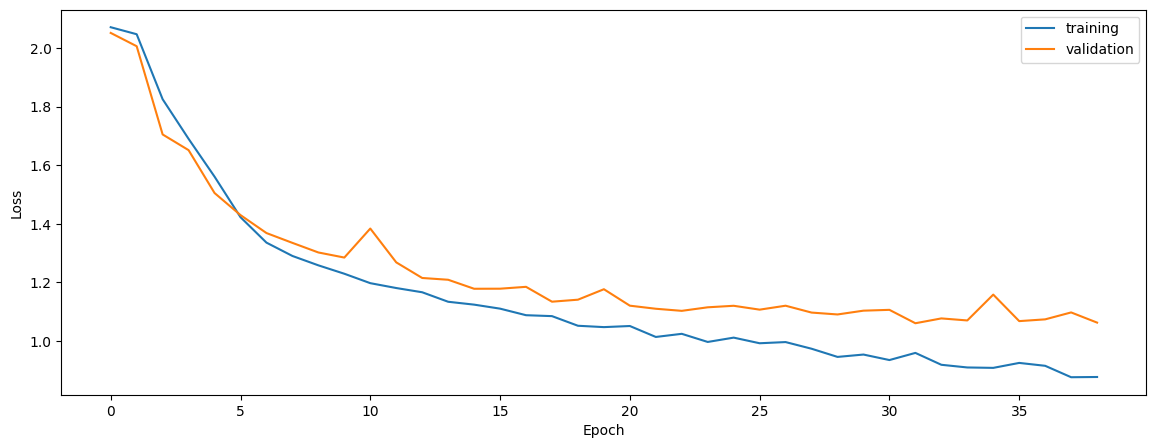

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.6445720521074704


0.5647832079554823


0.6305448516892195


In [9]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.5711631676523288


0.5330179361567636


0.5174642019254105


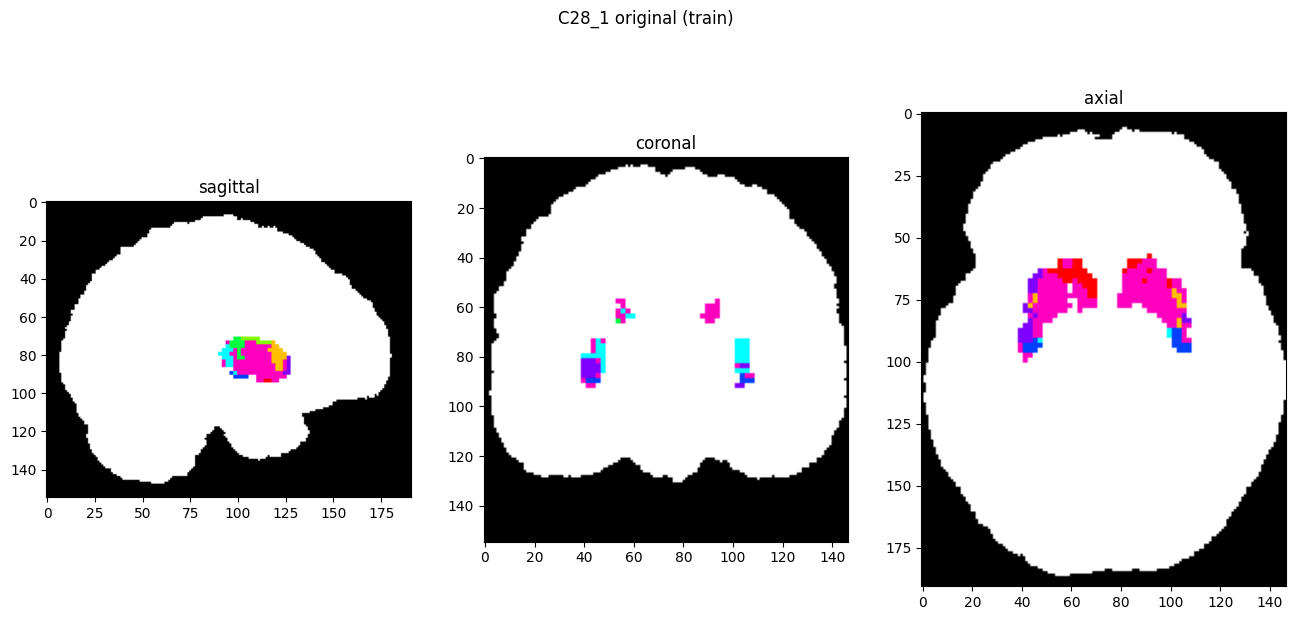

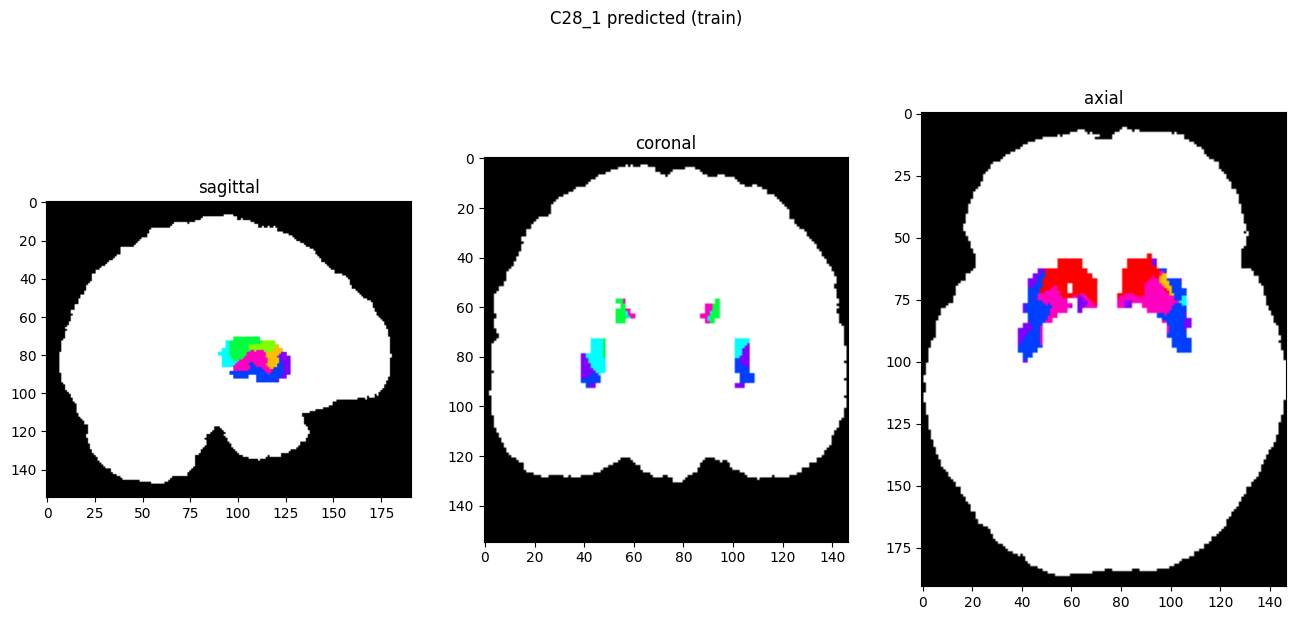

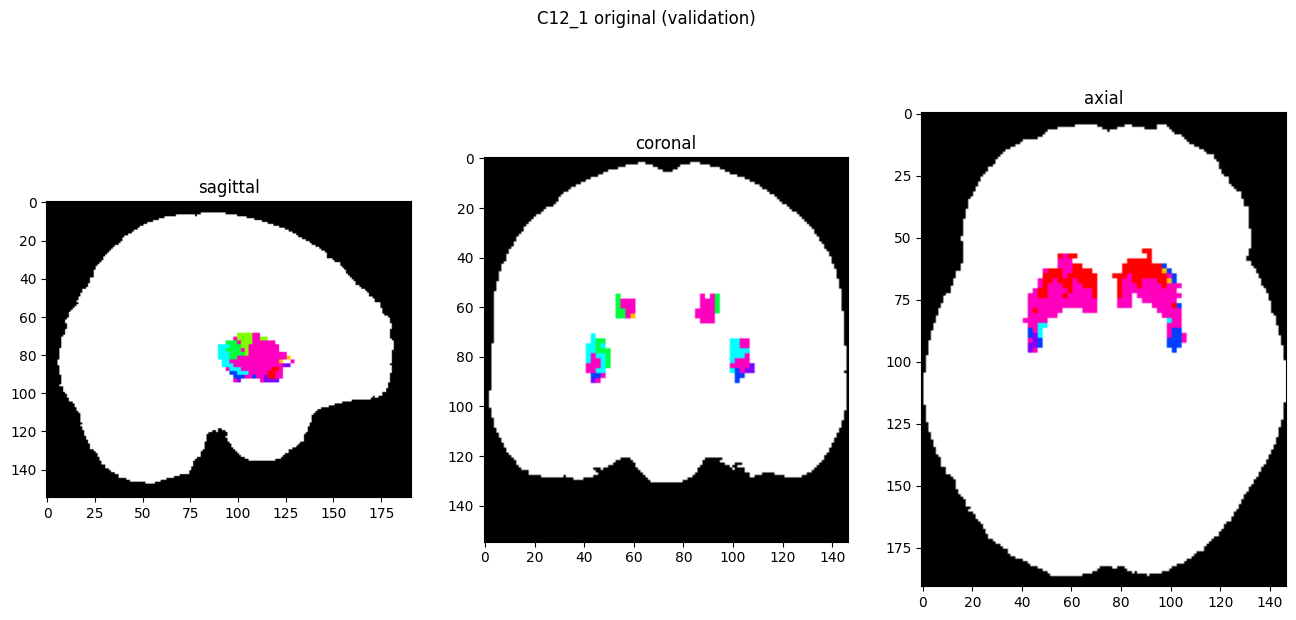

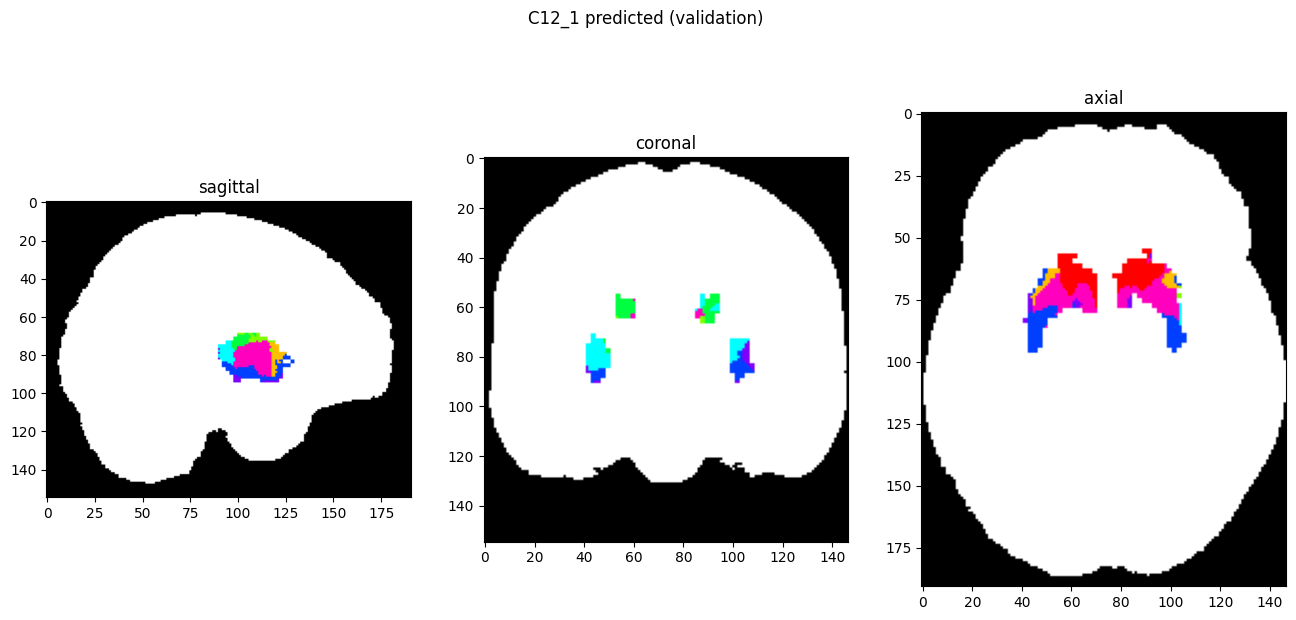

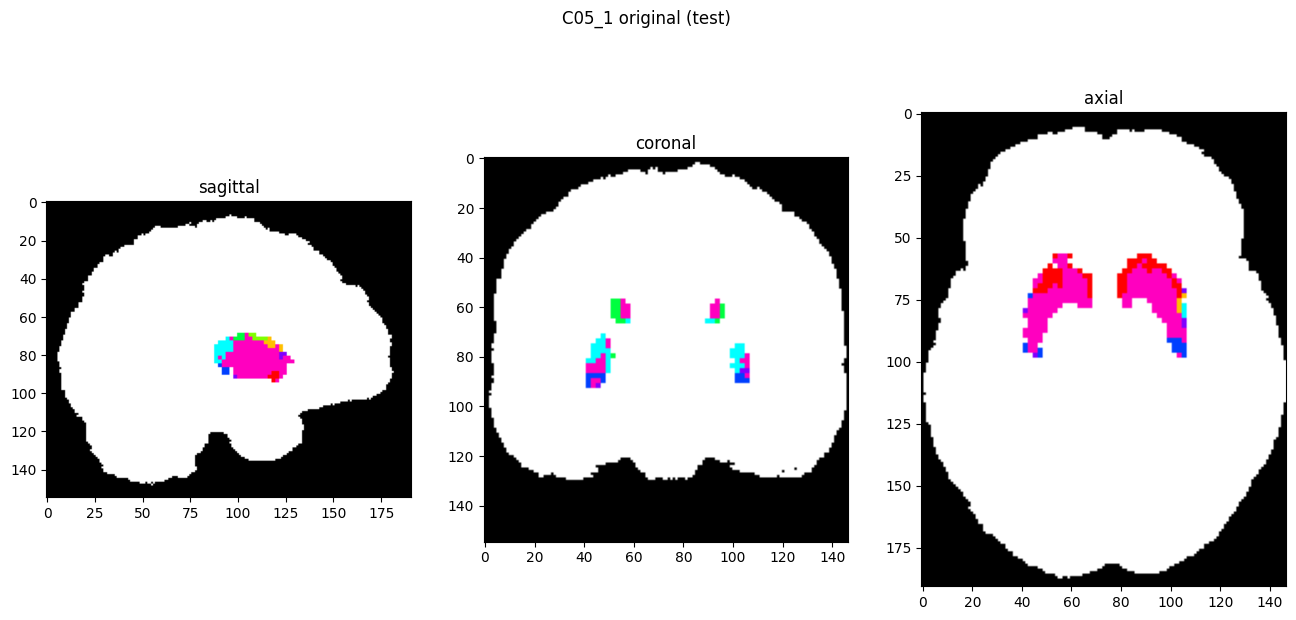

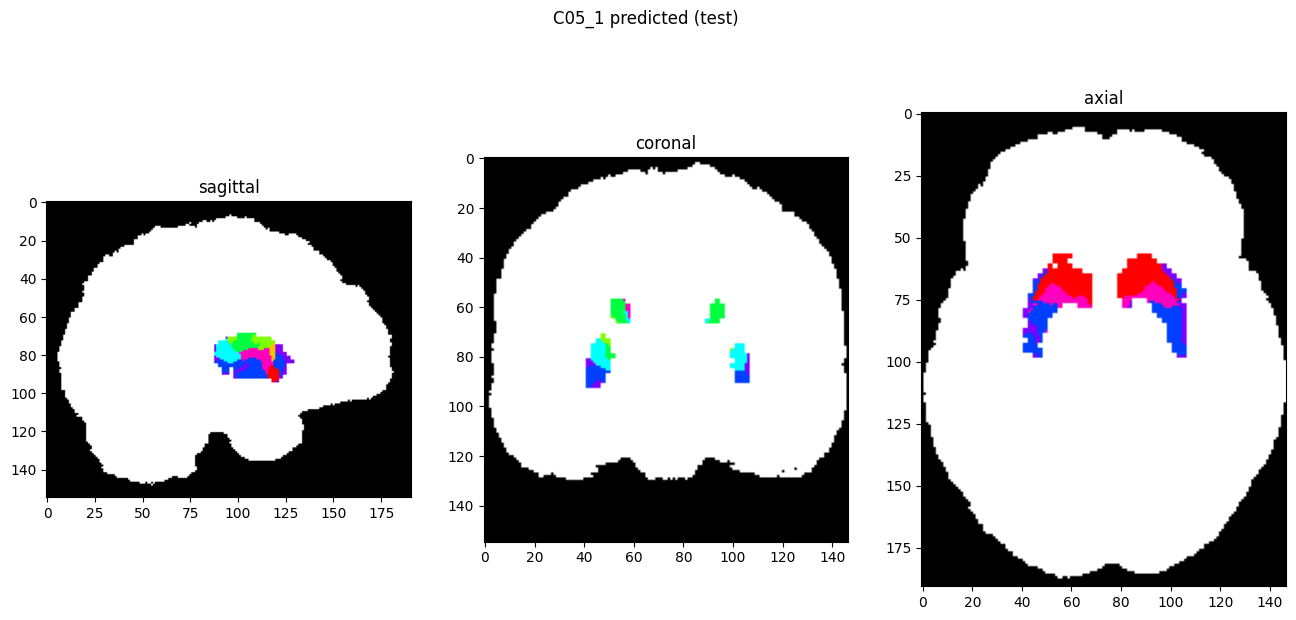

In [10]:
showResults(model, gen, threshold=0)